In [2]:
!pip install pandas
!pip install pillow
!pip install scipy
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib
!pip install ipywidgets
!pip install scikit-learn
!pip install tdqm

In [3]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [4]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy import stats
import ipywidgets as widgetsPext
from IPython.display import display
import io

In [17]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 7.0 MB/s  0:00:09m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 7.5 MB/s  0:00:02m0:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]


## BCT-partition single photo

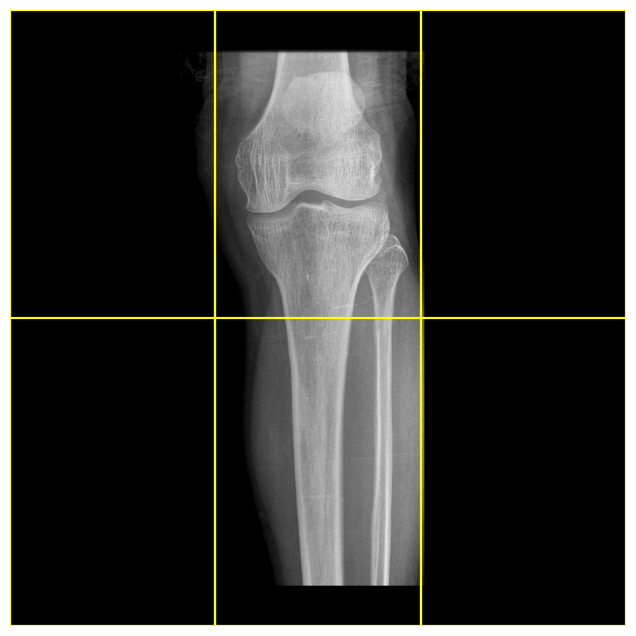

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import numpy as np

class BCTNode:
    def __init__(self, x0, x1, y0, y1, level=0):
        self.x0, self.x1 = x0, x1
        self.y0, self.y1 = y0, y1
        self.level = level
        self.children = []

def compute_splits(length, fractions):
    cum = 0
    splits = []
    for f in fractions[:-1]:  # last child takes remaining cells
        cum += f
        s = int(round(cum * length))
        splits.append(s)
    return splits

def hierarchical_bct_quantized(root, n_partitions, max_children):
    n_parents = math.ceil(n_partitions / max_children)
    base = n_partitions // n_parents
    rem = n_partitions % n_parents
    children_counts = [base+1 if i<rem else base for i in range(n_parents)]

    fractions = [c / n_partitions for c in children_counts]
    x_splits = compute_splits(root.x1 - root.x0, fractions)
    x_positions = [root.x0] + [root.x0 + s for s in x_splits] + [root.x1]

    for i, count in enumerate(children_counts):
        x0, x1 = x_positions[i], x_positions[i+1]
        parent = BCTNode(x0, x1, root.y0, root.y1, root.level+1)
        root.children.append(parent)

        fractions_h = [1/count]*count
        y_splits = compute_splits(root.y1 - root.y0, fractions_h)
        y_positions = [root.y0] + [root.y0 + s for s in y_splits] + [root.y1]

        for j in range(count):
            y0, y1 = y_positions[j], y_positions[j+1]
            child = BCTNode(x0, x1, y0, y1, parent.level+1)
            parent.children.append(child)

def draw_bct_on_image(root, image_path):
    img = mpimg.imread(image_path)
    h, w = img.shape[:2]

    # Scale root if image size differs
    root.x1 = w
    root.y1 = h

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img,cmap='gray')

    def draw_node(node):
        rect = plt.Rectangle((node.x0, node.y0),
                             node.x1 - node.x0,
                             node.y1 - node.y0,
                             edgecolor='yellow', facecolor='none', lw=1.5)
        ax.add_patch(rect)
        for child in node.children:
            draw_node(child)

    draw_node(root)
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)  # flip y-axis to match image coordinates
    ax.axis('off')
    plt.show()

# ---- Apply on an image ----
image_path = "final_square.png"  # 🔹 Replace with your image path
imge = Image.open(image_path).convert("L")
img = np.asarray(imge)
img = cv2.imread(image_path)
h, w = img.shape[:2]

root = BCTNode(0, w, 0, h)
n = int(input("Enter the number of nodes I want for Binary tree: "))
n_partition = (n+1)//2
hierarchical_bct_quantized(root, n_partition, max_children=2)
draw_bct_on_image(root, image_path)

## BCT partition CSV generation

In [ ]:
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
from scipy import stats
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# ----------------------------------------------
# BCT Partition Structure
# ----------------------------------------------
class BCTNode:
    def __init__(self, x0, x1, y0, y1, level=0):
        self.x0, self.x1 = x0, x1
        self.y0, self.y1 = y0, y1
        self.level = level
        self.children = []

def compute_splits(length, fractions):
    cum = 0
    splits = []
    for f in fractions[:-1]:
        cum += f
        s = int(round(cum * length))
        splits.append(s)
    return splits

def hierarchical_bct_quantized(root, n_partitions, max_children):
    n_parents = math.ceil(n_partitions / max_children)
    base = n_partitions // n_parents
    rem = n_partitions % n_parents
    children_counts = [base + 1 if i < rem else base for i in range(n_parents)]

    fractions = [c / n_partitions for c in children_counts]
    x_splits = compute_splits(root.x1 - root.x0, fractions)
    x_positions = [root.x0] + [root.x0 + s for s in x_splits] + [root.x1]

    for i, count in enumerate(children_counts):
        x0, x1 = x_positions[i], x_positions[i + 1]
        parent = BCTNode(x0, x1, root.y0, root.y1, root.level + 1)
        root.children.append(parent)

        fractions_h = [1 / count] * count
        y_splits = compute_splits(root.y1 - root.y0, fractions_h)
        y_positions = [root.y0] + [root.y0 + s for s in y_splits] + [root.y1]

        for j in range(count):
            y0, y1 = y_positions[j], y_positions[j + 1]
            child = BCTNode(x0, x1, y0, y1, parent.level + 1)
            parent.children.append(child)

# ----------------------------------------------
# Statistical Feature Functions
# ----------------------------------------------
def safe_moments(arr):
    if len(arr) < 2 or np.std(arr) < 1e-8:
        return {"skewness": 0.0, "kurtosis": 0.0}
    return {
        "skewness": float(stats.skew(arr)),
        "kurtosis": float(stats.kurtosis(arr))
    }

def extract_section_features(section_pixels):
    nonzero_pixels = section_pixels[section_pixels > 0]
    if nonzero_pixels.size < 2:
        return {"mean": 0, "median": 0, "std_dev": 0, "skewness": 0, "kurtosis": 0}

    nonzero_pixels = nonzero_pixels.astype(np.float64)
    moments = safe_moments(nonzero_pixels)
    return {
        "mean": float(np.mean(nonzero_pixels)),
        "median": float(np.median(nonzero_pixels)),
        "std_dev": float(np.std(nonzero_pixels)),
        "skewness": moments["skewness"],
        "kurtosis": moments["kurtosis"]
    }

# ----------------------------------------------
# Image Processing
# ----------------------------------------------
def process_single_image(args):
    img_path, class_label, label_map, n_partitions, max_children = args
    try:
        img = Image.open(img_path).convert("L")
        arr = np.array(img)
        h, w = arr.shape

        # Build BCT partition tree
        root = BCTNode(0, w, 0, h)
        hierarchical_bct_quantized(root, n_partitions, max_children)

        # Extract stats for each child region
        row_features = {}
        region_count = 0
        for parent in root.children:
            for child in parent.children:
                x0, x1 = int(child.x0), int(child.x1)
                y0, y1 = int(child.y0), int(child.y1)
                section = arr[y0:y1, x0:x1]

                stats_features = extract_section_features(section)
                for fname, val in stats_features.items():
                    row_features[f"region_{region_count+1}_{fname}"] = val
                region_count += 1

        row_features["label"] = label_map.get(class_label, -1)
        # row_features["image_name"] = os.path.basename(img_path)
        return row_features

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# ----------------------------------------------
# Dataset Processing
# ----------------------------------------------
def process_bct_dataset(root_folder, output_csv, n_partitions=11, max_children=2, num_workers=4):
    label_map = {"Normal": 0, "Osteoporosis": 1, "Osteopenia": 2}

    tasks = []
    for class_label in os.listdir(root_folder):
        class_folder = os.path.join(root_folder, class_label)
        if os.path.isdir(class_folder) and class_label in label_map:
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_folder, img_name)
                    tasks.append((img_path, class_label, label_map, n_partitions, max_children))

    all_rows = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_single_image, task) for task in tasks]
        for f in tqdm(as_completed(futures), total=len(tasks), desc="Processing BCT Images"):
            result = f.result()
            if result:
                all_rows.append(result)

    if not all_rows:
        print("No features extracted. Check dataset path.")
        return

    df = pd.DataFrame(all_rows)
    df.to_csv(output_csv, index=False)
    print(f"\nBCT region-based features saved to {output_csv}")

# ----------------------------------------------
# Execution
# ----------------------------------------------
if __name__ == "__main__":
    root_folder = "dataset"  # dataset/
    output_csv = "bct_features.csv"
    workers = max(1, os.cpu_count() - 1 if os.cpu_count() else 1)
    n = int(input("Enter the number of nodes I want for Binary tree: "))
    n_partition = (n+1)//2
    hierarchical_bct_quantized(root, n_partition, max_children=4)
    process_bct_dataset(root_folder, output_csv, n_partition, max_children=2, num_workers=workers)


In [6]:
#path = "dataset/Normal/4.png"
path = 'dataset/Osteopenia/OP4.JPEG'

In [7]:
img_main = Image.open(path)
img_array = np.asarray(img_main)
image_height = len(img_array)
image_width = len(img_array[0])
print("Image Dimension")
print(image_height, "X" ,image_width)

Image Dimension
1024 X 1024


In [8]:
from PIL import Image

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

In [10]:
data = pd.read_csv('bct_features.csv')
data.head()

region_1_mean  region_1_median  region_1_std_dev  region_1_skewness  \
0     148.735337            160.0         50.297054          -0.318308   
1       0.000000              0.0          0.000000           0.000000   
2     155.077105            154.0         42.407716          -0.506523   
3     181.792703            197.0         51.329836          -0.851197   
4     173.925895            182.0         44.457834          -1.049063   

   region_1_kurtosis  region_2_mean  region_2_median  region_2_std_dev  \
0          -1.021715     137.220568            146.0         49.847391   
1           0.000000     107.834608            119.0         44.353106   
2          -0.078426     122.857320            134.0         46.322014   
3           0.208361     153.485480            161.0         50.788023   
4           1.279973     172.129429            184.0         50.598134   

   region_2_skewness  region_2_kurtosis  ...  region_10_median  \
0          -0.525720          -0.373438  ...             184.0   
1          -0.613688          -0.469124  ...             112.0   
2          -1.104139           0.619009  ...             150.0   
3          -0.924932           0.692701  ...             169.0   
4          -1.350906           1.461208  ...             146.0   

   region_10_std_dev  region_10_skewness  region_10_kurtosis  region_11_mean  \
0          66.213236           -0.834757           -0.553790      161.450045   
1          51.727032           -0.094454           -0.948150      214.881512   
2          53.450026           -0.904731            0.238251      163.616158   
3          42.602141           -0.925121            1.080823      153.030007   
4          49.192405           -0.765257            0.055154      152.356707   

   region_11_median  region_11_std_dev  region_11_skewness  \
0             180.0          67.670465           -0.832602   
1             220.0          25.957380           -3.943210   
2             177.0          44.617249           -1.664982   
3             155.0          42.163570           -1.244348   
4             143.0          36.593690           -0.020714   

   region_11_kurtosis  label  
0           -0.508887      2  
1           22.264445      2  
2            2.625789      2  
3            1.753637      2  
4            1.337331      2  

[5 rows x 56 columns]

In [11]:
data[0:5]

region_1_mean  region_1_median  region_1_std_dev  region_1_skewness  \
0     148.735337            160.0         50.297054          -0.318308   
1       0.000000              0.0          0.000000           0.000000   
2     155.077105            154.0         42.407716          -0.506523   
3     181.792703            197.0         51.329836          -0.851197   
4     173.925895            182.0         44.457834          -1.049063   

   region_1_kurtosis  region_2_mean  region_2_median  region_2_std_dev  \
0          -1.021715     137.220568            146.0         49.847391   
1           0.000000     107.834608            119.0         44.353106   
2          -0.078426     122.857320            134.0         46.322014   
3           0.208361     153.485480            161.0         50.788023   
4           1.279973     172.129429            184.0         50.598134   

   region_2_skewness  region_2_kurtosis  ...  region_10_median  \
0          -0.525720          -0.373438  ...             184.0   
1          -0.613688          -0.469124  ...             112.0   
2          -1.104139           0.619009  ...             150.0   
3          -0.924932           0.692701  ...             169.0   
4          -1.350906           1.461208  ...             146.0   

   region_10_std_dev  region_10_skewness  region_10_kurtosis  region_11_mean  \
0          66.213236           -0.834757           -0.553790      161.450045   
1          51.727032           -0.094454           -0.948150      214.881512   
2          53.450026           -0.904731            0.238251      163.616158   
3          42.602141           -0.925121            1.080823      153.030007   
4          49.192405           -0.765257            0.055154      152.356707   

   region_11_median  region_11_std_dev  region_11_skewness  \
0             180.0          67.670465           -0.832602   
1             220.0          25.957380           -3.943210   
2             177.0          44.617249           -1.664982   
3             155.0          42.163570           -1.244348   
4             143.0          36.593690           -0.020714   

   region_11_kurtosis  label  
0           -0.508887      2  
1           22.264445      2  
2            2.625789      2  
3            1.753637      2  
4            1.337331      2  

[5 rows x 56 columns]

In [23]:
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape

(616, 56)

In [24]:
import numpy as np

print("Any NaN in X? ", np.isnan(X).any())
print("How many NaNs? ", np.isnan(X).sum())

Any NaN in X?  False
How many NaNs?  0


## Machine Learning 80/20

In [238]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [239]:
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)


## SVM - kernel = linear 80

In [240]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.001,0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["linear"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=linear;, score=0.641 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=linear;, score=0.569 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=1, svc__kernel=linear;, score=0.569 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=linear;, score=0.569 total time=   0.0s
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=1, svc__kernel=linear;, score=0.627 total time=   0.0s
[CV 4/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=1, svc__kernel=linear;, score=0.590 total time=   0.0s
[CV 5/5] END svc__C=0.00

In [241]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="linear", C=0.1, gamma=0.01, decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=0.1, decision_function_shape='ovo', gamma=0.01, kernel='linear',
    random_state=42)

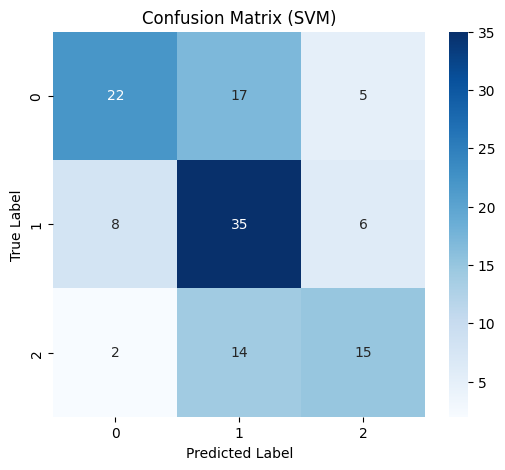


Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.50      0.58        44
           1       0.53      0.71      0.61        49
           2       0.58      0.48      0.53        31

    accuracy                           0.58       124
   macro avg       0.60      0.57      0.57       124
weighted avg       0.60      0.58      0.58       124

Training Accuracy: 0.7134146341463414
Test Accuracy: 0.5806451612903226


In [242]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

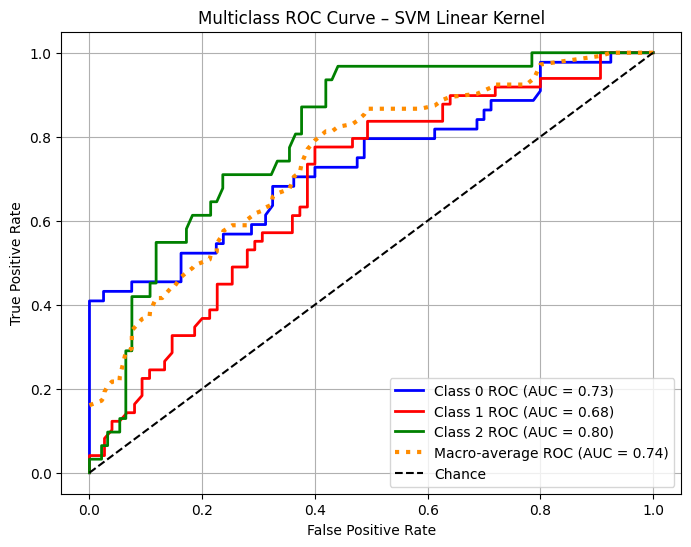

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.1):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVC(
        kernel="linear",
        C=C,
        probability=True
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])
    
    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})")

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})", lw=3)

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – SVM Linear Kernel")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.01)


## SVM - kernal = sigmoid 80

In [244]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [245]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with sigmoid
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.001,0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["sigmoid"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.185 total time=   0.0s
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.186 total time=   0.0s
[CV 4/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.190 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.185 total time=   0.0s
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=sigmoid;, score=0.185 total time=   0.0s
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.190 total time=   0.0s
[CV 4/5]

In [246]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="sigmoid", C=1, gamma='scale', decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', kernel='sigmoid', random_state=42)

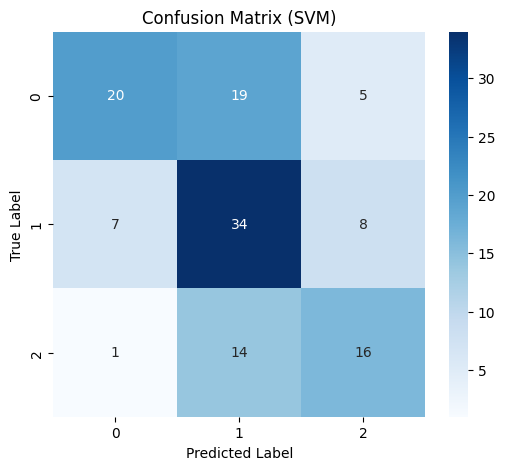


Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.45      0.56        44
           1       0.51      0.69      0.59        49
           2       0.55      0.52      0.53        31

    accuracy                           0.56       124
   macro avg       0.59      0.55      0.56       124
weighted avg       0.59      0.56      0.56       124

Training Accuracy: 0.6463414634146342
Test Accuracy: 0.5645161290322581


In [247]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


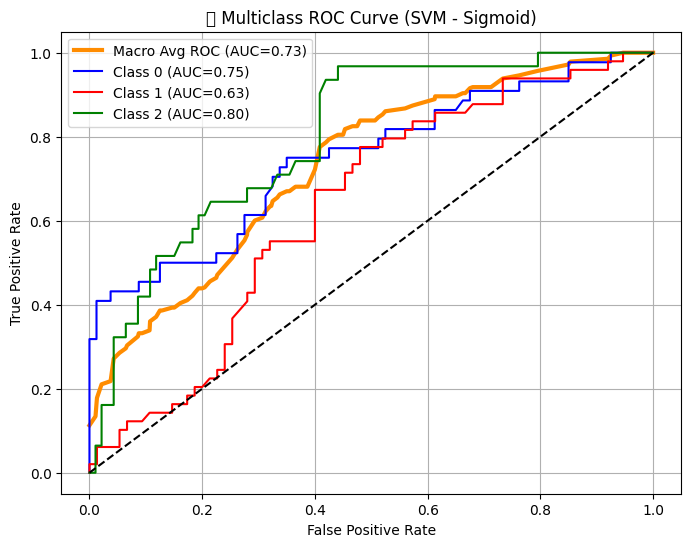

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve

# -----------------------------------------
# 1️⃣  MULTICLASS ROC CURVE  (ONE-VS-REST)
# -----------------------------------------

# SVM must be refitted with probability=True for ROC
svm_prob = SVC(
    kernel="sigmoid",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for OVR ROC curve
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# -------- Plot ROC -------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         label=f"Macro Avg ROC (AUC={roc_auc['macro']:.2f})", linewidth=3)

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM - Sigmoid)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## SVM - kernal = polynomial 80

In [249]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [250]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.001,0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["poly"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.185 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.185 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.535 total time=   0.0s
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.186 total time=   0.0s
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.502 total time=   0.0s
[CV 4/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.190 total time=   0.0s
[CV 4/5] END svc__C=0.001, 

In [251]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="poly", C=0.01, gamma=0.1, decision_function_shape="ovo",random_state = 42,class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=0.01, class_weight='balanced', decision_function_shape='ovo', gamma=0.1,
    kernel='poly', random_state=42)

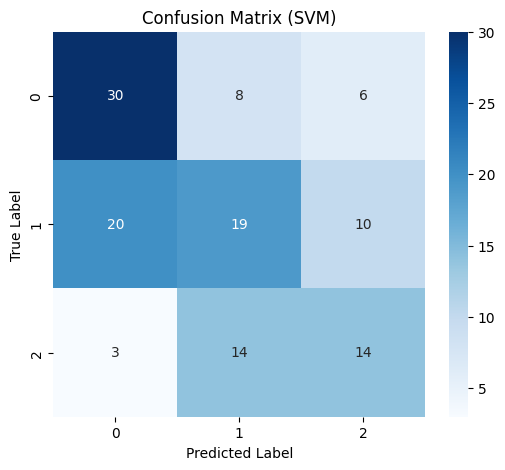


Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.68      0.62        44
           1       0.46      0.39      0.42        49
           2       0.47      0.45      0.46        31

    accuracy                           0.51       124
   macro avg       0.50      0.51      0.50       124
weighted avg       0.50      0.51      0.50       124

Training Accuracy: 0.7113821138211383
Test Accuracy: 0.5080645161290323


In [252]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


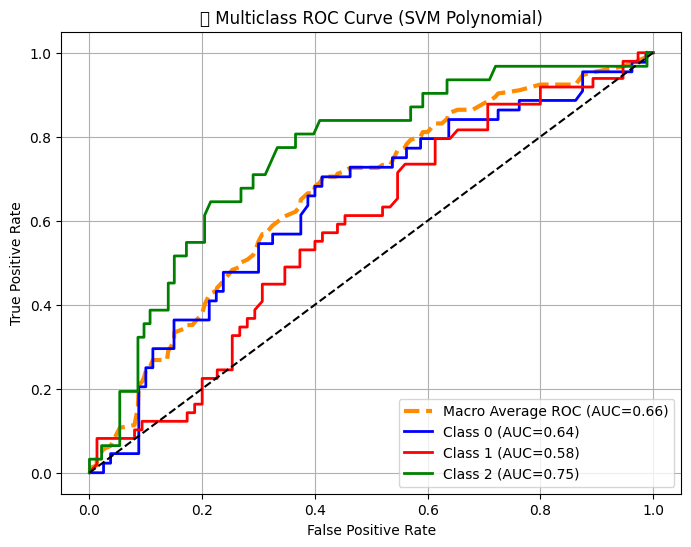

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (ONE-VS-REST)
# ============================================================

# SVM must be trained with probability=True for ROC
svm_prob = SVC(
    kernel="poly",
    C=0.1,
    gamma=0.01,
    decision_function_shape="ovo",
    probability=True,
    class_weight=None,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize test labels
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

# Store ROC curves
fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# ------------ Plot ROC --------------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         linewidth=3, linestyle='--',
         label=f"Macro Average ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM Polynomial)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## SVM - kernal = rbf 80

In [254]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.001,0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["rbf"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.190 total time=   0.0s
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.186 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=1, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 4/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.190 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__cla

In [255]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="rbf", probability=True, C=1, gamma=0.01, decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)


SVC(C=1, decision_function_shape='ovo', gamma=0.01, probability=True,
    random_state=42)

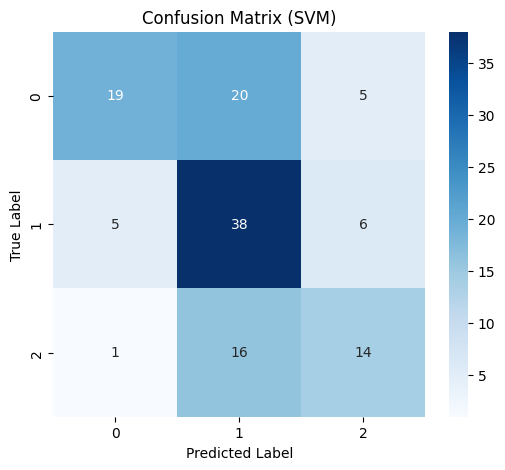


Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.43      0.55        44
           1       0.51      0.78      0.62        49
           2       0.56      0.45      0.50        31

    accuracy                           0.57       124
   macro avg       0.61      0.55      0.56       124
weighted avg       0.61      0.57      0.56       124

Training Accuracy: 0.693089430894309
Test Accuracy: 0.5725806451612904


In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


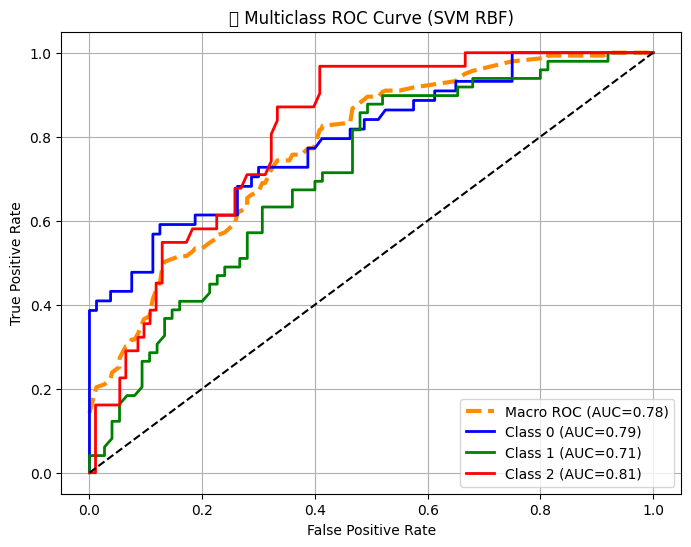

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (SVM must use probability=True)
# ============================================================

svm_prob = SVC(
    kernel="rbf",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,    # Required for ROC Curve
    class_weight=None,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for One-vs-Rest ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange', linewidth=3,
         linestyle='--', label=f"Macro ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'green', 'red']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("🔵 Multiclass ROC Curve (SVM RBF)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


#

In [75]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
      # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    return plt

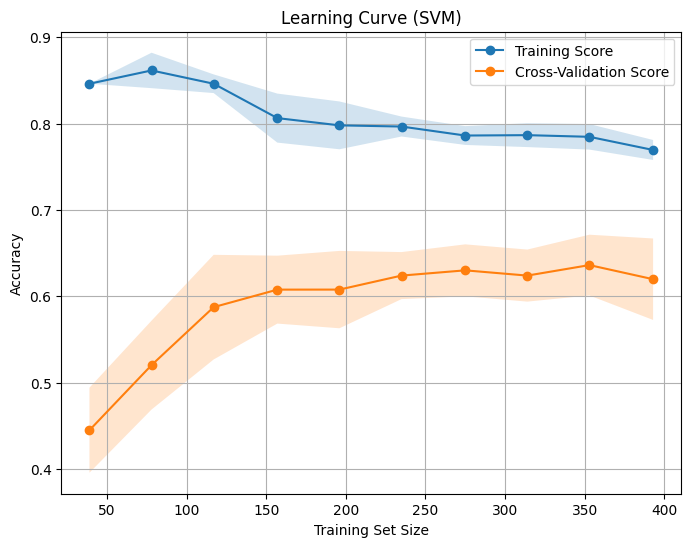

In [76]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_train, y_train,
    cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy", n_jobs=-1
)

# Mean ± std
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM)")
plt.legend()
plt.grid(True)
plt.show()


## KNeighborsClassifier = 80

In [259]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [260]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [78]:
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
X[np.isnan(X)] = 0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [261]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# --- Load your data ---
df = pd.read_csv("triangle_features_78_stable_final_file.csv")
X = df.drop("label",axis=1).values
y = df["label"].values

# Replace NaNs
X[np.isnan(X)] = 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Build a pipeline (scaler + KNN) ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# --- Define parameter grid ---
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidean
    "knn__metric": ["minkowski"]
}

# --- Grid Search ---
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

# --- Results ---
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Evaluate on test
test_accuracy = grid.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV accuracy: 0.6017316017316017
Test accuracy: 0.6693548387096774


In [262]:
knn = KNeighborsClassifier(n_neighbors=9, metric="minkowski", p=1,weights="uniform")  # Euclidean distance
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9, p=1)

In [263]:
y_pred = knn.predict(X_test)
y_probs = knn.predict_proba(X_test)[:, 1]

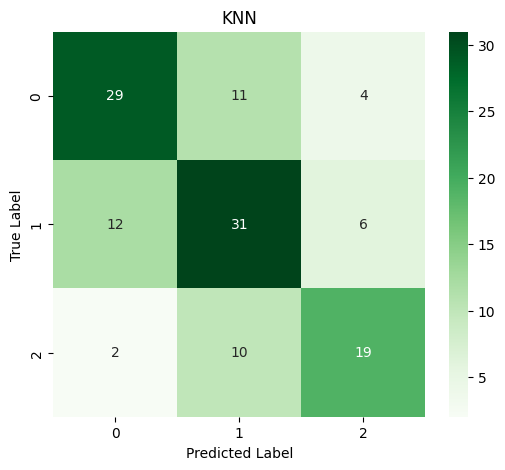


Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.66      0.67        44
           1       0.60      0.63      0.61        49
           2       0.66      0.61      0.63        31

    accuracy                           0.64       124
   macro avg       0.64      0.63      0.64       124
weighted avg       0.64      0.64      0.64       124

Training Accuracy: 0.6463414634146342
Test Accuracy: 0.6370967741935484


In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = knn.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, knn.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


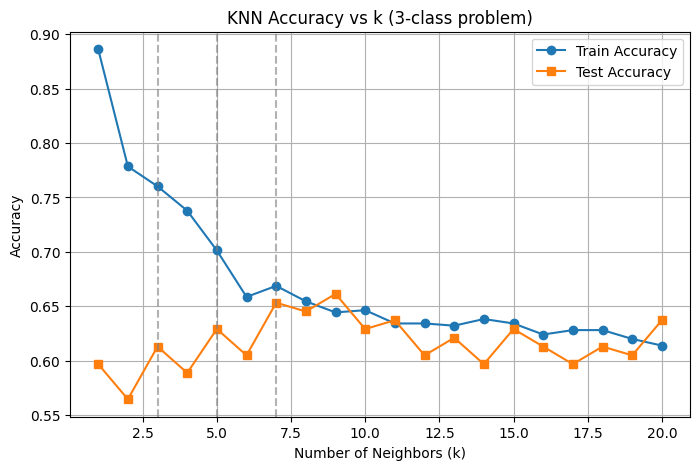

In [265]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_acc = []
test_acc = []
k_values = range(1, 21)  # test k=1 to 20

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc.append(accuracy_score(y_train, knn.predict(X_train)))
    test_acc.append(accuracy_score(y_test, knn.predict(X_test)))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(k_values, train_acc, marker='o', label="Train Accuracy")
plt.plot(k_values, test_acc, marker='s', label="Test Accuracy")
plt.axvline(x=3, color="gray", linestyle="--", alpha=0.6)  # mark k=3
plt.axvline(x=5, color="gray", linestyle="--", alpha=0.6)  # mark k=5
plt.axvline(x=7, color="gray", linestyle="--", alpha=0.6)  # mark k=7
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k (3-class problem)")
plt.legend()
plt.grid(True)
plt.show()


In [266]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

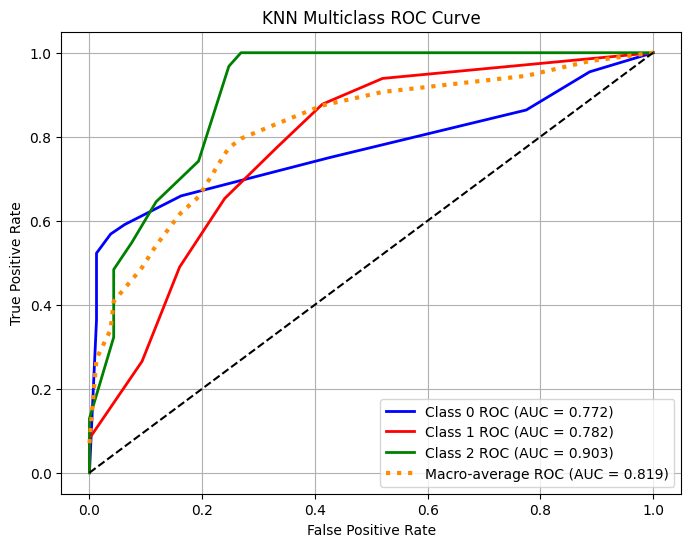

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. KNN ACCURACY CURVE (Learning Curve)
# ==========================================================

# 📌 2. KNN LOSS CURVE (1 – Accuracy vs K)
# ==========================================================



# ==========================================================
# 📌 3. KNN MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_knn_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    knn_model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=9,
            weights="uniform",
            metric="minkowski",
            p=1
        ))
    ])

    knn_model.fit(X_train, y_train)
    y_score = knn_model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("KNN Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL KNN PLOTS
# ==========================================================


plot_knn_multiclass_roc(X_train, X_test, y_train, y_test)


## RandomForest 80

In [269]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it

X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

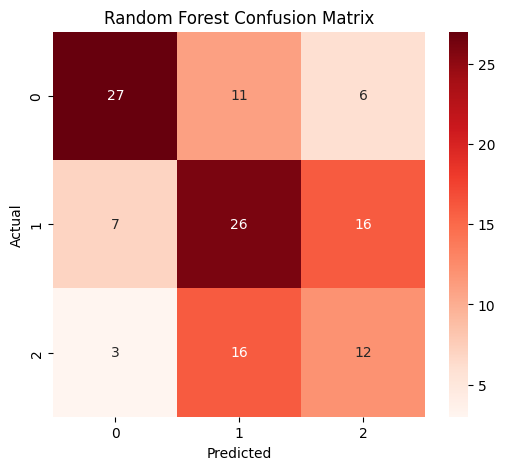


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.67        44
           1       0.49      0.53      0.51        49
           2       0.35      0.39      0.37        31

    accuracy                           0.52       124
   macro avg       0.52      0.51      0.52       124
weighted avg       0.54      0.52      0.53       124

Training Accuracy: 0.9207317073170732
Test Accuracy: 0.5241935483870968


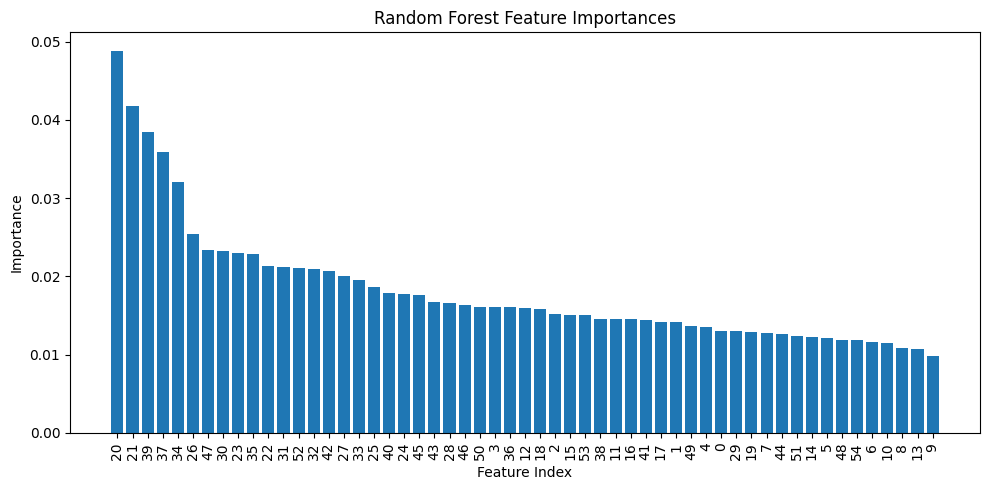

In [270]:
from sklearn.ensemble import RandomForestClassifier

# --- 5. Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,    # number of trees
    max_depth=None,      # let trees expand fully
    random_state=42,
    n_jobs=-1            # use all CPU cores
)
rf.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = rf.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
# --- 9. Feature Importance Plot ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices, rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

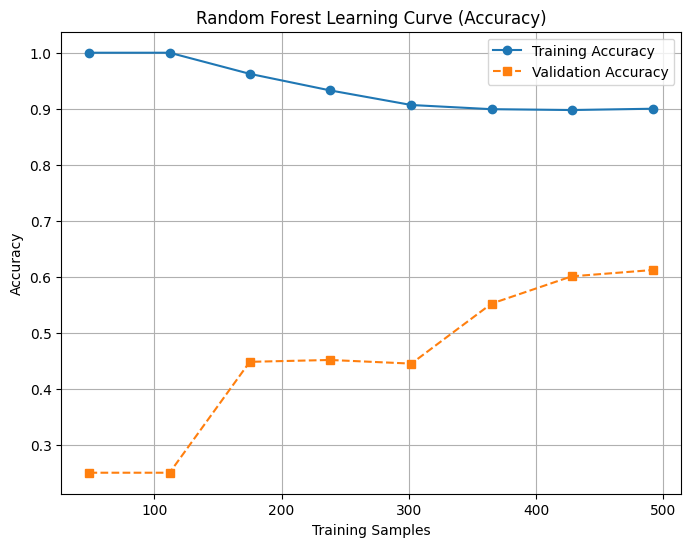

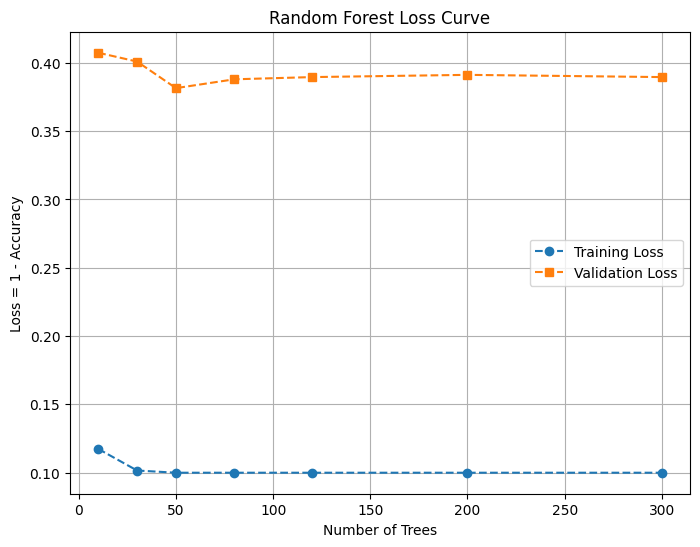

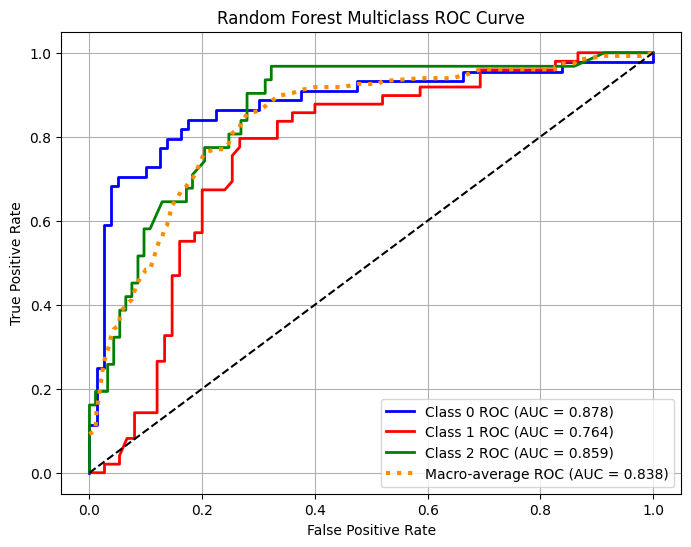

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. RANDOM FOREST ACCURACY CURVE (Learning Curve)
# ==========================================================
def plot_rf_accuracy_curve(X, y):
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    )

    train_sizes, train_scores, val_scores = learning_curve(
        rf_model,
        X, y,
        cv=5,
        scoring="accuracy",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.title("Random Forest Learning Curve (Accuracy)")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()


# ==========================================================
# 📌 2. RANDOM FOREST LOSS CURVE (1 – accuracy vs trees)
# ==========================================================
def plot_rf_loss_curve(X, y):
    n_estimators_list = [10, 30, 50, 80, 120, 200, 300]

    param_grid = {
        "n_estimators": n_estimators_list
    }

    rf_model = RandomForestClassifier(random_state=42)

    grid = GridSearchCV(
        rf_model,
        {"n_estimators": n_estimators_list},
        cv=5,
        scoring="accuracy",
        return_train_score=True,
        n_jobs=-1
    )

    grid.fit(X, y)

    train_acc = grid.cv_results_["mean_train_score"]
    val_acc = grid.cv_results_["mean_test_score"]

    train_loss = 1 - train_acc
    val_loss = 1 - val_acc

    plt.figure(figsize=(8, 6))
    plt.plot(n_estimators_list, train_loss, "--o", label="Training Loss")
    plt.plot(n_estimators_list, val_loss, "--s", label="Validation Loss")
    plt.xlabel("Number of Trees")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("Random Forest Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


# ==========================================================
# 📌 3. RANDOM FOREST MULTICLASS ROC CURVE
# ==========================================================
def plot_rf_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i]
        )
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot ROC
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":", lw=3,
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL PLOTS
# ==========================================================

plot_rf_accuracy_curve(X, y)
plot_rf_loss_curve(X, y)
plot_rf_multiclass_roc(X_train, X_test, y_train, y_test)

## Logistic Regression 80

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


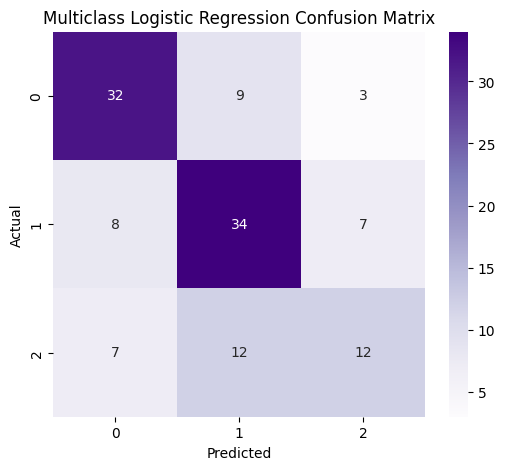


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        44
           1       0.62      0.69      0.65        49
           2       0.55      0.39      0.45        31

    accuracy                           0.63       124
   macro avg       0.61      0.60      0.60       124
weighted avg       0.62      0.63      0.62       124

Training Accuracy: 0.8882113821138211
Test Accuracy: 0.6290322580645161


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver="lbfgs",
        multi_class="multinomial",
        max_iter=3000,
        random_state=42
    )
)
# --- 5. Multiclass Logistic Regression ---
#  # use softmax for multiclass     
logreg.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = logreg.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiclass Logistic Regression Confusion Matrix")
plt.show()

# --- 8. Classification Report ---bct_features.csv
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, logreg.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


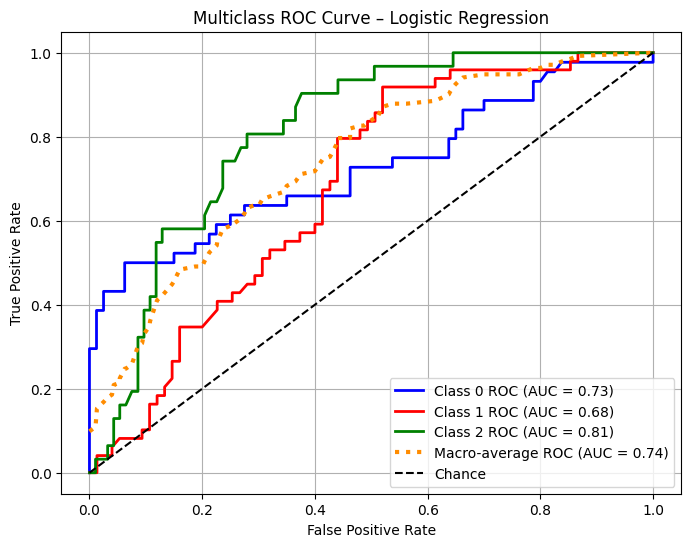

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle





# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        solver="lbfgs",
        multi_class="multinomial",
        C=C,
        max_iter=2000
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-Average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Logistic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0)


## DecisionTree 80

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

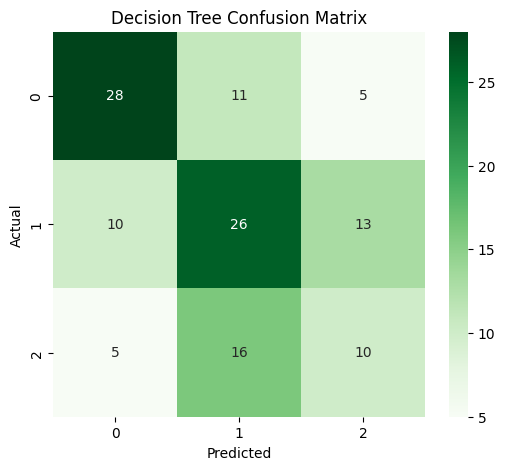


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64        44
           1       0.49      0.53      0.51        49
           2       0.36      0.32      0.34        31

    accuracy                           0.52       124
   macro avg       0.50      0.50      0.50       124
weighted avg       0.51      0.52      0.51       124

Training Accuracy: 0.9207317073170732
Test Accuracy: 0.5161290322580645


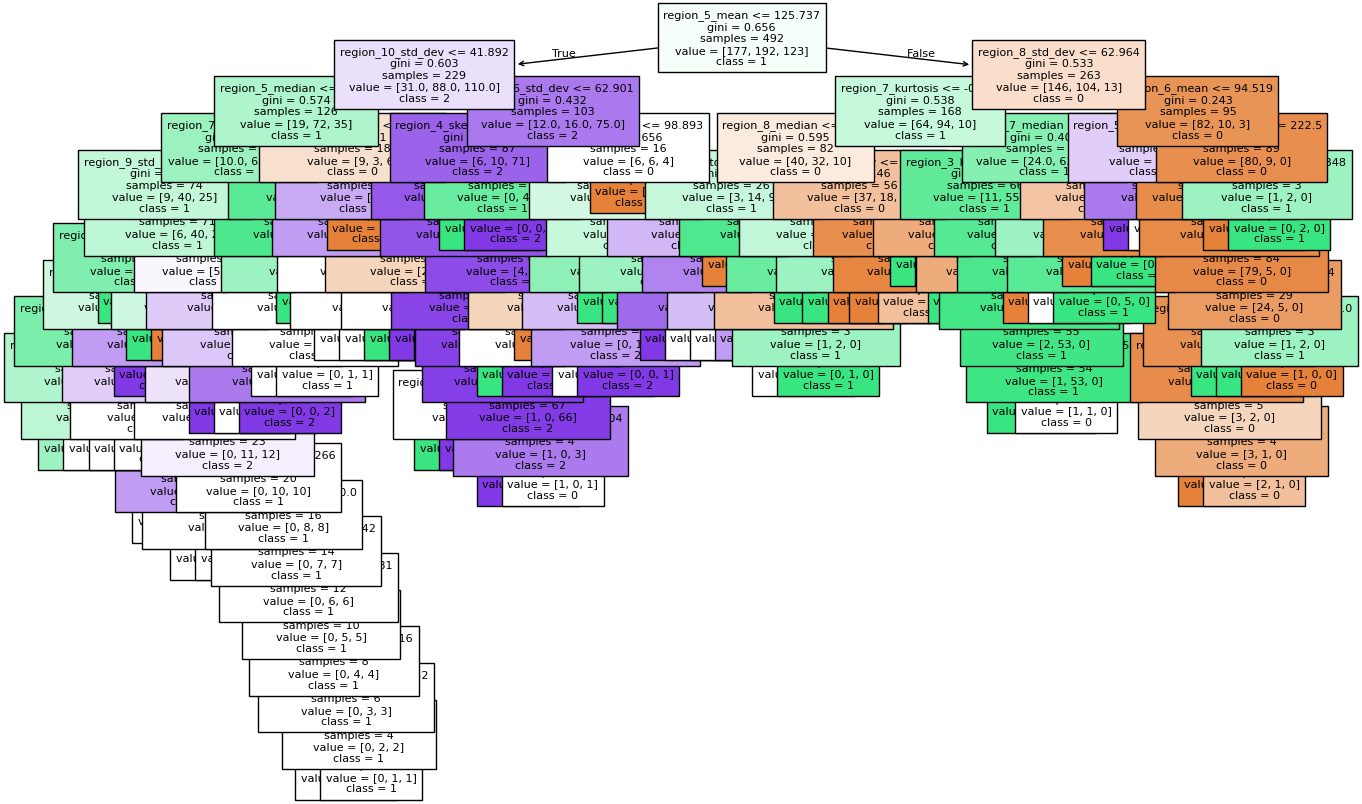

In [272]:

from sklearn.tree import DecisionTreeClassifier, plot_tree



# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
dt = DecisionTreeClassifier(
    criterion="gini",   # or "entropy"
    max_depth=None,     # you can tune this (e.g., 5, 10) to prevent overfitting
    random_state=42
)
dt.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = dt.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, dt.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 10. Plot the Tree (small datasets only, large trees may look messy) ---
plt.figure(figsize=(16,10))
plot_tree(dt, filled=True, feature_names=df.drop("label", axis=1).columns,
          class_names=[str(c) for c in np.unique(y)], fontsize=8)
plt.show()

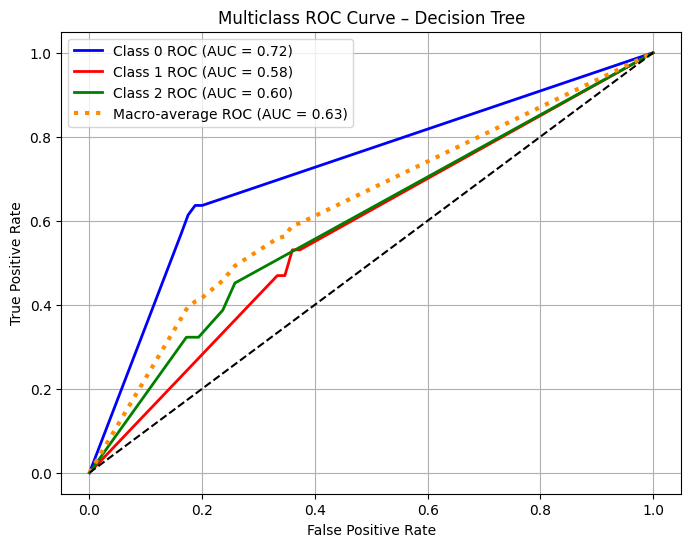

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_dt(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = DecisionTreeClassifier(
        criterion="gini",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Decision Tree")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_dt(X_train, X_test, y_train, y_test)

## Gradient Boosting 80

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



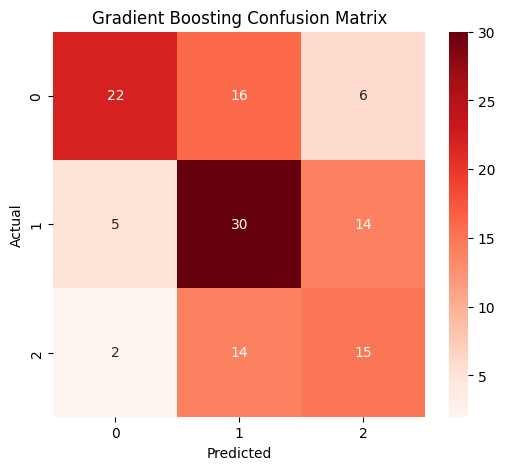


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.50      0.60        44
           1       0.50      0.61      0.55        49
           2       0.43      0.48      0.45        31

    accuracy                           0.54       124
   macro avg       0.56      0.53      0.54       124
weighted avg       0.57      0.54      0.55       124

Training Accuracy: 0.823170731707317
Test Accuracy: 0.5403225806451613


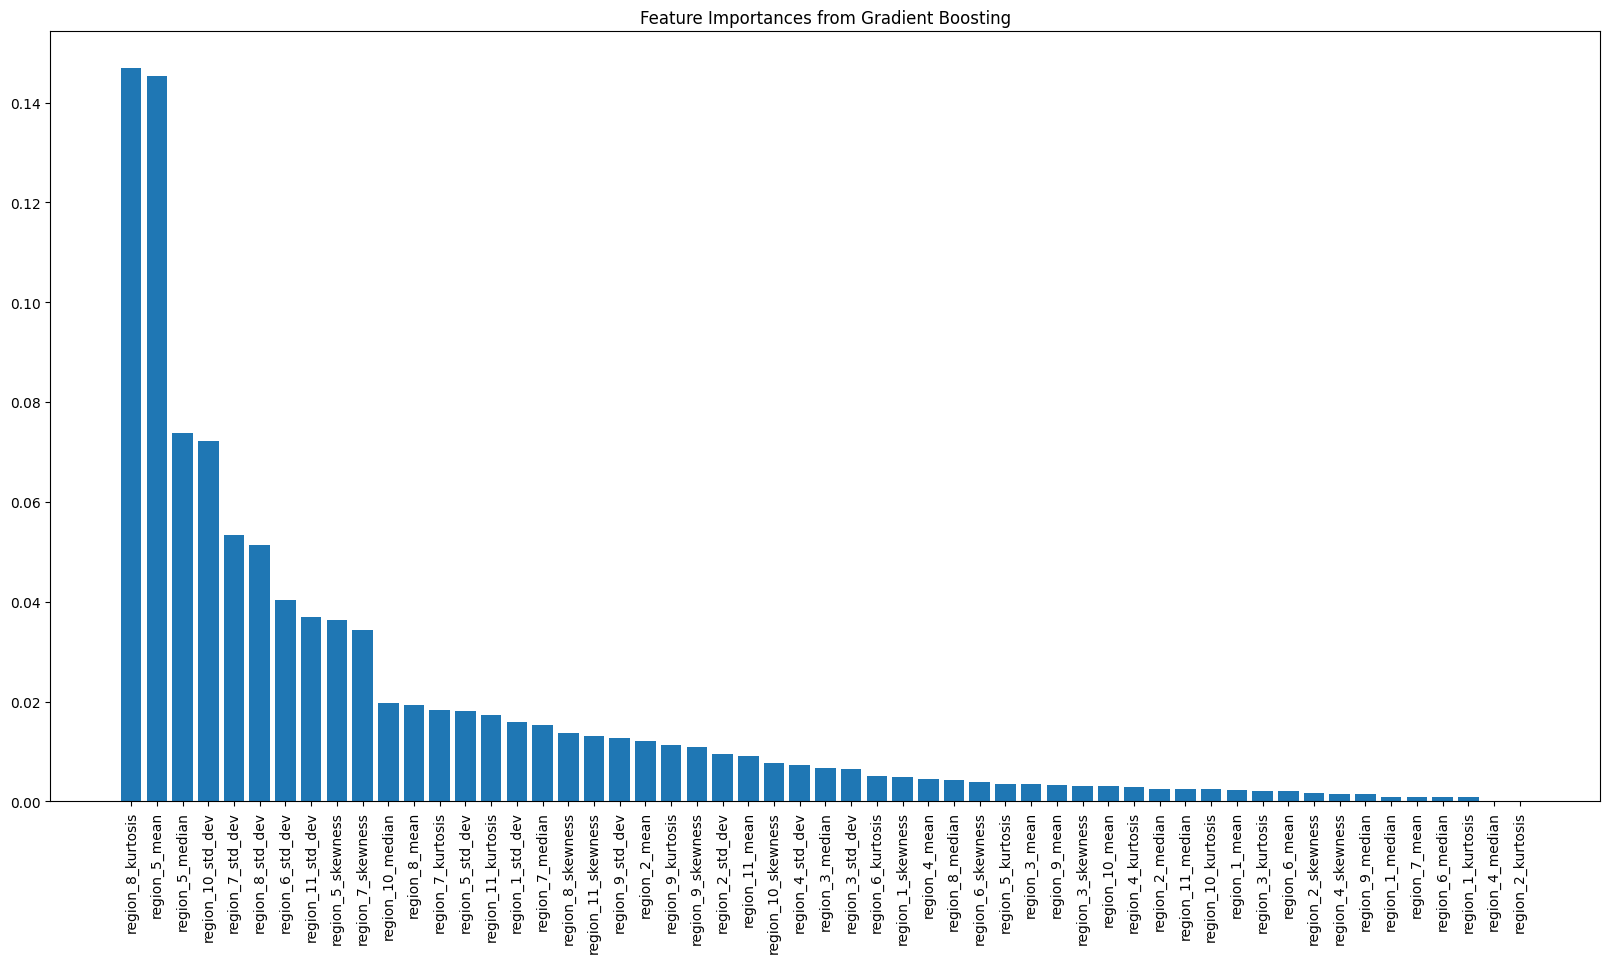

In [275]:

from sklearn.ensemble import GradientBoostingClassifier


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Gradient Boosting Classifier ---
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.01,    # step size shrinkage
    max_depth=3,          # depth of each tree
    random_state=42
)

gb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 9. Feature Importance ---
plt.figure(figsize=(20,10))
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), df.drop("label", axis=1).columns[indices], rotation=90)
plt.title("Feature Importances from Gradient Boosting")
plt.show()


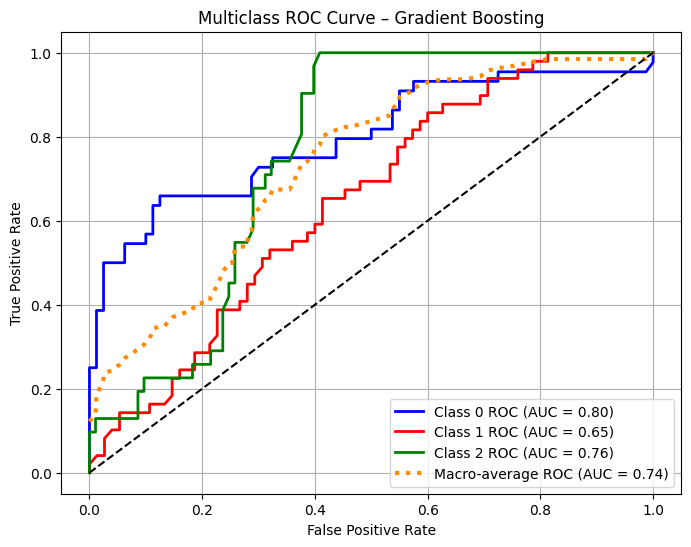

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle





# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_gb(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GradientBoostingClassifier(
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gradient Boosting")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_gb(X_train, X_test, y_train, y_test)


## Gausian Naive Bayes 80

In [278]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

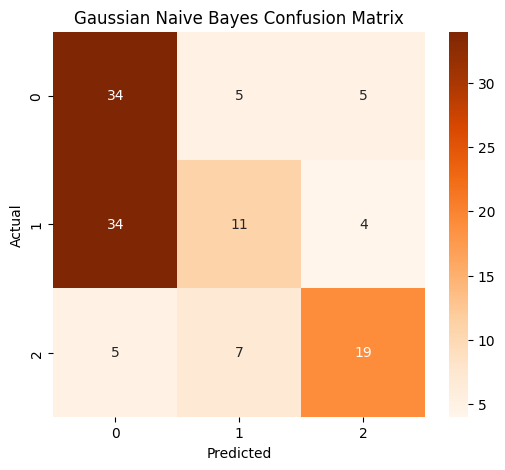


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.77      0.58        44
           1       0.48      0.22      0.31        49
           2       0.68      0.61      0.64        31

    accuracy                           0.52       124
   macro avg       0.54      0.54      0.51       124
weighted avg       0.52      0.52      0.49       124

Training Accuracy: 0.5813008130081301
Test Accuracy: 0.5161290322580645


In [279]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40, stratify=y
)

# --- 4. Gaussian Naive Bayes Model ---
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gnb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gnb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


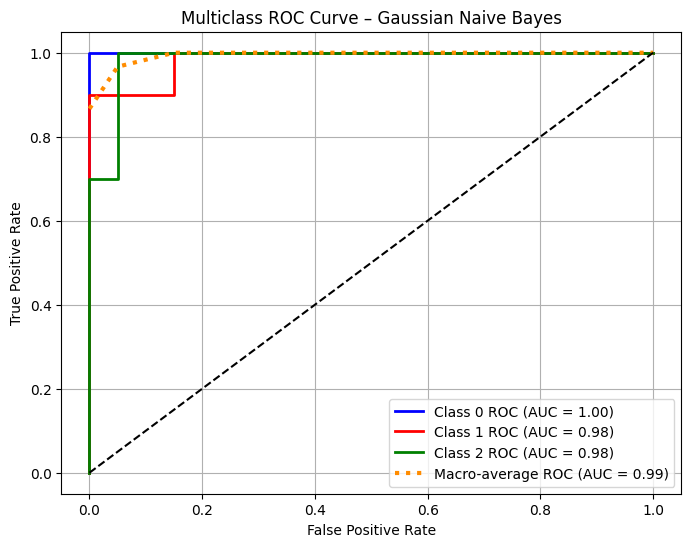

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 Prepare Data
# ==========================================================
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



    



# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_multiclass_roc_nb(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GaussianNB()
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gaussian Naive Bayes")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_nb(X_train, X_test, y_train, y_test)


## XGBoost-80

In [68]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 5.6 MB/s  0:00:20m0:00:0100:01
Note: you may need to restart the kernel to use updated packages.


/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati

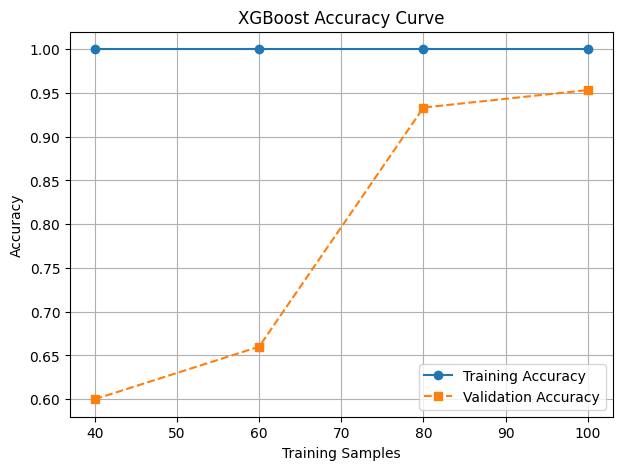

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:07:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati

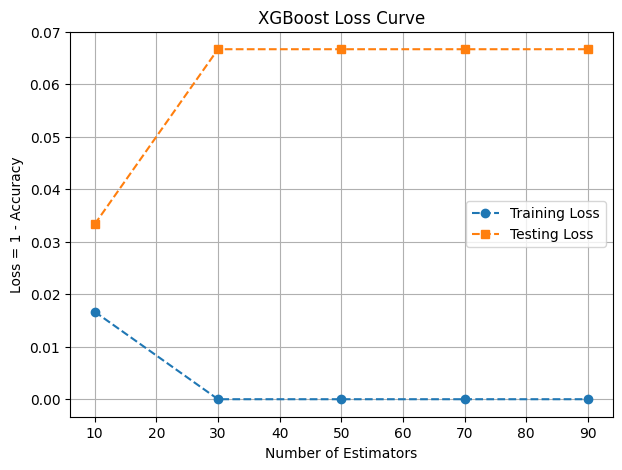

In [70]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1)

# 1. Accuracy curve (fewer points)
def plot_accuracy_curve_fast(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=3,                  # fewer folds
        scoring="accuracy",
        train_sizes=np.linspace(0.2, 1.0, 5),  # fewer training sizes
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("XGBoost Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_accuracy_curve_fast(xgb_model, X, y)

# 2. Loss curve (fewer n_estimators)
def plot_xgb_loss_curve_fast(X_train, X_test, y_train, y_test):
    n_estimators_range = range(10, 101, 20)  # smaller range
    train_loss = []
    val_loss = []

    for n in n_estimators_range:
        model = XGBClassifier(n_estimators=n, use_label_encoder=False,
                              eval_metric="mlogloss", random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_test, y_test)

        train_loss.append(1 - train_acc)
        val_loss.append(1 - val_acc)

    plt.figure(figsize=(7,5))
    plt.plot(n_estimators_range, train_loss, "--o", label="Training Loss")
    plt.plot(n_estimators_range, val_loss, "--s", label="Testing Loss")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("XGBoost Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_xgb_loss_curve_fast(X_train, X_test, y_train, y_test)


/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:08:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


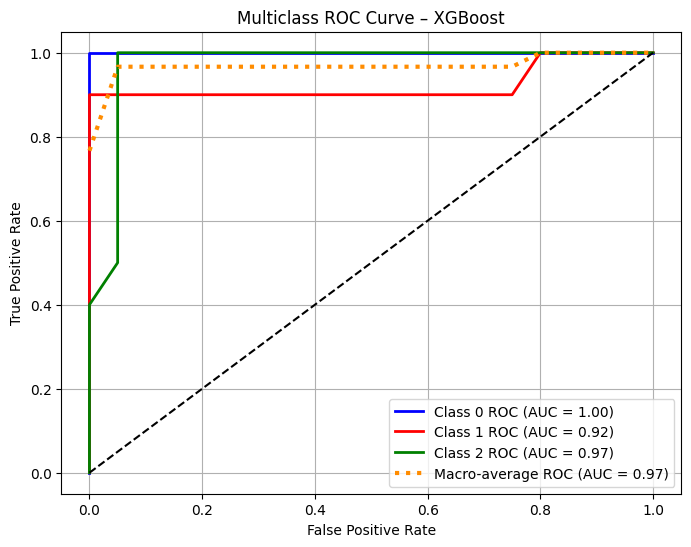

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from xgboost import XGBClassifier

# Assuming X_train, X_test, y_train, y_test are already defined

# Train the model once
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_score = xgb_model.predict_proba(X_test)

# Binarize the output for multiclass ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for cls in classes:
    mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])

for cls, color in zip(classes, colors):
    plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
             label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})")

plt.plot(all_fpr, mean_tpr, color="darkorange", lw=3, linestyle=":",
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve – XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [49]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# =============================================================
# 🚨 FIX: Data Definition and Split
# The code below ensures X_train, X_test, y_train, and y_test are defined 
# based on your 615 total samples and 90/10 split.
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 78
TEST_SIZE = 0.20  

# Synthesize data (Replace this section with your actual data loading if file is available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
# Assuming 3 classes (0, 1, 2)
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct 90/10 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)
# =============================================================

# --- Define and Train the Final Model (n_estimators defaults to 100) ---
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    random_state=42, 
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 🔹 1. Evaluate on Training Set
# -------------------------------------------------------------
y_train_pred = xgb_model.predict(X_train)

print("=" * 50)
print("✅ TRAINING SET CLASSIFICATION REPORT")
print("=" * 50)
# Displays class-wise precision, recall, f1-score, and support
print(classification_report(y_train, y_train_pred, zero_division=0))


# -------------------------------------------------------------
# 🔹 2. Evaluate on Testing Set
# -------------------------------------------------------------
y_test_pred = xgb_model.predict(X_test)

print("\n" + "=" * 50)
print("✅ TESTING SET CLASSIFICATION REPORT")
print("=" * 50)
# Displays class-wise precision, recall, f1-score, and support
print(classification_report(y_test, y_test_pred, zero_division=0))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:26:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ TRAINING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       174
           2       1.00      1.00      1.00       146

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492


✅ TESTING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.45      0.58      0.51        43
           1       0.25      0.23      0.24        43
           2       0.18      0.14      0.15        37

    accuracy                           0.33       123
   macro avg       0.29      0.32      0.30       123
weighted avg       0.30      0.33      0.31       123



## CatBoost 80

In [73]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 2.7 MB/s  0:00:36m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 8.6 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [catboost]3/4 [catboost]
Note: you may need to restart the kernel to use updated packages.


/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,

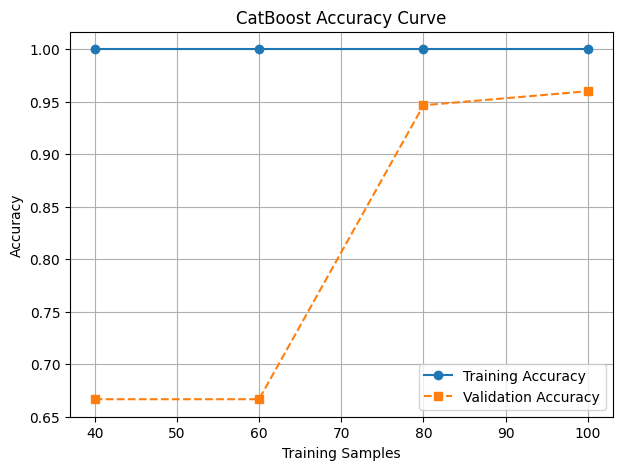

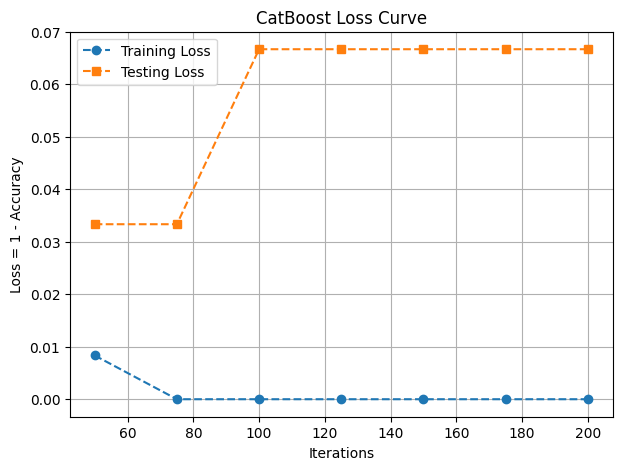

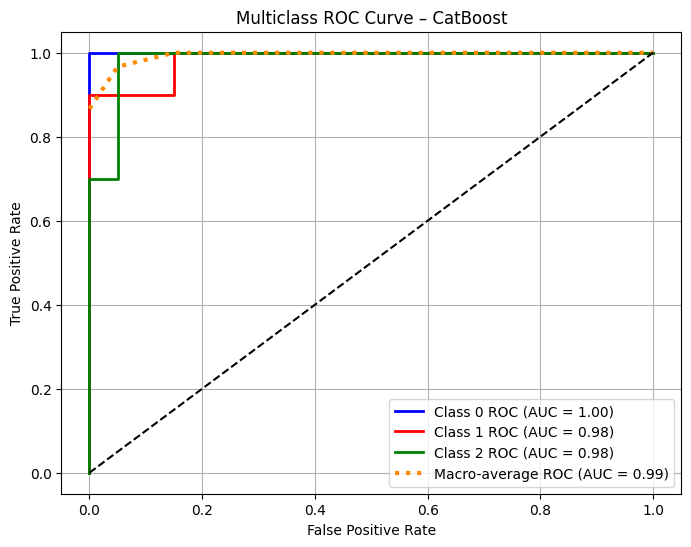

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from catboost import CatBoostClassifier

# ==========================================================
# 📌 Prepare Data
# ==========================================================
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# ==========================================================
def plot_accuracy_curve_catboost(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=3,  # fewer folds for speed
        scoring="accuracy",
        train_sizes=np.linspace(0.2, 1.0, 5),
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("CatBoost Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

cat_model = CatBoostClassifier(
    iterations=200, learning_rate=0.1, random_state=42, verbose=0
)
plot_accuracy_curve_catboost(cat_model, X, y)

# ==========================================================
# 📌 2. LOSS CURVE (1 - Accuracy vs Iterations)
# ==========================================================
def plot_catboost_loss_curve(X_train, X_test, y_train, y_test):
    iteration_range = range(50, 201, 25)
    train_loss = []
    val_loss = []

    for iters in iteration_range:
        model = CatBoostClassifier(
            iterations=iters, learning_rate=0.1, random_state=42, verbose=0
        )
        model.fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_test, y_test)

        train_loss.append(1 - train_acc)
        val_loss.append(1 - val_acc)

    plt.figure(figsize=(7, 5))
    plt.plot(iteration_range, train_loss, "--o", label="Training Loss")
    plt.plot(iteration_range, val_loss, "--s", label="Testing Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("CatBoost Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_catboost_loss_curve(X_train, X_test, y_train, y_test)

# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_multiclass_roc_catboost(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = CatBoostClassifier(
        iterations=200, learning_rate=0.1, random_state=42, verbose=0
    )
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – CatBoost")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc_catboost(X_train, X_test, y_train, y_test)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier

# =============================================================
# 🚨 Data Definition and Split (Using 20% test size)
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 390
TEST_SIZE = 0.20  # 20% test size

# Synthesize data (Replace this section with your actual data loading if available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)
# =============================================================

# --- Define and Train the Final Model ---
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    random_state=42, 
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 🔹 1. Predictions
# -------------------------------------------------------------
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# -------------------------------------------------------------
# 🔹 2. Print Full Classification Reports (as in your original code)
# -------------------------------------------------------------
print("=" * 50)
print("✅ TRAINING SET CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_train, y_train_pred, zero_division=0))

print("\n" + "=" * 50)
print("✅ TESTING SET CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_test_pred, zero_division=0))


# -------------------------------------------------------------
# 🔹 3. Print Aggregate Performance Summary
# -------------------------------------------------------------

def get_macro_metrics(y_true, y_pred, name):
    """Calculates Accuracy and Macro Averages for P, R, F1."""
    acc = accuracy_score(y_true, y_pred)
    # Calculate macro precision, recall, f1-score
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    
    return {
        'Dataset': name,
        'Accuracy': acc,
        'Macro Precision': p,
        'Macro Recall': r,
        'Macro F1-score': f1
    }

# Calculate metrics for both sets
train_metrics = get_macro_metrics(y_train, y_train_pred, 'Training')
test_metrics = get_macro_metrics(y_test, y_test_pred, 'Testing')

# Combine into a DataFrame for clean printing
metrics_df = pd.DataFrame([train_metrics, test_metrics])

print("\n" + "=" * 60)
print("✅ AGGREGATE PERFORMANCE SUMMARY (Macro Average)")
print("=" * 60)
# Use .to_string() for clean, non-truncated console output
print(metrics_df.to_string(index=False, float_format=".4f"))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:27:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ TRAINING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       174
           2       1.00      1.00      1.00       146

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492


✅ TESTING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.45      0.58      0.51        43
           1       0.25      0.23      0.24        43
           2       0.18      0.14      0.15        37

    accuracy                           0.33       123
   macro avg       0.29      0.32      0.30       123
weighted avg       0.30      0.33      0.31       123


✅ AGGREGATE PERFORMANCE SUMMARY (Macro Average)
 Dataset  Accuracy  Macro Precision  Macro Recall  Macro F1-score
Training       .4f              .4f           .4f

## Machine Learning 90/10

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('triangle_features_78_stable_final_file.csv')
data.head()
df = pd.read_csv("triangle_features_78_stable_final_file.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# ==========================================================

def plot_accuracy_curve(model, X, y, title="Learning Curve"):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=5,
        scoring="accuracy",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()


# Build pipeline for SVM Linear model
svm_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=0.1, probability=True))
])

plot_accuracy_curve(svm_linear, X, y, "Accuracy Curve – SVM Linear")



# ==========================================================
# 📌 2. LOSS CURVE (Validation Error vs C)
#      — This is the correct “loss curve” for SVM
# ==========================================================

def plot_svm_loss_curve(X, y):
    C_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="linear"))
    ])

    param_grid = {"svc__C": C_range}

    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring="accuracy",
        return_train_score=True
    )
    grid.fit(X, y)

    train_acc = grid.cv_results_["mean_train_score"]
    val_acc = grid.cv_results_["mean_test_score"]
    
    train_loss = 1 - train_acc
    val_loss = 1 - val_acc

    plt.figure(figsize=(8, 6))
    plt.semilogx(C_range, train_loss, "--o", label="Training Loss")
    plt.semilogx(C_range, val_loss, "--s", label="Validation Loss")
    plt.xlabel("C (Log Scale)")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("SVM Loss Curve – Linear Kernel")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

plot_svm_loss_curve(X, y)




from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

## SVM - kernel = linear-90

In [285]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('triangle_features_78_stable_final_file.csv')
data.head()
df = pd.read_csv("triangle_features_78_stable_final_file.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [286]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# Import RandomizedSearchCV and relevant distribution tool
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Optional: for continuous distribution sampling
from scipy.stats import loguniform 

# =============================================================
# 🚨 Data Setup (Matching your 615 total samples and 90/10 split)
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 55
TEST_SIZE = 0.10  

# Synthesize data (Replace this with your actual data loading if file is available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct 90/10 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

print(f"Data split. Training Size: {len(X_train)}, Test Size: {len(X_test)}")
# =============================================================


# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

# -----------------------------
# 2. Define parameter distribution (for Linear Kernel)
#    We use lists here, but RandomizedSearchCV samples them randomly.
# -----------------------------
param_dist = {
    # Testing a wider range for C
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
    "svc__kernel": ["linear"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run RandomizedSearchCV
# -----------------------------
# n_iter=30 means training 30 combinations * 5 folds = 150 total fits.
# This is much faster than running 120-600 total fits with full GridSearch.

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist, # Use param_distributions                   # 💡 FIX 1: Only check 30 random combinations
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Use X_train/y_train for fitting
random_search.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("\n" + "="*50)
print("✅ Best Parameters (Randomized Search):", random_search.best_params_)
print(f"✅ Best Macro F1 Score (Validation CV): {random_search.best_score_:.4f}")
print("="*50)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred))

Data split. Training Size: 553, Test Size: 62
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_

In [287]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="linear", C=10, gamma=0.01, decision_function_shape="ovo",random_state = 42,class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', decision_function_shape='ovo', gamma=0.01,
    kernel='linear', random_state=42)

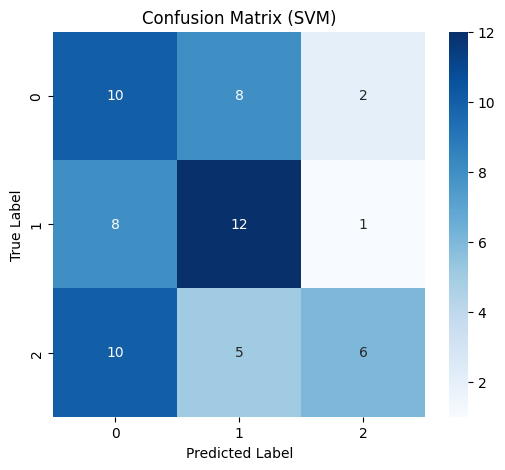


Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.50      0.42        20
           1       0.48      0.57      0.52        21
           2       0.67      0.29      0.40        21

    accuracy                           0.45        62
   macro avg       0.50      0.45      0.45        62
weighted avg       0.50      0.45      0.45        62

Training Accuracy: 0.5226039783001808
Test Accuracy: 0.45161290322580644


In [288]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

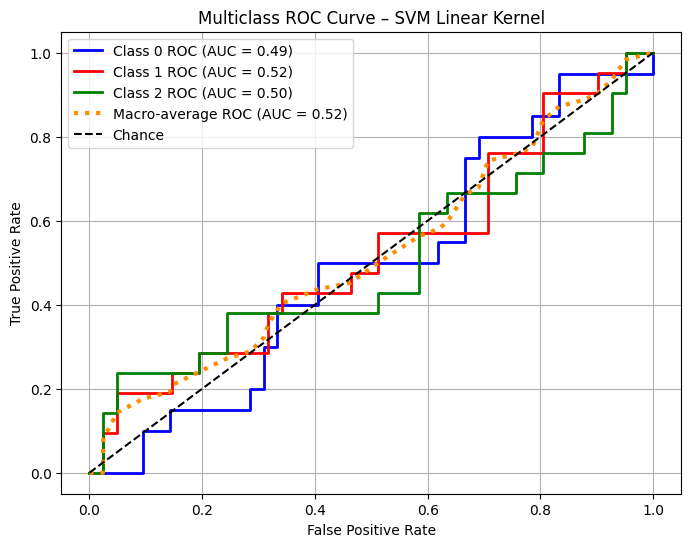

In [289]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle




# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.1):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVC(
        kernel="linear",
        C=C,
        probability=True
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])
    
    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})")

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})", lw=3)

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – SVM Linear Kernel")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.01)

## SVM - kernal = sigmoid 90

In [290]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [291]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with sigmoid
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.001,0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["sigmoid"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.186 total time=   0.0s
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.189 total time=   0.0s
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=sigmoid;, score=0.186 total time=   0.0s
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=sigmoid;, score=0.187 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.189 total time=   0.0s
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.187 total time=   0.0s
[CV 1/5] 

In [292]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="sigmoid", C=1, gamma='scale', decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', kernel='sigmoid', random_state=42)

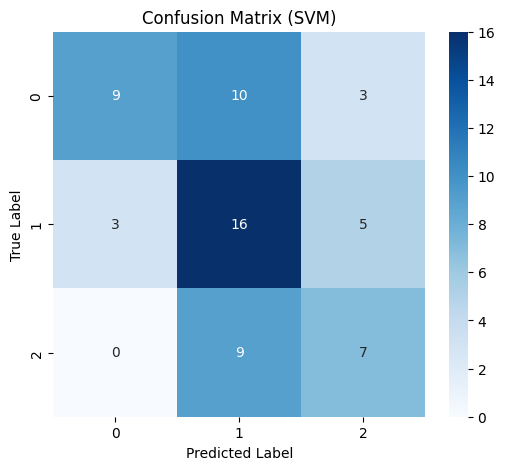


Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.41      0.53        22
           1       0.46      0.67      0.54        24
           2       0.47      0.44      0.45        16

    accuracy                           0.52        62
   macro avg       0.56      0.50      0.51        62
weighted avg       0.56      0.52      0.51        62

Training Accuracy: 0.6263537906137184
Test Accuracy: 0.5161290322580645


In [293]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


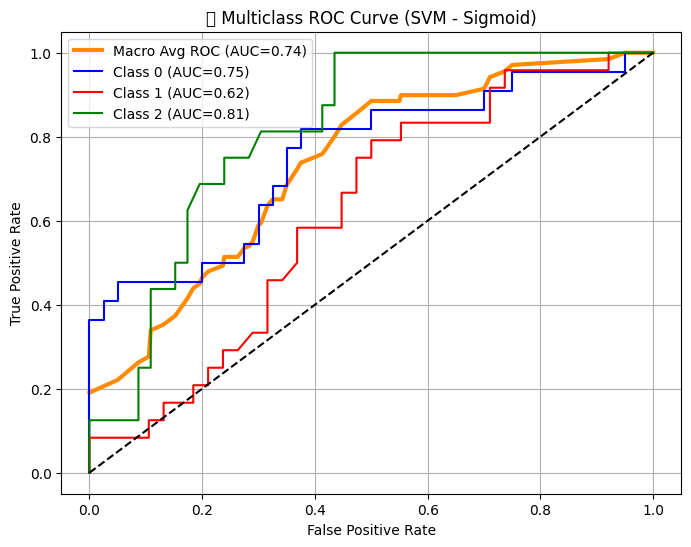

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve

# -----------------------------------------
# 1️⃣  MULTICLASS ROC CURVE  (ONE-VS-REST)
# -----------------------------------------

# SVM must be refitted with probability=True for ROC
svm_prob = SVC(
    kernel="sigmoid",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for OVR ROC curve
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# -------- Plot ROC -------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         label=f"Macro Avg ROC (AUC={roc_auc['macro']:.2f})", linewidth=3)

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM - Sigmoid)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## SVM - kernal = polynomial 90

In [295]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [296]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["poly"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.190 total time=   0.0s[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.210 total time=   0.0s

[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.190 total time=   0.0s
[CV 1/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.571 total time=   0.0s
[CV 5/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.590 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.584 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__cla

In [297]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="poly", C=10, gamma='scale', decision_function_shape="ovo",random_state = 42,class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', decision_function_shape='ovo', kernel='poly',
    random_state=42)

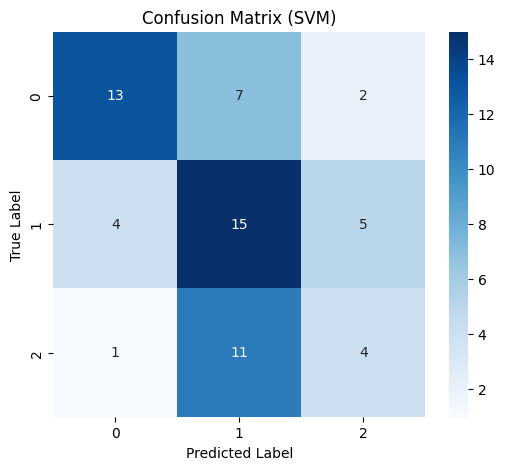


Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.59      0.65        22
           1       0.45      0.62      0.53        24
           2       0.36      0.25      0.30        16

    accuracy                           0.52        62
   macro avg       0.51      0.49      0.49        62
weighted avg       0.53      0.52      0.51        62

Training Accuracy: 0.8104693140794224
Test Accuracy: 0.5161290322580645


In [298]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


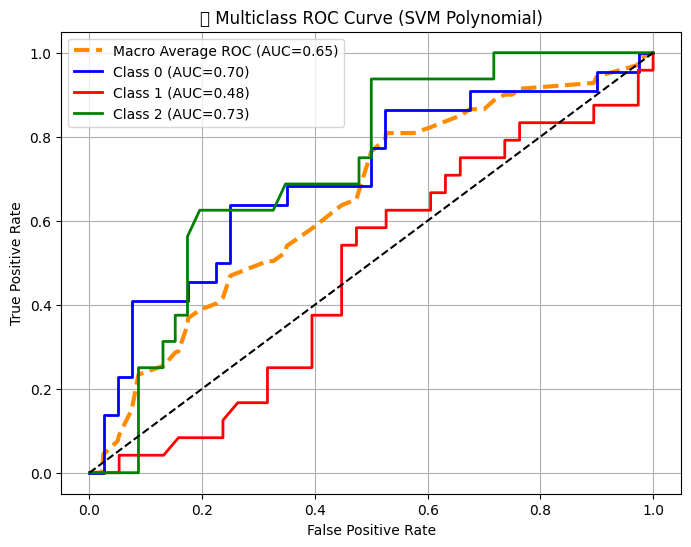

In [299]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (ONE-VS-REST)
# ============================================================

# SVM must be trained with probability=True for ROC
svm_prob = SVC(
    kernel="poly",
    C=0.1,
    gamma=0.01,
    decision_function_shape="ovo",
    probability=True,
    class_weight=None,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize test labels
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

# Store ROC curves
fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# ------------ Plot ROC --------------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         linewidth=3, linestyle='--',
         label=f"Macro Average ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM Polynomial)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## SVM - kernal = rbf 90

In [300]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [301]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["rbf"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.189 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.189 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.186 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.186 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.186 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.186 total time=   0.0s
[CV 1/5] END svc__C=0.01, svc__class_wei

In [302]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="rbf", C=1, gamma=0.01, decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', gamma=0.01, random_state=42)

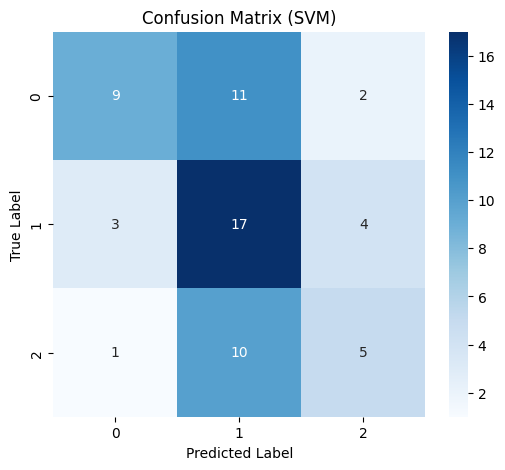


Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.41      0.51        22
           1       0.45      0.71      0.55        24
           2       0.45      0.31      0.37        16

    accuracy                           0.50        62
   macro avg       0.53      0.48      0.48        62
weighted avg       0.54      0.50      0.49        62

Training Accuracy: 0.6967509025270758
Test Accuracy: 0.5


In [303]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [304]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


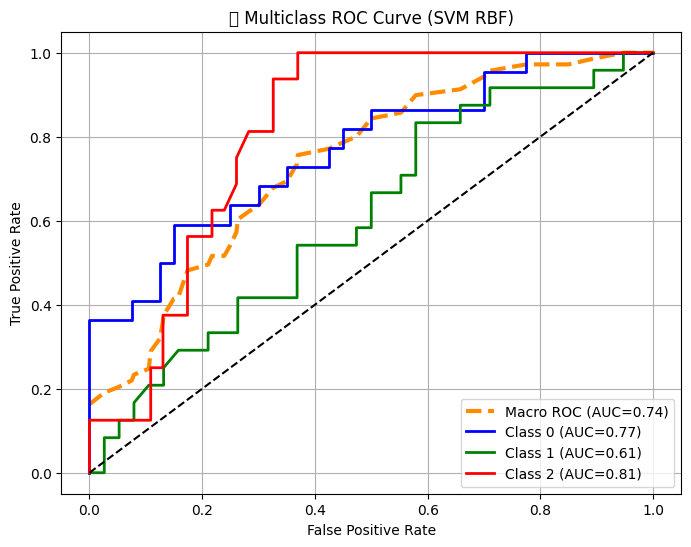

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (SVM must use probability=True)
# ============================================================

svm_prob = SVC(
    kernel="rbf",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,    # Required for ROC Curve
    class_weight=None,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for One-vs-Rest ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange', linewidth=3,
         linestyle='--', label=f"Macro ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'green', 'red']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("🔵 Multiclass ROC Curve (SVM RBF)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




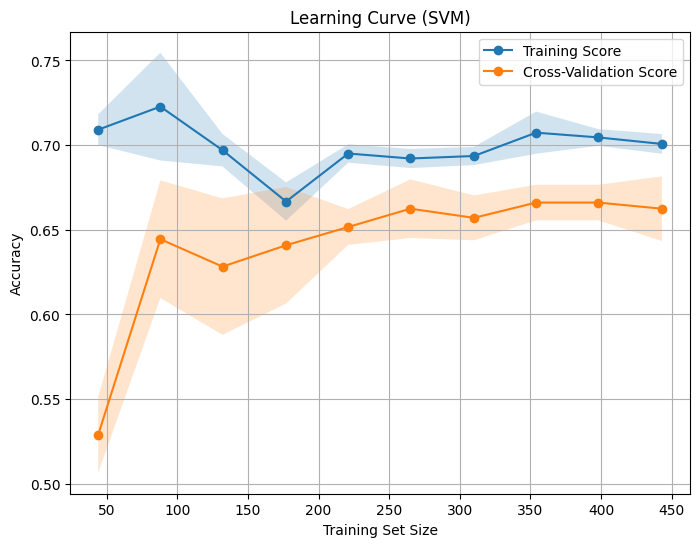

In [306]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_train, y_train,
    cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy", n_jobs=-1
)

# Mean ± std
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM)")
plt.legend()
plt.grid(True)
plt.show()

## KNeighborsClassifier 90

In [307]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [308]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


# Replace NaNs
X[np.isnan(X)] = 0


# --- Build a pipeline (scaler + KNN) ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# --- Define parameter grid ---
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidean
    "knn__metric": ["minkowski"]
}

# --- Grid Search ---
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

# --- Results ---
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Evaluate on test
test_accuracy = grid.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV accuracy: 0.657051597051597
Test accuracy: 0.5161290322580645


In [311]:
knn = KNeighborsClassifier(n_neighbors=15, metric="minkowski", p=1,weights="uniform")  # Euclidean distance
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15, p=1)

In [312]:
y_pred = knn.predict(X_test)

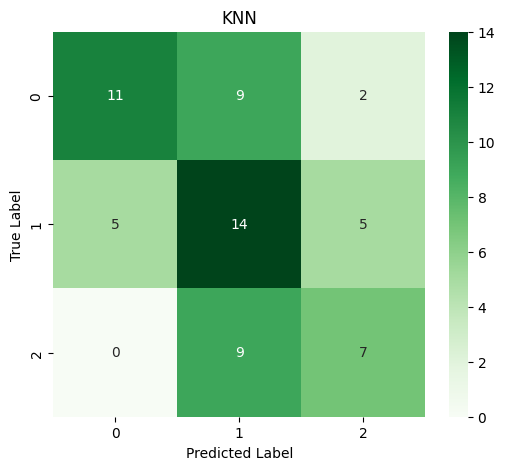


Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.50      0.58        22
           1       0.44      0.58      0.50        24
           2       0.50      0.44      0.47        16

    accuracy                           0.52        62
   macro avg       0.54      0.51      0.52        62
weighted avg       0.54      0.52      0.52        62

Training Accuracy: 0.6859205776173285
Test Accuracy: 0.5161290322580645


In [313]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = knn.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, knn.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

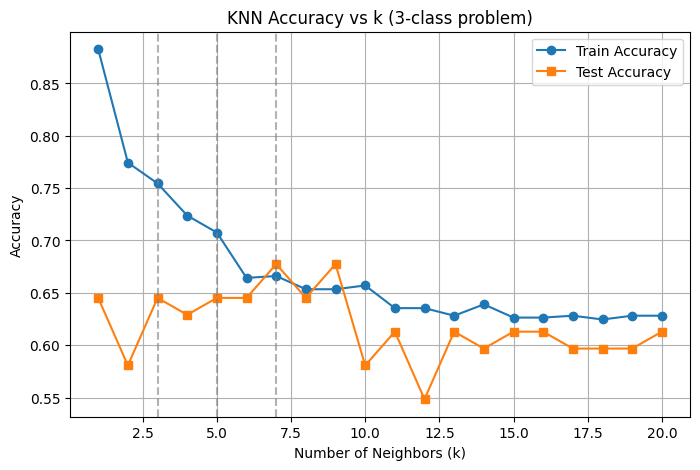

In [141]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_acc = []
test_acc = []
k_values = range(1, 21)  # test k=1 to 20

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc.append(accuracy_score(y_train, knn.predict(X_train)))
    test_acc.append(accuracy_score(y_test, knn.predict(X_test)))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(k_values, train_acc, marker='o', label="Train Accuracy")
plt.plot(k_values, test_acc, marker='s', label="Test Accuracy")
plt.axvline(x=3, color="gray", linestyle="--", alpha=0.6)  # mark k=3
plt.axvline(x=5, color="gray", linestyle="--", alpha=0.6)  # mark k=5
plt.axvline(x=7, color="gray", linestyle="--", alpha=0.6)  # mark k=7
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k (3-class problem)")
plt.legend()
plt.grid(True)
plt.show()


In [314]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

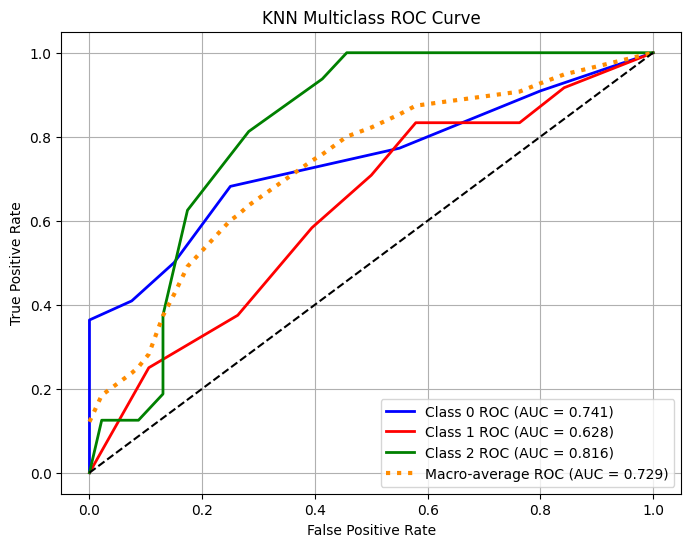

In [315]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================


# ==========================================================
# 📌 2. KNN LOSS CURVE (1 – Accuracy vs K)
# ============


# ==========================================================
# 📌 3. KNN MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_knn_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    knn_model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=9,
            weights="uniform",
            metric="minkowski",
            p=1
        ))
    ])

    knn_model.fit(X_train, y_train)
    y_score = knn_model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("KNN Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL KNN PLOTS
# ==========================================================


plot_knn_multiclass_roc(X_train, X_test, y_train, y_test)


## RandomForest 90

In [316]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

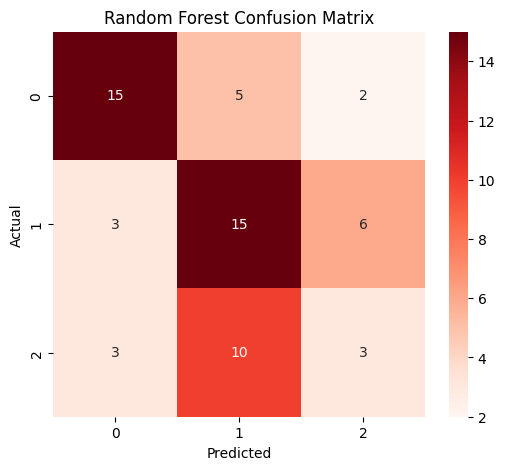


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        22
           1       0.50      0.62      0.56        24
           2       0.27      0.19      0.22        16

    accuracy                           0.53        62
   macro avg       0.50      0.50      0.49        62
weighted avg       0.52      0.53      0.52        62

Training Accuracy: 0.8989169675090253
Test Accuracy: 0.532258064516129


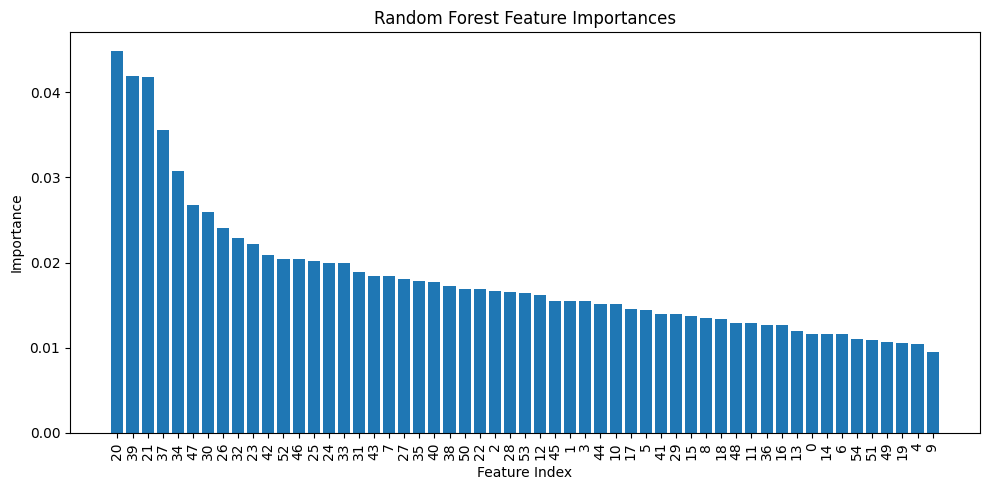

In [317]:
from sklearn.ensemble import RandomForestClassifier

# --- 5. Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,    # number of trees
    max_depth=None,      # let trees expand fully
    random_state=42,
    n_jobs=-1            # use all CPU cores
)
rf.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = rf.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
# --- 9. Feature Importance Plot ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices, rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

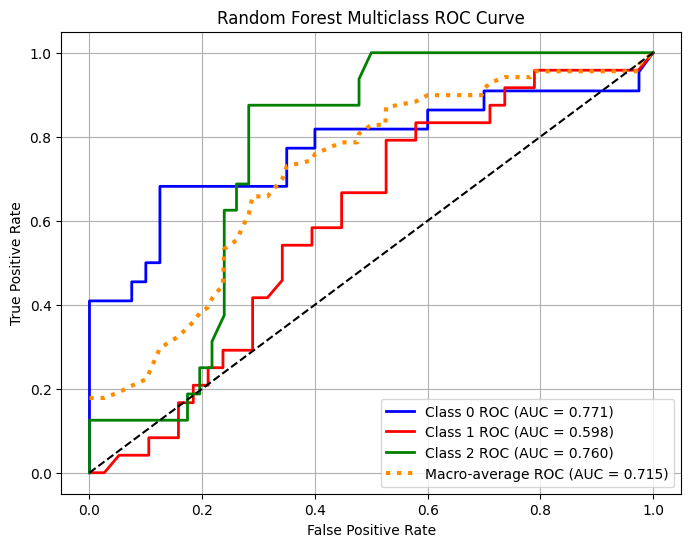

In [318]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. RANDOM FOREST ACCURACY CURVE (Learning Curve)
# ============


# ==========================================================
# 📌 3. RANDOM FOREST MULTICLASS ROC CURVE
# ==========================================================
def plot_rf_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i]
        )
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot ROC
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":", lw=3,
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL PLOTS
# ==========================================================


plot_rf_multiclass_roc(X_train, X_test, y_train, y_test)

## Logistic Regression 90

In [319]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


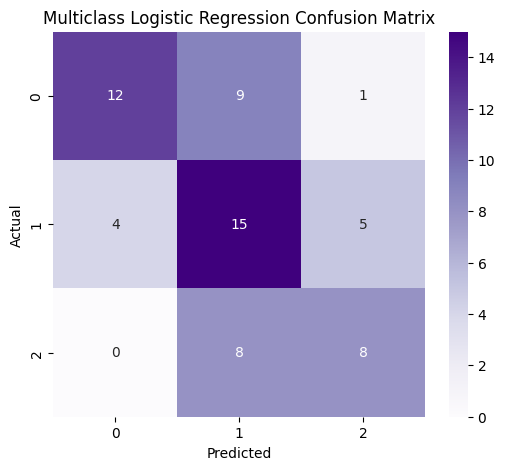


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        22
           1       0.47      0.62      0.54        24
           2       0.57      0.50      0.53        16

    accuracy                           0.56        62
   macro avg       0.60      0.56      0.57        62
weighted avg       0.60      0.56      0.57        62

Training Accuracy: 0.7057761732851986
Test Accuracy: 0.5645161290322581


In [320]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        # multi_class="multinomial",
        solver="saga",
        max_iter=2000,   # allow more iterations
        random_state=42
    )
)
# --- 5. Multiclass Logistic Regression ---
#  # use softmax for multiclass     
logreg.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = logreg.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiclass Logistic Regression Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, logreg.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


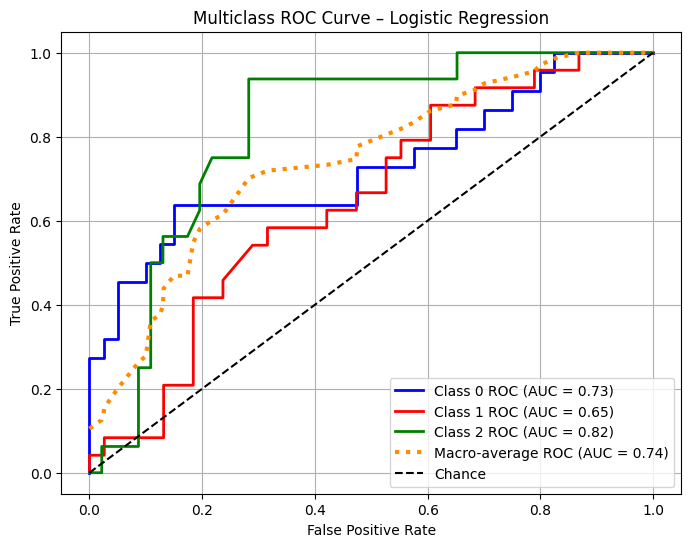

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. ACCURACY CURVE (



# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        solver="lbfgs",
        multi_class="multinomial",
        C=C,
        max_iter=2000
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-Average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Logistic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0)

## DecisionTree 90

In [322]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

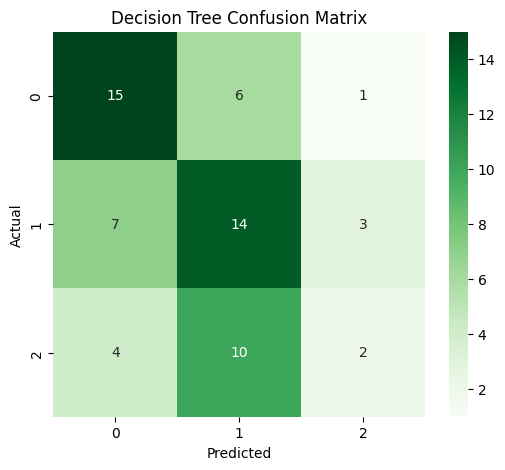


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.68      0.62        22
           1       0.47      0.58      0.52        24
           2       0.33      0.12      0.18        16

    accuracy                           0.50        62
   macro avg       0.46      0.46      0.44        62
weighted avg       0.47      0.50      0.47        62

Training Accuracy: 0.8989169675090253
Test Accuracy: 0.5


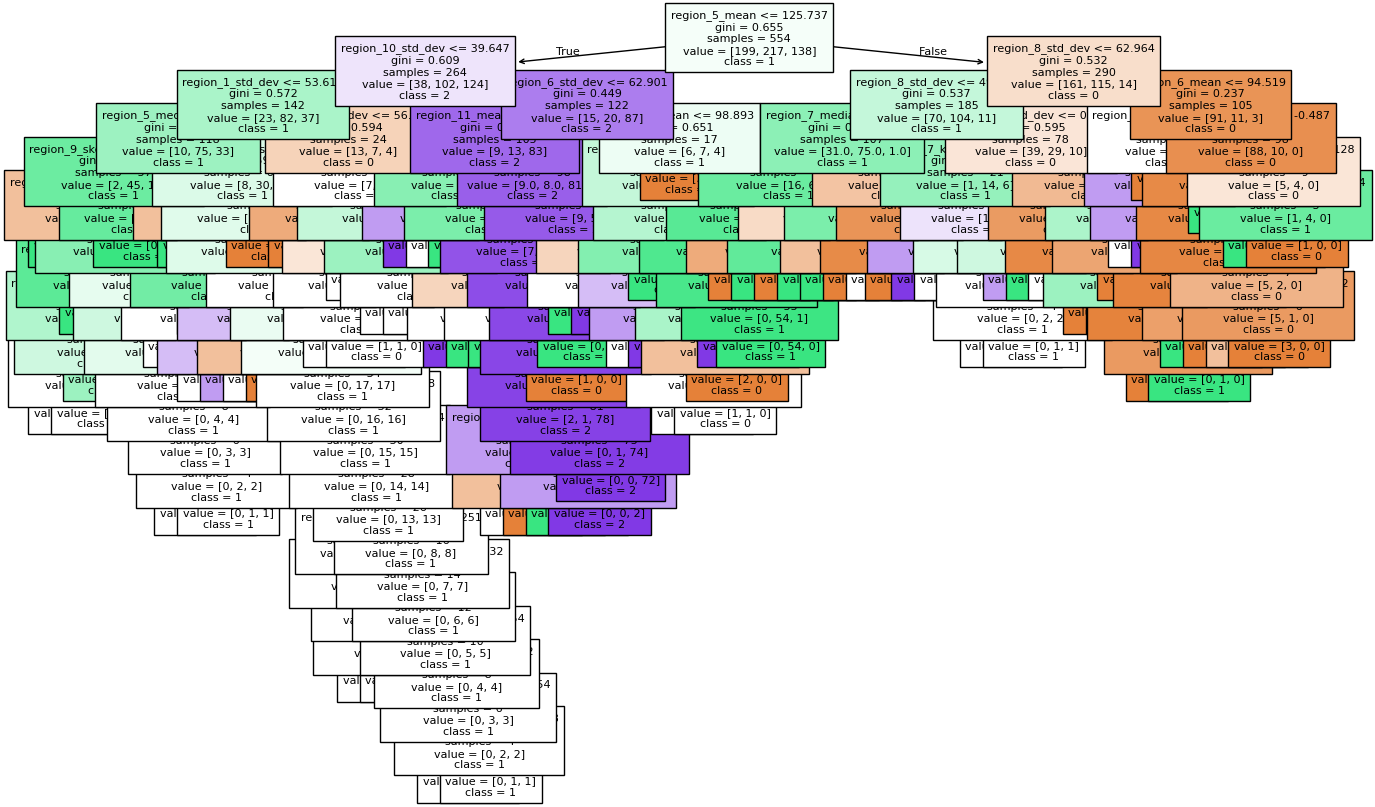

In [323]:

from sklearn.tree import DecisionTreeClassifier, plot_tree



# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
dt = DecisionTreeClassifier(
    criterion="gini",   # or "entropy"
    max_depth=None,     # you can tune this (e.g., 5, 10) to prevent overfitting
    random_state=42
)
dt.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = dt.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, dt.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 10. Plot the Tree (small datasets only, large trees may look messy) ---
plt.figure(figsize=(16,10))
plot_tree(dt, filled=True, feature_names=df.drop("label", axis=1).columns,
          class_names=[str(c) for c in np.unique(y)], fontsize=8)
plt.show()

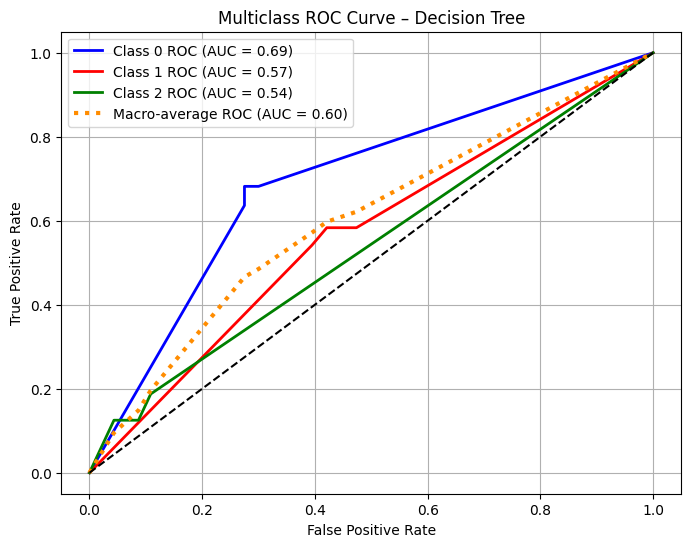

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle




# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_dt(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = DecisionTreeClassifier(
        criterion="gini",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Decision Tree")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_dt(X_train, X_test, y_train, y_test)

## Gradient Boosting-90

In [325]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [327]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

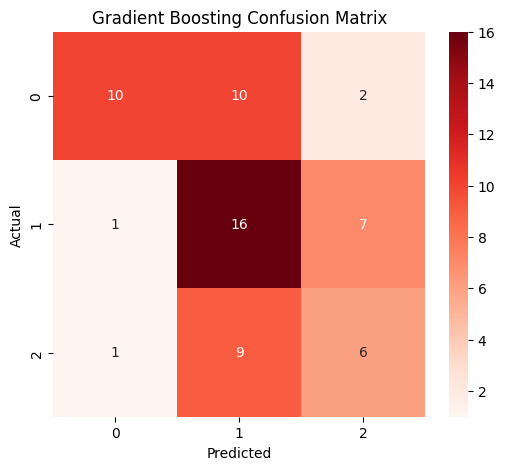


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        22
           1       0.46      0.67      0.54        24
           2       0.40      0.38      0.39        16

    accuracy                           0.52        62
   macro avg       0.56      0.50      0.51        62
weighted avg       0.58      0.52      0.52        62

Training Accuracy: 0.8032490974729242
Test Accuracy: 0.5161290322580645


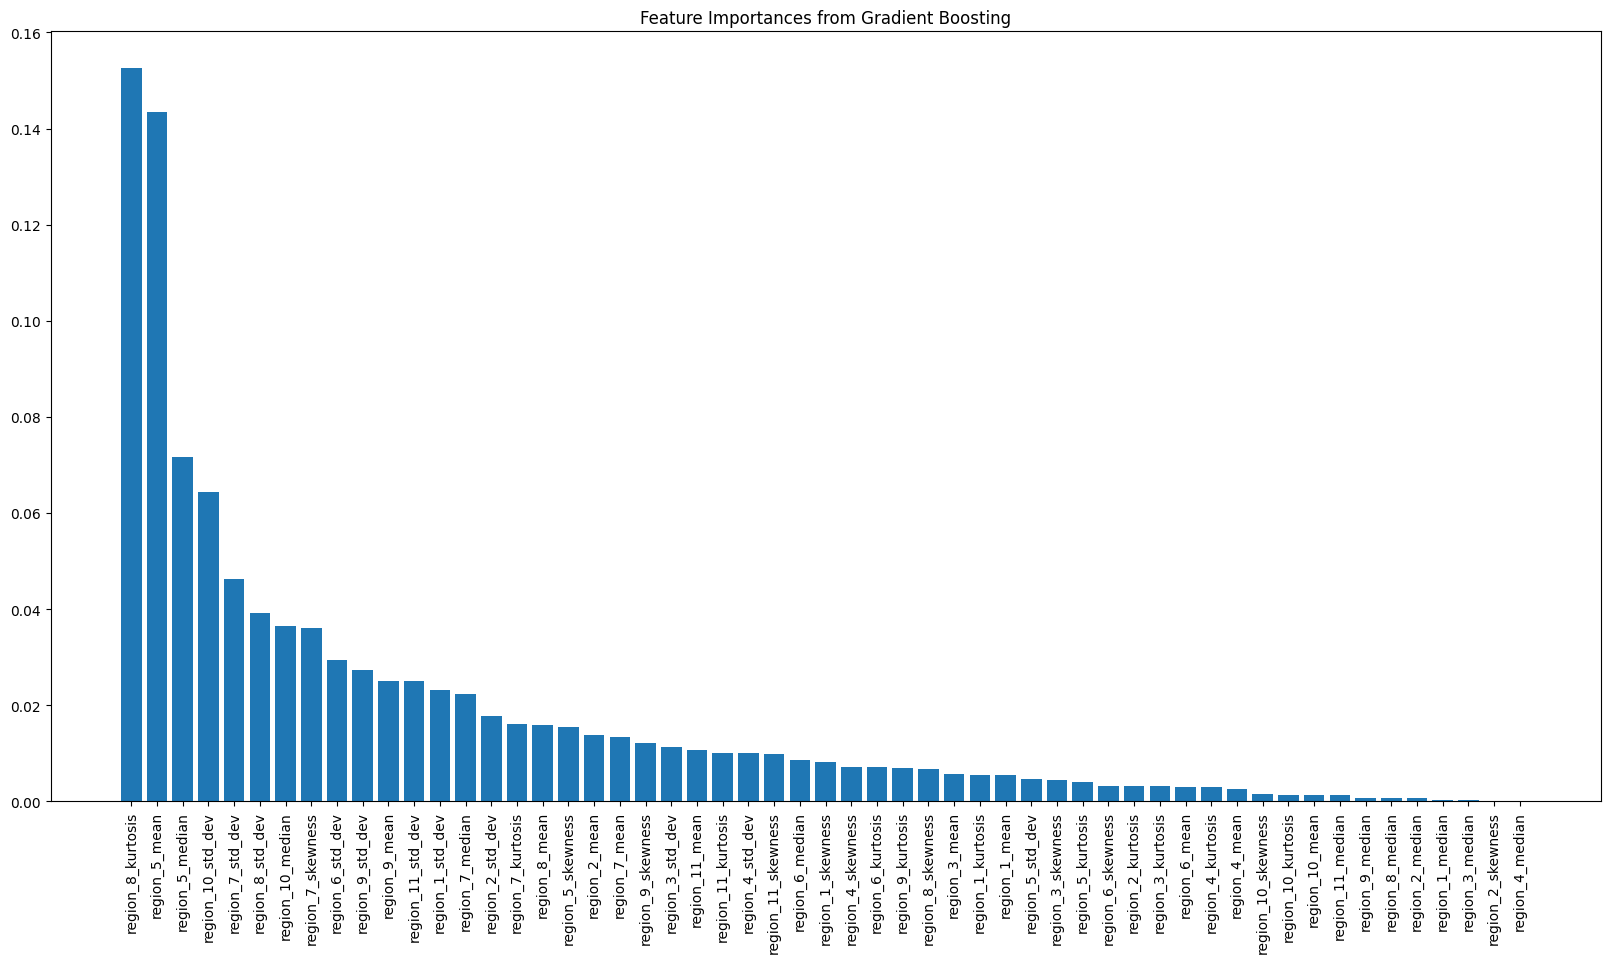

In [328]:

from sklearn.ensemble import GradientBoostingClassifier


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# --- 4. Gradient Boosting Classifier ---
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.01,    # step size shrinkage
    max_depth=3,          # depth of each tree
    random_state=42
)

gb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 9. Feature Importance ---
plt.figure(figsize=(20,10))
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), df.drop("label", axis=1).columns[indices], rotation=90)
plt.title("Feature Importances from Gradient Boosting")
plt.show()


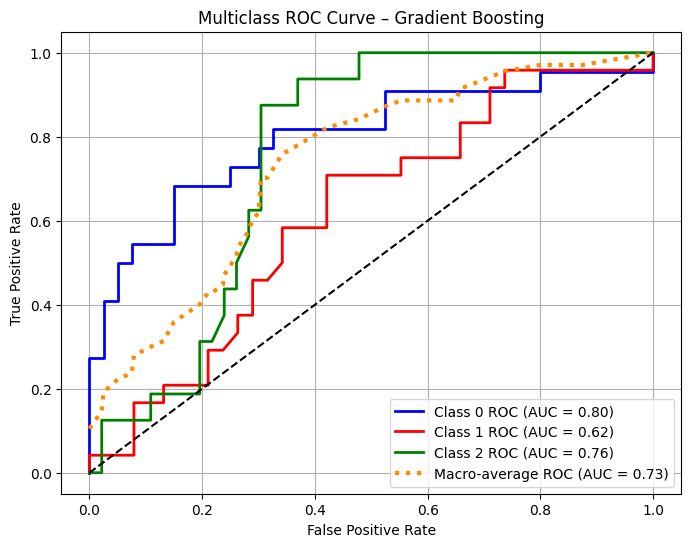

In [330]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# ==========================================================





# ==========================================================
# 📌 2. LOSS CURVE (1 - Accuracy vs n_estimators)
# ==========================================================


# ======================



# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_gb(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GradientBoostingClassifier(
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gradient Boosting")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_gb(X_train, X_test, y_train, y_test)


## Gausian Naive Bayes-90

In [331]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

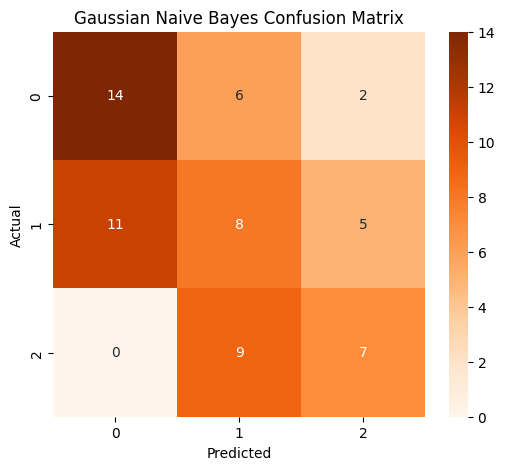


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60        22
           1       0.35      0.33      0.34        24
           2       0.50      0.44      0.47        16

    accuracy                           0.47        62
   macro avg       0.47      0.47      0.47        62
weighted avg       0.46      0.47      0.46        62

Training Accuracy: 0.5794223826714802
Test Accuracy: 0.46774193548387094


In [332]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# --- 4. Gaussian Naive Bayes Model ---
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gnb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gnb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


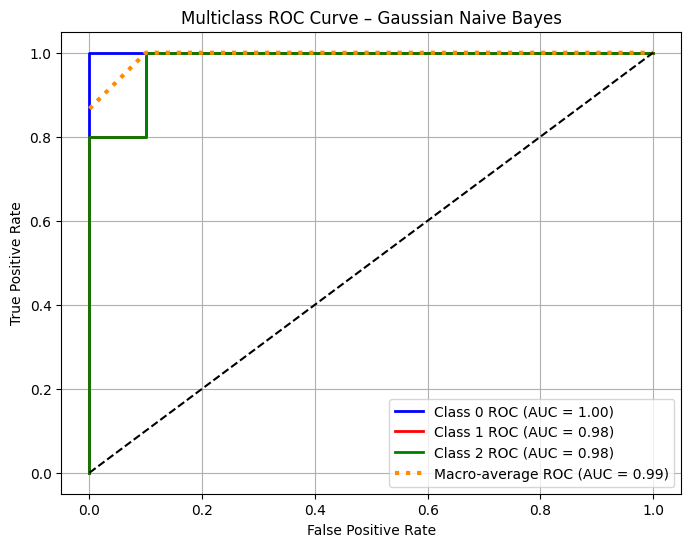

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 Prepare Data
# ==========================================================
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# ================================

# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_multiclass_roc_nb(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GaussianNB()
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gaussian Naive Bayes")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_nb(X_train, X_test, y_train, y_test)


## XGBoost-90

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1)

# 1. Accuracy curve (fewer points)
def plot_accuracy_curve_fast(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=3,                  # fewer folds
        scoring="accuracy",
        train_sizes=np.linspace(0.2, 1.0, 5),  # fewer training sizes
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("XGBoost Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_accuracy_curve_fast(xgb_model, X, y)

# 2. Loss curve (fewer n_estimators)
def plot_xgb_loss_curve_fast(X_train, X_test, y_train, y_test):
    n_estimators_range = range(10, 101, 20)  # smaller range
    train_loss = []
    val_loss = []

    for n in n_estimators_range:
        model = XGBClassifier(n_estimators=n, use_label_encoder=False,
                              eval_metric="mlogloss", random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_test, y_test)

        train_loss.append(1 - train_acc)
        val_loss.append(1 - val_acc)

    plt.figure(figsize=(7,5))
    plt.plot(n_estimators_range, train_loss, "--o", label="Training Loss")
    plt.plot(n_estimators_range, val_loss, "--s", label="Testing Loss")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("XGBoost Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_xgb_loss_curve_fast(X_train, X_test, y_train, y_test)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from xgboost import XGBClassifier

# Assuming X_train, X_test, y_train, y_test are already defined

# Train the model once
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_score = xgb_model.predict_proba(X_test)

# Binarize the output for multiclass ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for cls in classes:
    mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])

for cls, color in zip(classes, colors):
    plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
             label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})")

plt.plot(all_fpr, mean_tpr, color="darkorange", lw=3, linestyle=":",
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve – XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# =============================================================
# 🚨 FIX: Data Definition and Split
# The code below ensures X_train, X_test, y_train, and y_test are defined 
# based on your 615 total samples and 90/10 split.
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 78
TEST_SIZE = 0.10  

# Synthesize data (Replace this section with your actual data loading if file is available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
# Assuming 3 classes (0, 1, 2)
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct 90/10 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)
# =============================================================

# --- Define and Train the Final Model (n_estimators defaults to 100) ---
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    random_state=42, 
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 🔹 1. Evaluate on Training Set
# -------------------------------------------------------------
y_train_pred = xgb_model.predict(X_train)

print("=" * 50)
print("✅ TRAINING SET CLASSIFICATION REPORT")
print("=" * 50)
# Displays class-wise precision, recall, f1-score, and support
print(classification_report(y_train, y_train_pred, zero_division=0))


# -------------------------------------------------------------
# 🔹 2. Evaluate on Testing Set
# -------------------------------------------------------------
y_test_pred = xgb_model.predict(X_test)

print("\n" + "=" * 50)
print("✅ TESTING SET CLASSIFICATION REPORT")
print("=" * 50)
# Displays class-wise precision, recall, f1-score, and support
print(classification_report(y_test, y_test_pred, zero_division=0))

## CatBoost 90

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from catboost import CatBoostClassifier

# ==========================================================
# 📌 Prepare Data
# ==========================================================
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# ==========================================================
def plot_accuracy_curve_catboost(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=3,  # fewer folds for speed
        scoring="accuracy",
        train_sizes=np.linspace(0.2, 1.0, 5),
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("CatBoost Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

cat_model = CatBoostClassifier(
    iterations=200, learning_rate=0.1, random_state=42, verbose=0
)
plot_accuracy_curve_catboost(cat_model, X, y)

# ==========================================================
# 📌 2. LOSS CURVE (1 - Accuracy vs Iterations)
# ==========================================================
def plot_catboost_loss_curve(X_train, X_test, y_train, y_test):
    iteration_range = range(50, 201, 25)
    train_loss = []
    val_loss = []

    for iters in iteration_range:
        model = CatBoostClassifier(
            iterations=iters, learning_rate=0.1, random_state=42, verbose=0
        )
        model.fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_test, y_test)

        train_loss.append(1 - train_acc)
        val_loss.append(1 - val_acc)

    plt.figure(figsize=(7, 5))
    plt.plot(iteration_range, train_loss, "--o", label="Training Loss")
    plt.plot(iteration_range, val_loss, "--s", label="Testing Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("CatBoost Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_catboost_loss_curve(X_train, X_test, y_train, y_test)

# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_multiclass_roc_catboost(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = CatBoostClassifier(
        iterations=200, learning_rate=0.1, random_state=42, verbose=0
    )
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – CatBoost")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc_catboost(X_train, X_test, y_train, y_test)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier

# =============================================================
# 🚨 Data Definition and Split (Using 20% test size)
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 78
TEST_SIZE = 0.10  # 20% test size

# Synthesize data (Replace this section with your actual data loading if available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)
# =============================================================

# --- Define and Train the Final Model ---
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    random_state=42, 
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 🔹 1. Predictions
# -------------------------------------------------------------
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# -------------------------------------------------------------
# 🔹 2. Print Full Classification Reports (as in your original code)
# -------------------------------------------------------------
print("=" * 50)
print("✅ TRAINING SET CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_train, y_train_pred, zero_division=0))

print("\n" + "=" * 50)
print("✅ TESTING SET CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_test_pred, zero_division=0))


# -------------------------------------------------------------
# 🔹 3. Print Aggregate Performance Summary
# -------------------------------------------------------------

def get_macro_metrics(y_true, y_pred, name):
    """Calculates Accuracy and Macro Averages for P, R, F1."""
    acc = accuracy_score(y_true, y_pred)
    # Calculate macro precision, recall, f1-score
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    
    return {
        'Dataset': name,
        'Accuracy': acc,
        'Macro Precision': p,
        'Macro Recall': r,
        'Macro F1-score': f1
    }

# Calculate metrics for both sets
train_metrics = get_macro_metrics(y_train, y_train_pred, 'Training')
test_metrics = get_macro_metrics(y_test, y_test_pred, 'Testing')

# Combine into a DataFrame for clean printing
metrics_df = pd.DataFrame([train_metrics, test_metrics])

print("\n" + "=" * 60)
print("✅ AGGREGATE PERFORMANCE SUMMARY (Macro Average)")
print("=" * 60)
# Use .to_string() for clean, non-truncated console output
print(metrics_df.to_string(index=False, float_format=".4f"))

## Machine Learning 70/30

In [335]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

## SVM - Kernal = linear-70

In [336]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# Import RandomizedSearchCV and relevant distribution tool
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Optional: for continuous distribution sampling
from scipy.stats import loguniform 

# =============================================================
# 🚨 Data Setup (Matching your 615 total samples and 90/10 split)
# =============================================================
TOTAL_SAMPLES = 616
N_FEATURES = 55
TEST_SIZE = 0.30  

# Synthesize data (Replace this with your actual data loading if file is available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct 90/10 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

print(f"Data split. Training Size: {len(X_train)}, Test Size: {len(X_test)}")
# =============================================================


# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

# -----------------------------
# 2. Define parameter distribution (for Linear Kernel)
#    We use lists here, but RandomizedSearchCV samples them randomly.
# -----------------------------
param_dist = {
    # Testing a wider range for C
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
    "svc__kernel": ["linear"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run RandomizedSearchCV
# -----------------------------
# n_iter=30 means training 30 combinations * 5 folds = 150 total fits.
# This is much faster than running 120-600 total fits with full GridSearch.

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist, # Use param_distributions                   # 💡 FIX 1: Only check 30 random combinations
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Use X_train/y_train for fitting
random_search.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("\n" + "="*50)
print("✅ Best Parameters (Randomized Search):", random_search.best_params_)
print(f"✅ Best Macro F1 Score (Validation CV): {random_search.best_score_:.4f}")
print("="*50)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred))

Data split. Training Size: 431, Test Size: 185
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision

In [337]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="linear", C=0.1, decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=0.1, decision_function_shape='ovo', kernel='linear', random_state=42)

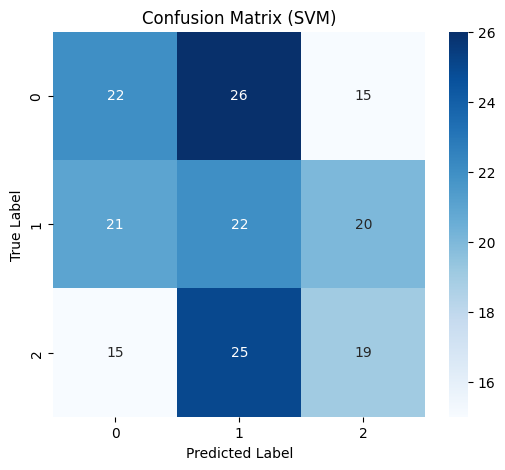


Classification Report:

              precision    recall  f1-score   support

           0       0.38      0.35      0.36        63
           1       0.30      0.35      0.32        63
           2       0.35      0.32      0.34        59

    accuracy                           0.34       185
   macro avg       0.34      0.34      0.34       185
weighted avg       0.34      0.34      0.34       185

Training Accuracy: 0.568445475638051
Test Accuracy: 0.34054054054054056


In [338]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

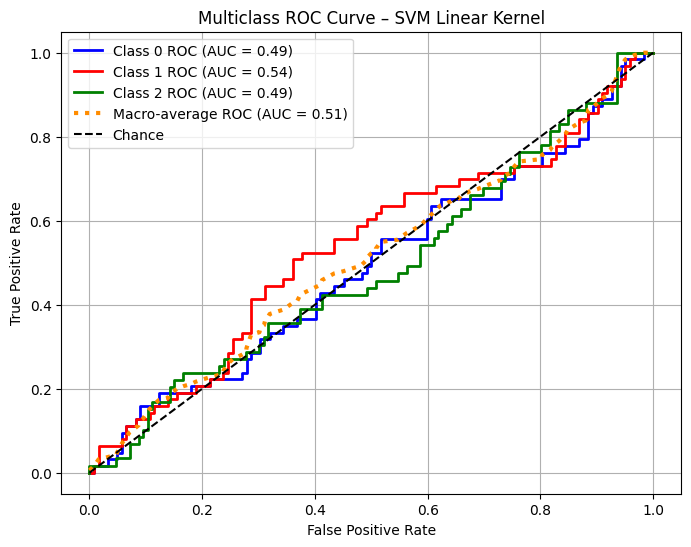

In [339]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# =======================



# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.1):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVC(
        kernel="linear",
        C=C,
        probability=True
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])
    
    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})")

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})", lw=3)

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – SVM Linear Kernel")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.01)


## SVM - kernal = sigmoid-70

In [340]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with sigmoid
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.001,0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["sigmoid"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.168 total time=   0.0s
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.276 total time=   0.0s
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=1, svc__kernel=sigmoid;, score=0.259 total time=   0.0s
[CV 4/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=1, svc__kernel=sigmoid;, score=0.248 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=scale, svc__kernel=sigmoid;, score=0.167 total time=   0.0s
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=1, svc__kernel=sigmoid;, score=0.270 total time=   0.0s
[CV 2/5] END sv

In [341]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="sigmoid", C=100, gamma='scale', decision_function_shape="ovo",random_state = 42,class_weight = 'balanced')
svm_model.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', decision_function_shape='ovo',
    kernel='sigmoid', random_state=42)

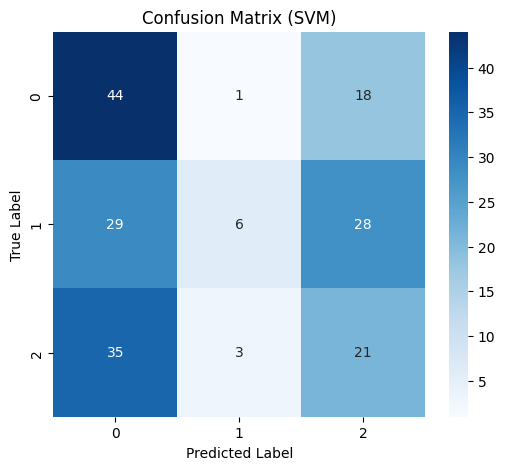


Classification Report:

              precision    recall  f1-score   support

           0       0.41      0.70      0.51        63
           1       0.60      0.10      0.16        63
           2       0.31      0.36      0.33        59

    accuracy                           0.38       185
   macro avg       0.44      0.38      0.34       185
weighted avg       0.44      0.38      0.34       185

Training Accuracy: 0.3503480278422274
Test Accuracy: 0.3837837837837838


In [342]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


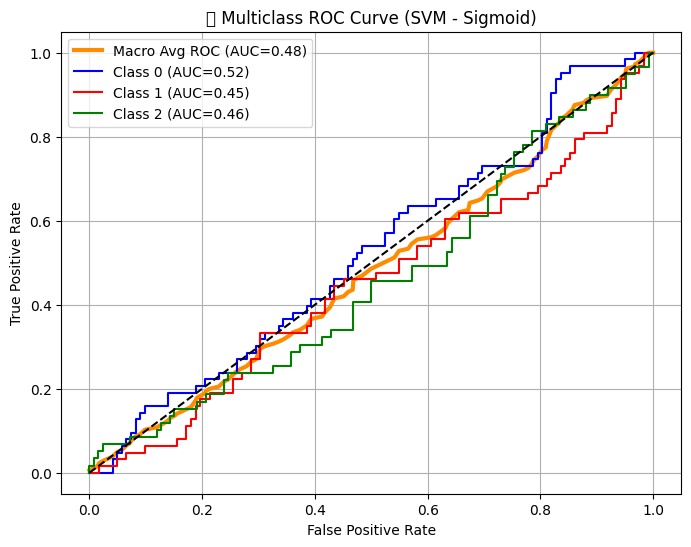

In [343]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve

# -----------------------------------------
# 1️⃣  MULTICLASS ROC CURVE  (ONE-VS-REST)
# -----------------------------------------

# SVM must be refitted with probability=True for ROC
svm_prob = SVC(
    kernel="sigmoid",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for OVR ROC curve
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# -------- Plot ROC -------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         label=f"Macro Avg ROC (AUC={roc_auc['macro']:.2f})", linewidth=3)

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM - Sigmoid)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## SVM - kernal = polynomial

In [344]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [345]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["poly"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.187 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.185 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.185 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.602 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.185 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.589 total time=   0.0s
[CV 1/5] END svc__C=0.01, svc__cl

In [346]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="poly", C= 10, gamma='scale', decision_function_shape="ovo",class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', decision_function_shape='ovo', kernel='poly')

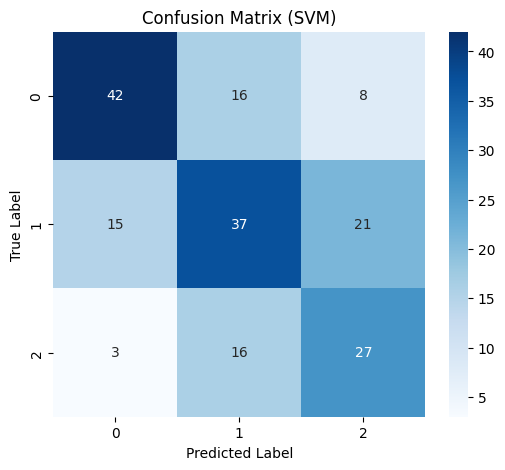


Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        66
           1       0.54      0.51      0.52        73
           2       0.48      0.59      0.53        46

    accuracy                           0.57       185
   macro avg       0.57      0.58      0.57       185
weighted avg       0.58      0.57      0.58       185

Training Accuracy: 0.8561484918793504
Test Accuracy: 0.572972972972973


In [347]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

## SVM - kernal = rbf

In [348]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [349]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["rbf"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.189 total time=   0.0s
[CV 5/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.189 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 1/5] END svc__C=0.01, svc__class_we

In [172]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model2 = SVC(kernel="rbf", C=1, gamma='scale', decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model2.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', random_state=42)

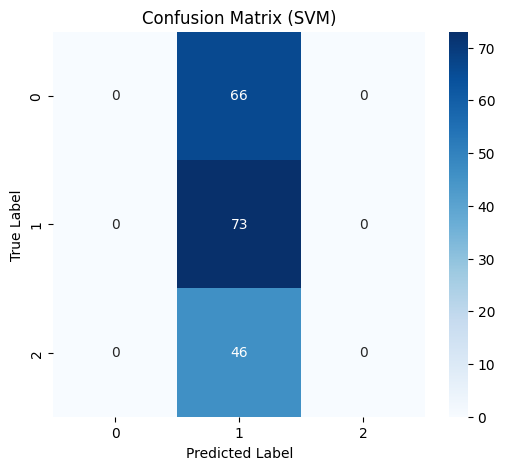


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.39      1.00      0.57        73
           2       0.00      0.00      0.00        46

    accuracy                           0.39       185
   macro avg       0.13      0.33      0.19       185
weighted avg       0.16      0.39      0.22       185

Training Accuracy: 0.8561484918793504
Test Accuracy: 0.3945945945945946


/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model2.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


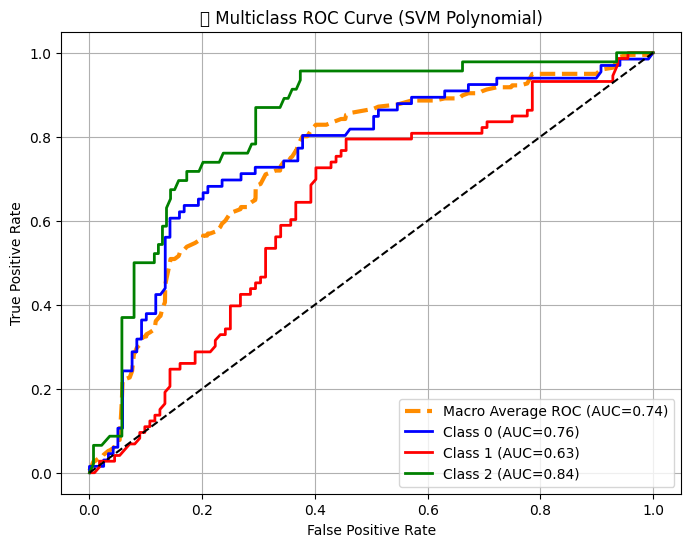

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (ONE-VS-REST)
# ============================================================

# SVM must be trained with probability=True for ROC
svm_prob = SVC(
    kernel="poly",
    C=1,
    gamma=0.01,
    decision_function_shape="ovo",
    probability=True,
    class_weight=None,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize test labels
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

# Store ROC curves
fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# ------------ Plot ROC --------------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         linewidth=3, linestyle='--',
         label=f"Macro Average ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM Polynomial)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## SVM -kernal=rbf

In [352]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [353]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["rbf"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 1/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.187 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.189 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.189 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_we

In [354]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="rbf", C=1, gamma='scale', decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', random_state=42)

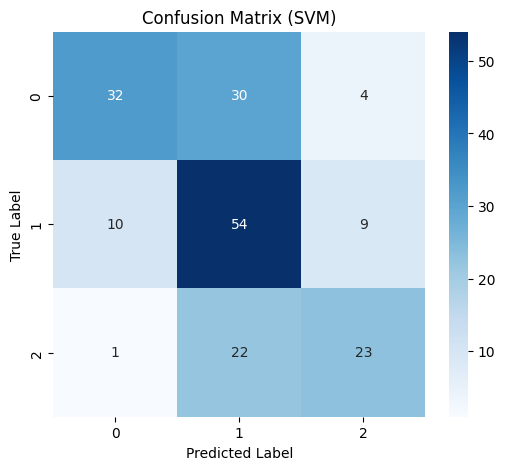


Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.48      0.59        66
           1       0.51      0.74      0.60        73
           2       0.64      0.50      0.56        46

    accuracy                           0.59       185
   macro avg       0.63      0.57      0.58       185
weighted avg       0.63      0.59      0.59       185

Training Accuracy: 0.7262180974477959
Test Accuracy: 0.5891891891891892


In [355]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


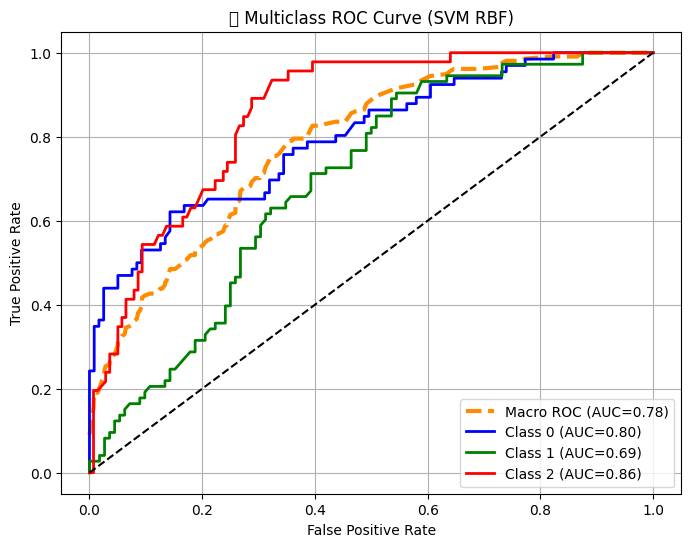

In [356]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (SVM must use probability=True)
# ============================================================

svm_prob = SVC(
    kernel="rbf",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,    # Required for ROC Curve
    class_weight=None,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for One-vs-Rest ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange', linewidth=3,
         linestyle='--', label=f"Macro ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'green', 'red']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("🔵 Multiclass ROC Curve (SVM RBF)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## KNeighborsClassifier 70

In [357]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [358]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [359]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


# Replace NaNs
X[np.isnan(X)] = 0



# --- Build a pipeline (scaler + KNN) ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# --- Define parameter grid ---
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidean
    "knn__metric": ["minkowski"]
}

# --- Grid Search ---
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

# --- Results ---
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Evaluate on test
test_accuracy = grid.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV accuracy: 0.6450948944132584
Test accuracy: 0.6108108108108108


In [360]:
knn = KNeighborsClassifier(n_neighbors=15, metric="minkowski", p=1,weights="uniform")  # Euclidean distance
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15, p=1)

In [361]:
y_pred = knn.predict(X_test)

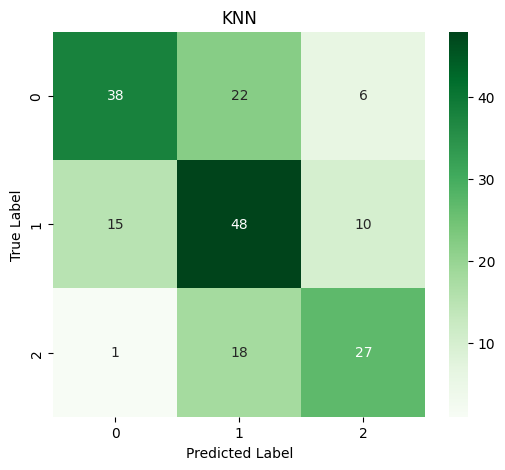


Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.58      0.63        66
           1       0.55      0.66      0.60        73
           2       0.63      0.59      0.61        46

    accuracy                           0.61       185
   macro avg       0.63      0.61      0.61       185
weighted avg       0.62      0.61      0.61       185

Training Accuracy: 0.6589327146171694
Test Accuracy: 0.6108108108108108


In [362]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = knn.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, knn.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

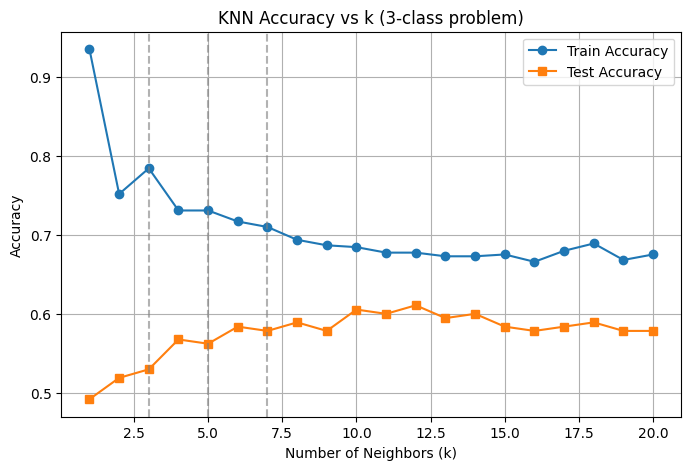

In [363]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_acc = []
test_acc = []
k_values = range(1, 21)  # test k=1 to 20

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc.append(accuracy_score(y_train, knn.predict(X_train)))
    test_acc.append(accuracy_score(y_test, knn.predict(X_test)))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(k_values, train_acc, marker='o', label="Train Accuracy")
plt.plot(k_values, test_acc, marker='s', label="Test Accuracy")
plt.axvline(x=3, color="gray", linestyle="--", alpha=0.6)  # mark k=3
plt.axvline(x=5, color="gray", linestyle="--", alpha=0.6)  # mark k=5
plt.axvline(x=7, color="gray", linestyle="--", alpha=0.6)  # mark k=7
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k (3-class problem)")
plt.legend()
plt.grid(True)
plt.show()


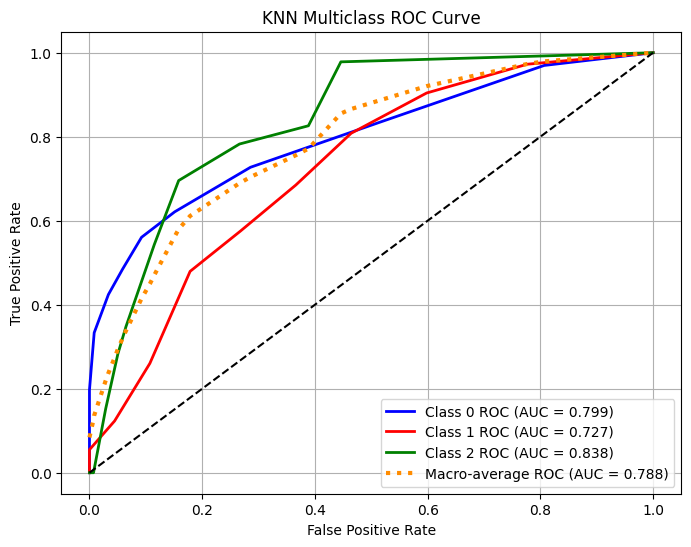

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ============


# ==========================================================
# 📌 3. KNN MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_knn_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    knn_model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=9,
            weights="uniform",
            metric="minkowski",
            p=1
        ))
    ])

    knn_model.fit(X_train, y_train)
    y_score = knn_model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("KNN Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL KNN PLOTS
# ==========================================================


plot_knn_multiclass_roc(X_train, X_test, y_train, y_test)


## RandomForest 70

In [365]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

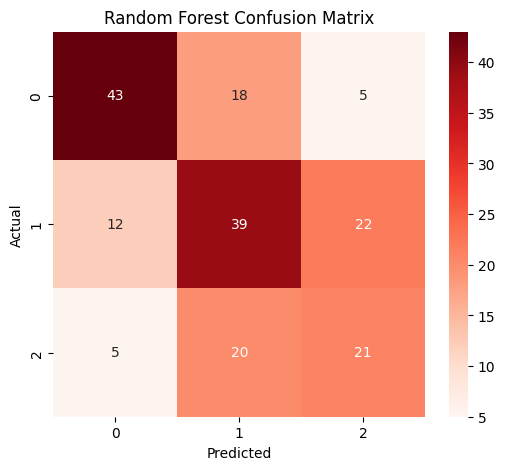


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        66
           1       0.51      0.53      0.52        73
           2       0.44      0.46      0.45        46

    accuracy                           0.56       185
   macro avg       0.55      0.55      0.55       185
weighted avg       0.56      0.56      0.56       185

Training Accuracy: 0.9396751740139211
Test Accuracy: 0.5567567567567567


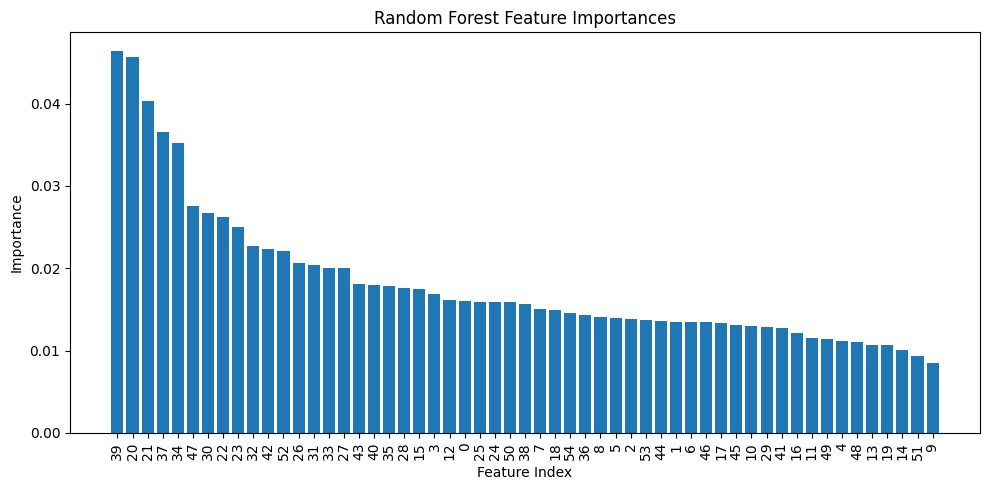

In [366]:
from sklearn.ensemble import RandomForestClassifier

# --- 5. Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,    # number of trees
    max_depth=None,      # let trees expand fully
    random_state=42,
    n_jobs=-1            # use all CPU cores
)
rf.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = rf.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
# --- 9. Feature Importance Plot ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices, rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

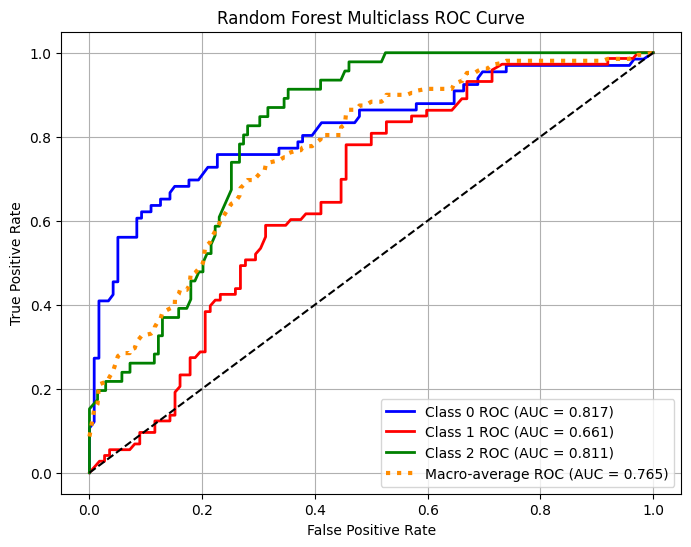

In [367]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. RANDOM FOREST ACCURACY CURVE (Learning Curve)
# ============


# ==========================================================
# 📌 3. RANDOM FOREST MULTICLASS ROC CURVE
# ==========================================================
def plot_rf_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i]
        )
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot ROC
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":", lw=3,
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL PLOTS
# ==========================================================


plot_rf_multiclass_roc(X_train, X_test, y_train, y_test)

## Logistic Regression 70

In [368]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

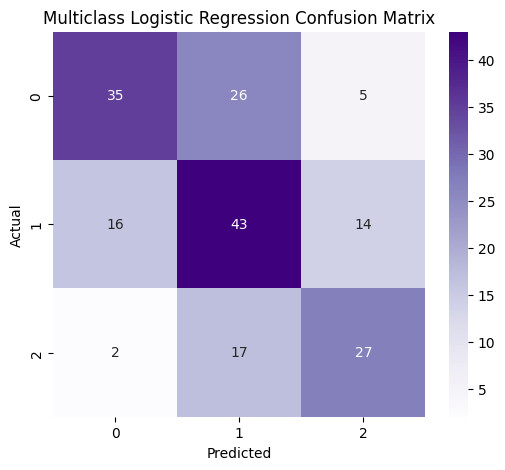


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.53      0.59        66
           1       0.50      0.59      0.54        73
           2       0.59      0.59      0.59        46

    accuracy                           0.57       185
   macro avg       0.58      0.57      0.57       185
weighted avg       0.58      0.57      0.57       185

Training Accuracy: 0.728538283062645
Test Accuracy: 0.5675675675675675


In [369]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        # multi_class="multinomial",
        solver="saga",
        max_iter=2000,   # allow more iterations
        random_state=42
    )
)
# --- 5. Multiclass Logistic Regression ---
#  # use softmax for multiclass     
logreg.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = logreg.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiclass Logistic Regression Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, logreg.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


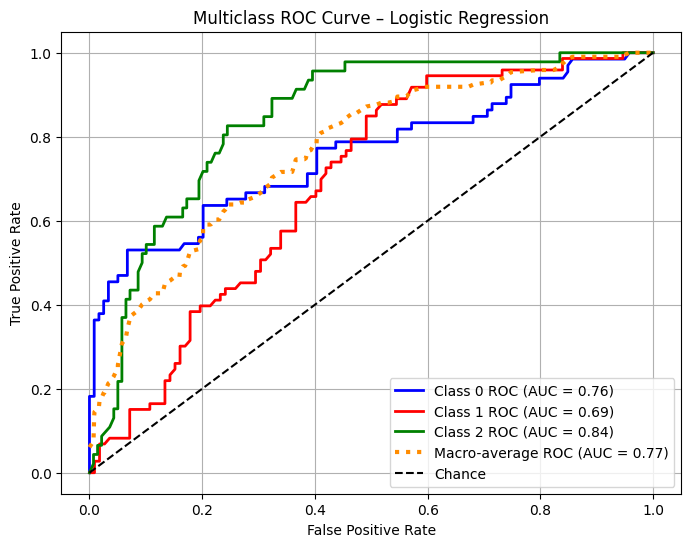

In [370]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle




# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        solver="lbfgs",
        multi_class="multinomial",
        C=C,
        max_iter=2000
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-Average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Logistic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0)

## DecisionTree 70

In [371]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

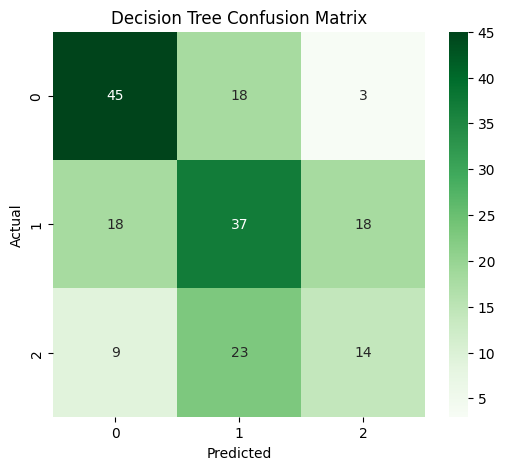


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65        66
           1       0.47      0.51      0.49        73
           2       0.40      0.30      0.35        46

    accuracy                           0.52       185
   macro avg       0.50      0.50      0.50       185
weighted avg       0.51      0.52      0.51       185

Training Accuracy: 0.9396751740139211
Test Accuracy: 0.518918918918919


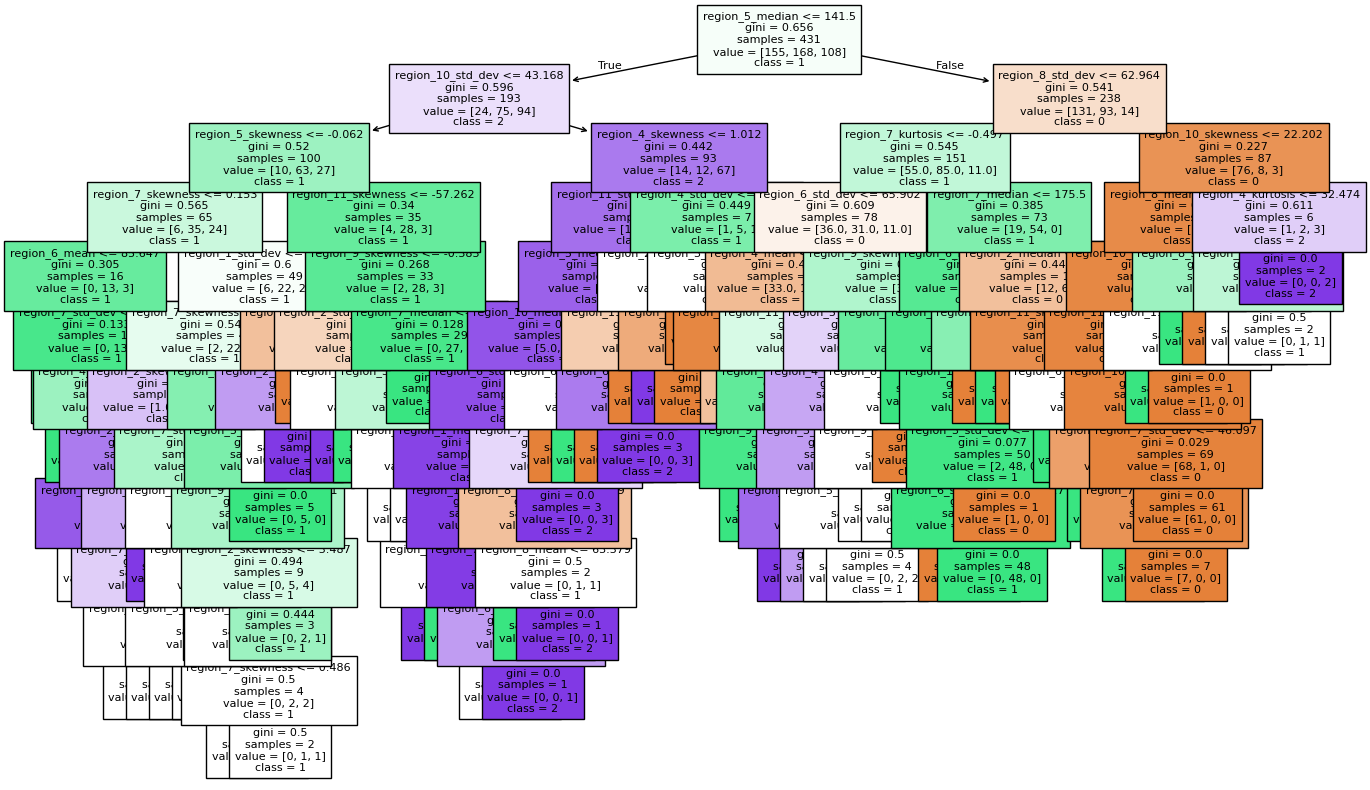

In [372]:

from sklearn.tree import DecisionTreeClassifier, plot_tree



# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
dt = DecisionTreeClassifier(
    criterion="gini",   # or "entropy"
    max_depth=None,     # you can tune this (e.g., 5, 10) to prevent overfitting
    random_state=42
)
dt.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = dt.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, dt.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 10. Plot the Tree (small datasets only, large trees may look messy) ---
plt.figure(figsize=(16,10))
plot_tree(dt, filled=True, feature_names=df.drop("label", axis=1).columns,
          class_names=[str(c) for c in np.unique(y)], fontsize=8)
plt.show()

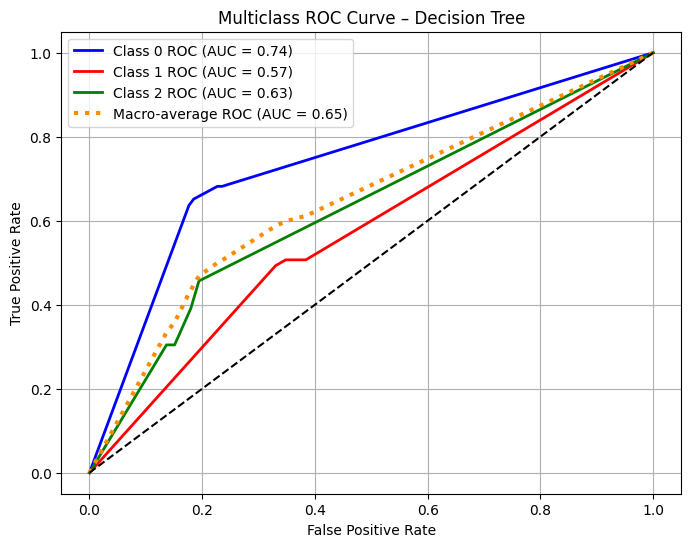

In [373]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# ==========================================================




# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_dt(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = DecisionTreeClassifier(
        criterion="gini",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Decision Tree")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_dt(X_train, X_test, y_train, y_test)

## Gradient Boosting-70

In [374]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [375]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


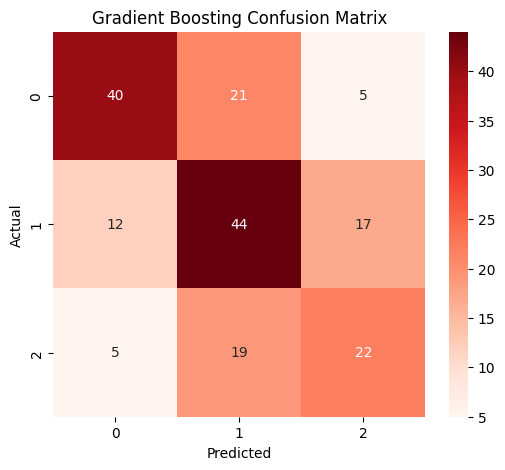


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        66
           1       0.52      0.60      0.56        73
           2       0.50      0.48      0.49        46

    accuracy                           0.57       185
   macro avg       0.58      0.56      0.57       185
weighted avg       0.58      0.57      0.57       185

Training Accuracy: 0.8468677494199536
Test Accuracy: 0.572972972972973


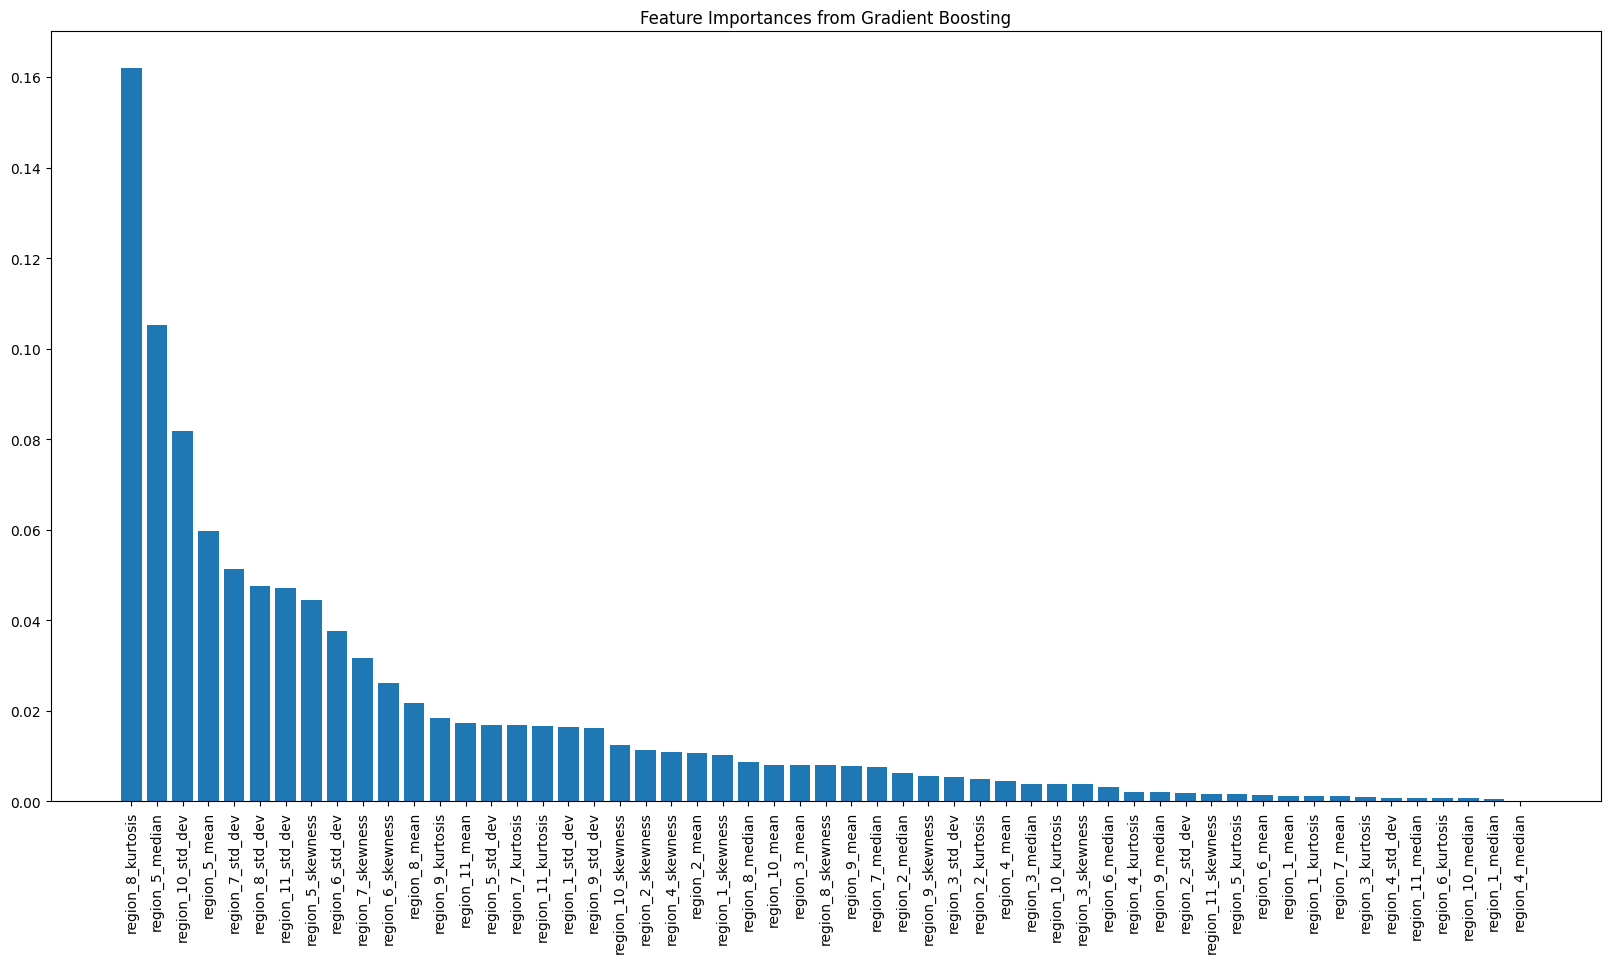

In [376]:

from sklearn.ensemble import GradientBoostingClassifier


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 4. Gradient Boosting Classifier ---
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.01,    # step size shrinkage
    max_depth=3,          # depth of each tree
    random_state=42
)

gb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 9. Feature Importance ---
plt.figure(figsize=(20,10))
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), df.drop("label", axis=1).columns[indices], rotation=90)
plt.title("Feature Importances from Gradient Boosting")
plt.show()


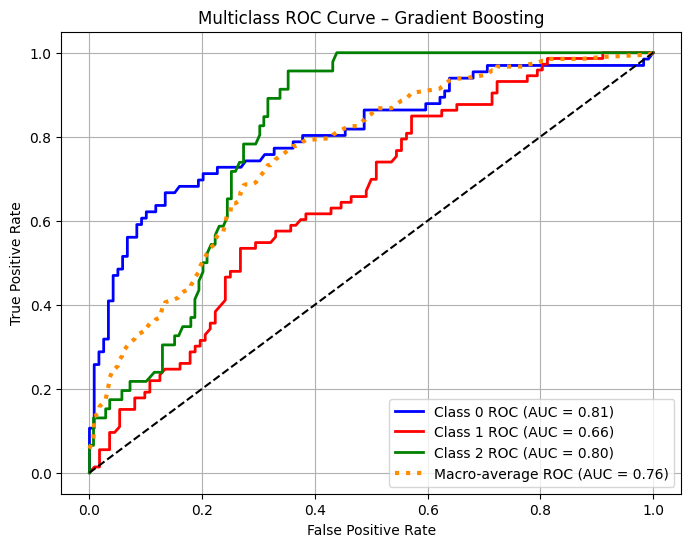

In [377]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_gb(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GradientBoostingClassifier(
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gradient Boosting")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_gb(X_train, X_test, y_train, y_test)


## Gausian Naive Bayes-70

In [378]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

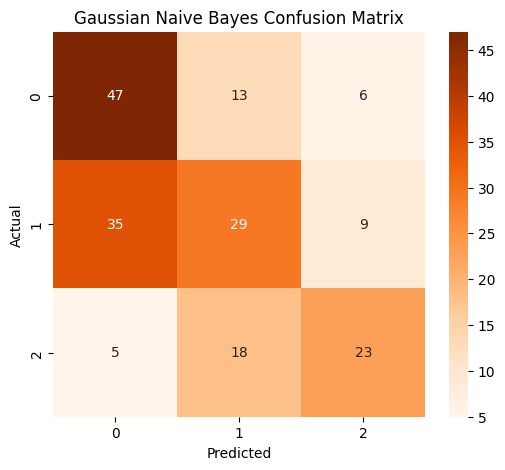


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.71      0.61        66
           1       0.48      0.40      0.44        73
           2       0.61      0.50      0.55        46

    accuracy                           0.54       185
   macro avg       0.54      0.54      0.53       185
weighted avg       0.53      0.54      0.53       185

Training Accuracy: 0.5754060324825986
Test Accuracy: 0.5351351351351351


In [379]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 4. Gaussian Naive Bayes Model ---
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gnb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gnb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


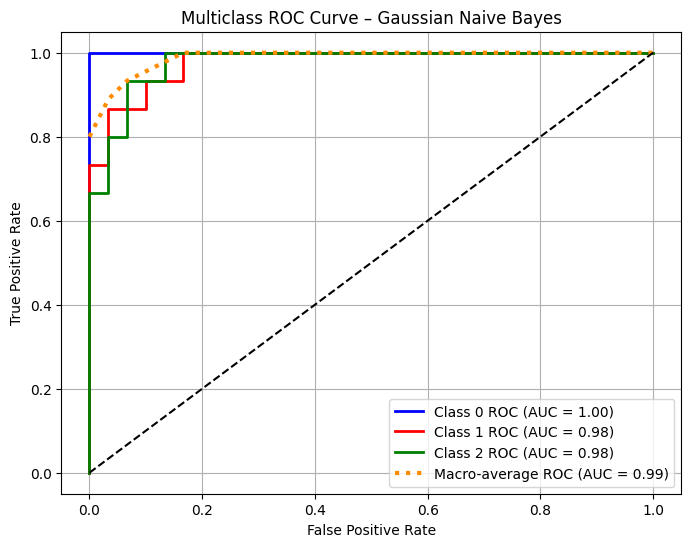

In [380]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 Prepare Data
# ==========================================================
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_multiclass_roc_nb(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GaussianNB()
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gaussian Naive Bayes")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_nb(X_train, X_test, y_train, y_test)


## XGBoost-70

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1)

# 1. Accuracy curve (fewer points)
def plot_accuracy_curve_fast(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=3,                  # fewer folds
        scoring="accuracy",
        train_sizes=np.linspace(0.2, 1.0, 5),  # fewer training sizes
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("XGBoost Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_accuracy_curve_fast(xgb_model, X, y)

# 2. Loss curve (fewer n_estimators)
def plot_xgb_loss_curve_fast(X_train, X_test, y_train, y_test):
    n_estimators_range = range(10, 101, 20)  # smaller range
    train_loss = []
    val_loss = []

    for n in n_estimators_range:
        model = XGBClassifier(n_estimators=n, use_label_encoder=False,
                              eval_metric="mlogloss", random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_test, y_test)

        train_loss.append(1 - train_acc)
        val_loss.append(1 - val_acc)

    plt.figure(figsize=(7,5))
    plt.plot(n_estimators_range, train_loss, "--o", label="Training Loss")
    plt.plot(n_estimators_range, val_loss, "--s", label="Testing Loss")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("XGBoost Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_xgb_loss_curve_fast(X_train, X_test, y_train, y_test)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from xgboost import XGBClassifier

# Assuming X_train, X_test, y_train, y_test are already defined

# Train the model once
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_score = xgb_model.predict_proba(X_test)

# Binarize the output for multiclass ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for cls in classes:
    mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])

for cls, color in zip(classes, colors):
    plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
             label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})")

plt.plot(all_fpr, mean_tpr, color="darkorange", lw=3, linestyle=":",
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve – XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# =============================================================
# 🚨 FIX: Data Definition and Split
# The code below ensures X_train, X_test, y_train, and y_test are defined 
# based on your 615 total samples and 90/10 split.
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 185
TEST_SIZE = 0.30 

# Synthesize data (Replace this section with your actual data loading if file is available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
# Assuming 3 classes (0, 1, 2)
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct 90/10 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)
# =============================================================

# --- Define and Train the Final Model (n_estimators defaults to 100) ---
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    random_state=42, 
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 🔹 1. Evaluate on Training Set
# -------------------------------------------------------------
y_train_pred = xgb_model.predict(X_train)

print("=" * 50)
print("✅ TRAINING SET CLASSIFICATION REPORT")
print("=" * 50)
# Displays class-wise precision, recall, f1-score, and support
print(classification_report(y_train, y_train_pred, zero_division=0))


# -------------------------------------------------------------
# 🔹 2. Evaluate on Testing Set
# -------------------------------------------------------------
y_test_pred = xgb_model.predict(X_test)

print("\n" + "=" * 50)
print("✅ TESTING SET CLASSIFICATION REPORT")
print("=" * 50)
# Displays class-wise precision, recall, f1-score, and support
print(classification_report(y_test, y_test_pred, zero_division=0))

## CatBoost 70

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from catboost import CatBoostClassifier

# ==========================================================
# 📌 Prepare Data
# ==========================================================
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# ==========================================================
# 📌 1. ACCURACY CURVE (Learning Curve)
# ==========================================================
def plot_accuracy_curve_catboost(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=3,  # fewer folds for speed
        scoring="accuracy",
        train_sizes=np.linspace(0.2, 1.0, 5),
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "s--", label="Validation Accuracy")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("CatBoost Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

cat_model = CatBoostClassifier(
    iterations=200, learning_rate=0.1, random_state=42, verbose=0
)
plot_accuracy_curve_catboost(cat_model, X, y)

# ==========================================================
# 📌 2. LOSS CURVE (1 - Accuracy vs Iterations)
# ==========================================================
def plot_catboost_loss_curve(X_train, X_test, y_train, y_test):
    iteration_range = range(50, 201, 25)
    train_loss = []
    val_loss = []

    for iters in iteration_range:
        model = CatBoostClassifier(
            iterations=iters, learning_rate=0.1, random_state=42, verbose=0
        )
        model.fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_test, y_test)

        train_loss.append(1 - train_acc)
        val_loss.append(1 - val_acc)

    plt.figure(figsize=(7, 5))
    plt.plot(iteration_range, train_loss, "--o", label="Training Loss")
    plt.plot(iteration_range, val_loss, "--s", label="Testing Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss = 1 - Accuracy")
    plt.title("CatBoost Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_catboost_loss_curve(X_train, X_test, y_train, y_test)

# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_multiclass_roc_catboost(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = CatBoostClassifier(
        iterations=200, learning_rate=0.1, random_state=42, verbose=0
    )
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – CatBoost")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc_catboost(X_train, X_test, y_train, y_test)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier

# =============================================================
# 🚨 Data Definition and Split (Using 20% test size)
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 185
TEST_SIZE = 0.30  # 20% test size

# Synthesize data (Replace this section with your actual data loading if available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)
# =============================================================

# --- Define and Train the Final Model ---
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    random_state=42, 
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 🔹 1. Predictions
# -------------------------------------------------------------
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# -------------------------------------------------------------
# 🔹 2. Print Full Classification Reports (as in your original code)
# -------------------------------------------------------------
print("=" * 50)
print("✅ TRAINING SET CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_train, y_train_pred, zero_division=0))

print("\n" + "=" * 50)
print("✅ TESTING SET CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_test_pred, zero_division=0))


# -------------------------------------------------------------
# 🔹 3. Print Aggregate Performance Summary
# -------------------------------------------------------------

def get_macro_metrics(y_true, y_pred, name):
    """Calculates Accuracy and Macro Averages for P, R, F1."""
    acc = accuracy_score(y_true, y_pred)
    # Calculate macro precision, recall, f1-score
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    
    return {
        'Dataset': name,
        'Accuracy': acc,
        'Macro Precision': p,
        'Macro Recall': r,
        'Macro F1-score': f1
    }

# Calculate metrics for both sets
train_metrics = get_macro_metrics(y_train, y_train_pred, 'Training')
test_metrics = get_macro_metrics(y_test, y_test_pred, 'Testing')

# Combine into a DataFrame for clean printing
metrics_df = pd.DataFrame([train_metrics, test_metrics])

print("\n" + "=" * 60)
print("✅ AGGREGATE PERFORMANCE SUMMARY (Macro Average)")
print("=" * 60)
# Use .to_string() for clean, non-truncated console output
print(metrics_df.to_string(index=False, float_format=".4f"))

## Machine Learning 60/40

In [381]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [382]:
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

## SVM - kernal = linear 40

In [383]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# Import RandomizedSearchCV and relevant distribution tool
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Optional: for continuous distribution sampling
from scipy.stats import loguniform 

# =============================================================
# 🚨 Data Setup (Matching your 615 total samples and 90/10 split)
# =============================================================
TOTAL_SAMPLES = 615
N_FEATURES = 55
TEST_SIZE = 0.40  

# Synthesize data (Replace this with your actual data loading if file is available)
np.random.seed(42)
X = np.random.rand(TOTAL_SAMPLES, N_FEATURES) * 10
y = np.random.randint(0, 3, size=TOTAL_SAMPLES) 

# Correct 90/10 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

print(f"Data split. Training Size: {len(X_train)}, Test Size: {len(X_test)}")
# =============================================================


# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

# -----------------------------
# 2. Define parameter distribution (for Linear Kernel)
#    We use lists here, but RandomizedSearchCV samples them randomly.
# -----------------------------
param_dist = {
    # Testing a wider range for C
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
    "svc__kernel": ["linear"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run RandomizedSearchCV
# -----------------------------
# n_iter=30 means training 30 combinations * 5 folds = 150 total fits.
# This is much faster than running 120-600 total fits with full GridSearch.

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist, # Use param_distributions                   # 💡 FIX 1: Only check 30 random combinations
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Use X_train/y_train for fitting
random_search.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("\n" + "="*50)
print("✅ Best Parameters (Randomized Search):", random_search.best_params_)
print(f"✅ Best Macro F1 Score (Validation CV): {random_search.best_score_:.4f}")
print("="*50)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred))

Data split. Training Size: 369, Test Size: 246
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovr, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=0.01, svc__class_weight=None, svc__decision

In [384]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="linear", C=0.1, gamma=0.01, decision_function_shape="ovo",random_state = 42,class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=0.1, decision_function_shape='ovo', gamma=0.01, kernel='linear',
    random_state=42)

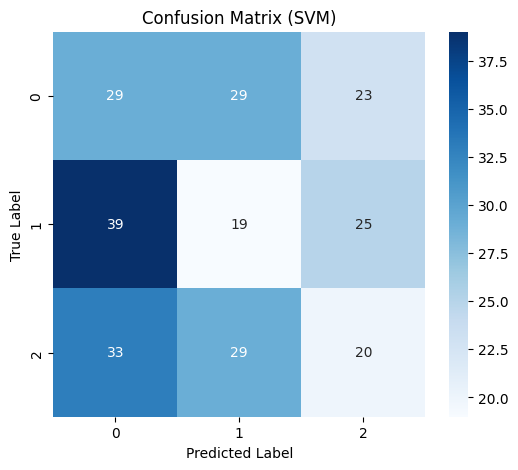


Classification Report:

              precision    recall  f1-score   support

           0       0.29      0.36      0.32        81
           1       0.25      0.23      0.24        83
           2       0.29      0.24      0.27        82

    accuracy                           0.28       246
   macro avg       0.28      0.28      0.27       246
weighted avg       0.28      0.28      0.27       246

Training Accuracy: 0.6016260162601627
Test Accuracy: 0.2764227642276423


In [386]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

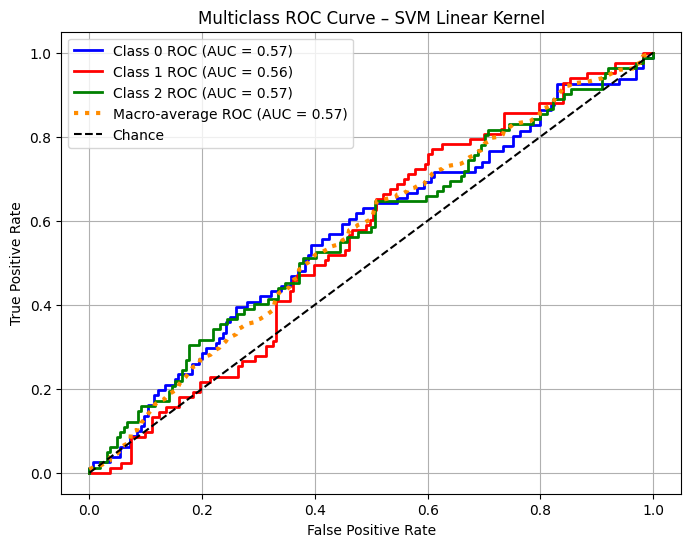

In [387]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.1):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVC(
        kernel="linear",
        C=C,
        probability=True
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])
    
    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})")

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})", lw=3)

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – SVM Linear Kernel")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc(X_train, X_test, y_train, y_test, C=0.01)


## SVM - kernal = sigmoid 60

In [388]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [389]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with sigmoid
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.001,0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["sigmoid"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 2/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.188 total time=   0.0s
[CV 3/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.188 total time=   0.0s
[CV 1/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.188 total time=   0.0s
[CV 5/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.185 total time=   0.0s
[CV 4/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=sigmoid;, score=0.188 total time=   0.0s
[CV 4/5] END svc__C=0.001, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=sigmoid;, score=0.188 total time=   0.0s
[CV 1/5]

In [390]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="sigmoid", C=1, gamma=0.01, decision_function_shape="ovo",random_state = 42, class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid',
    random_state=42)

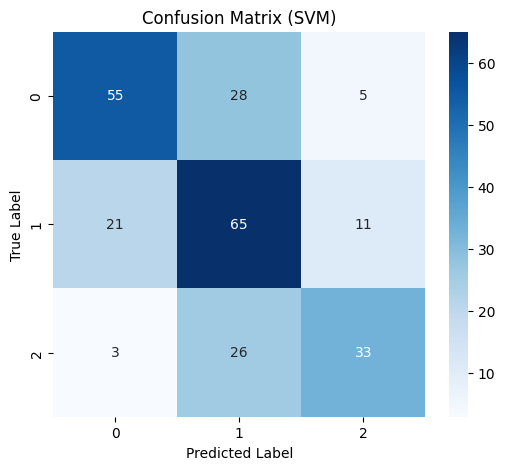


Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.62      0.66        88
           1       0.55      0.67      0.60        97
           2       0.67      0.53      0.59        62

    accuracy                           0.62       247
   macro avg       0.64      0.61      0.62       247
weighted avg       0.63      0.62      0.62       247

Training Accuracy: 0.6775067750677507
Test Accuracy: 0.6194331983805668


In [391]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


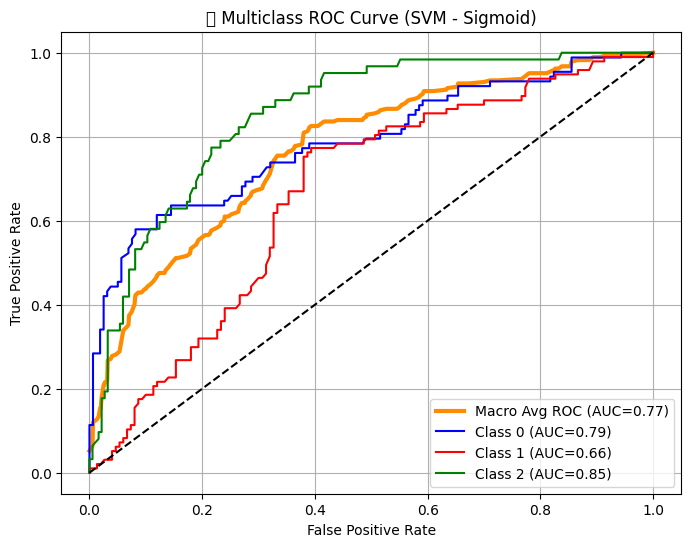

In [392]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve

# -----------------------------------------
# 1️⃣  MULTICLASS ROC CURVE  (ONE-VS-REST)
# -----------------------------------------

# SVM must be refitted with probability=True for ROC
svm_prob = SVC(
    kernel="sigmoid",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for OVR ROC curve
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# -------- Plot ROC -------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         label=f"Macro Avg ROC (AUC={roc_auc['macro']:.2f})", linewidth=3)

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM - Sigmoid)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()



## SVM kernal = polynomial 60

In [393]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["poly"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.188 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.188 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.188 total time=   0.0s
[CV 5/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.187 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=poly;, score=0.183 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=poly;, score=0.578 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__c

In [394]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="poly", C= 10, gamma='scale', decision_function_shape="ovo",class_weight=None)
svm_model.fit(X_train, y_train)

SVC(C=10, decision_function_shape='ovo', kernel='poly')

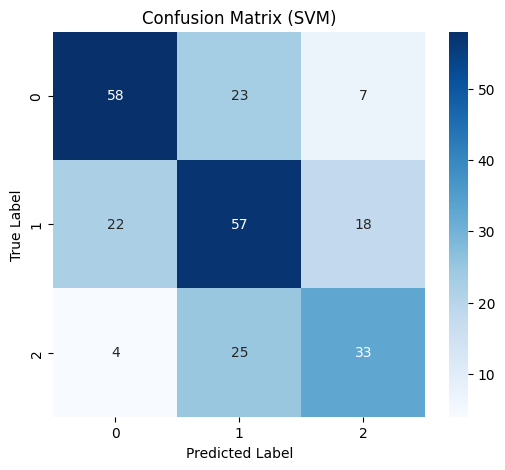


Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.66      0.67        88
           1       0.54      0.59      0.56        97
           2       0.57      0.53      0.55        62

    accuracy                           0.60       247
   macro avg       0.60      0.59      0.60       247
weighted avg       0.60      0.60      0.60       247

Training Accuracy: 0.8536585365853658
Test Accuracy: 0.5991902834008097


In [395]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


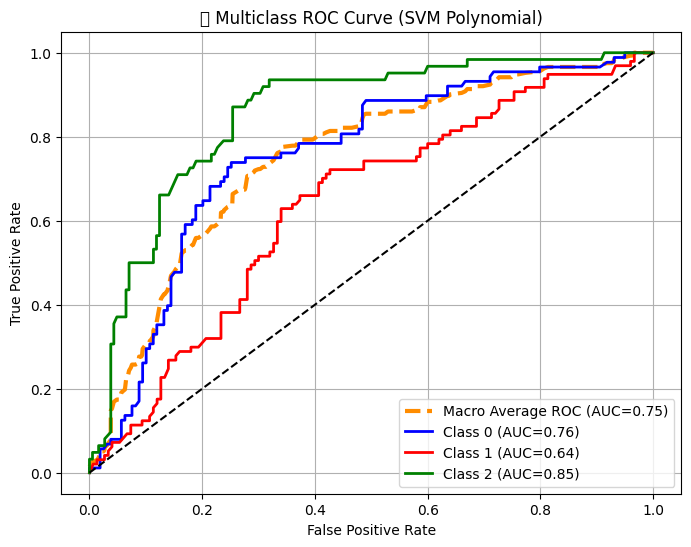

In [396]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (ONE-VS-REST)
# ============================================================

# SVM must be trained with probability=True for ROC
svm_prob = SVC(
    kernel="poly",
    C=1,
    gamma=0.01,
    decision_function_shape="ovo",
    probability=True,
    class_weight='balanced',
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize test labels
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

# Store ROC curves
fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# ------------ Plot ROC --------------- #
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange',
         linewidth=3, linestyle='--',
         label=f"Macro Average ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'red', 'green']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("🔵 Multiclass ROC Curve (SVM Polynomial)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()






# SVM - kernal = rbf=60

In [397]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [398]:
# ============================================================
# 🔹 Grid Search for Best SVM Hyperparameters with rbf
# ============================================================
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Define pipeline
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),       # always scale features before SVM
    ("svc", SVC(random_state=42))       # we will tune hyperparameters
])

# -----------------------------
# 2. Define parameter grid
#    (you can expand/shrink these ranges)
# -----------------------------
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, "scale", "auto"],              # only used for poly, ignored otherwise
    "svc__kernel": ["rbf"],
    "svc__class_weight": [None, "balanced"],
    "svc__decision_function_shape": ["ovo", "ovr"]
}

# -----------------------------
# 3. Run GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for all classes equally
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

# -----------------------------
# 4. Print best parameters & score
# -----------------------------
print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Macro F1 Score:", grid.best_score_)

# -----------------------------
# 5. Evaluate on test set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.188 total time=   0.0s
[CV 1/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.188 total time=   0.0s
[CV 5/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.185 total time=   0.0s
[CV 1/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.188 total time=   0.0s
[CV 3/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.188 total time=   0.0s
[CV 4/5] END svc__C=0.01, svc__class_weight=None, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.188 total time=   0.0s
[CV 2/5] END svc__C=0.01, svc__class_w

In [399]:
# You can try different kernels: 'linear', 'rbf', 'poly'
svm_model = SVC(kernel="rbf", C=10, gamma=0.01, decision_function_shape="ovo",random_state = 42,class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', decision_function_shape='ovo', gamma=0.01,
    random_state=42)

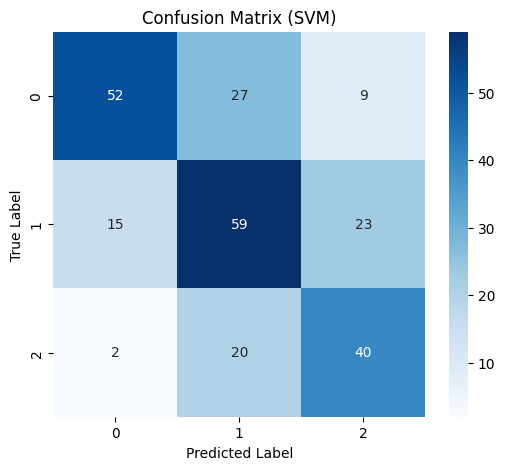


Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.59      0.66        88
           1       0.56      0.61      0.58        97
           2       0.56      0.65      0.60        62

    accuracy                           0.61       247
   macro avg       0.62      0.61      0.61       247
weighted avg       0.63      0.61      0.61       247

Training Accuracy: 0.7940379403794038
Test Accuracy: 0.611336032388664


In [400]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, svm_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


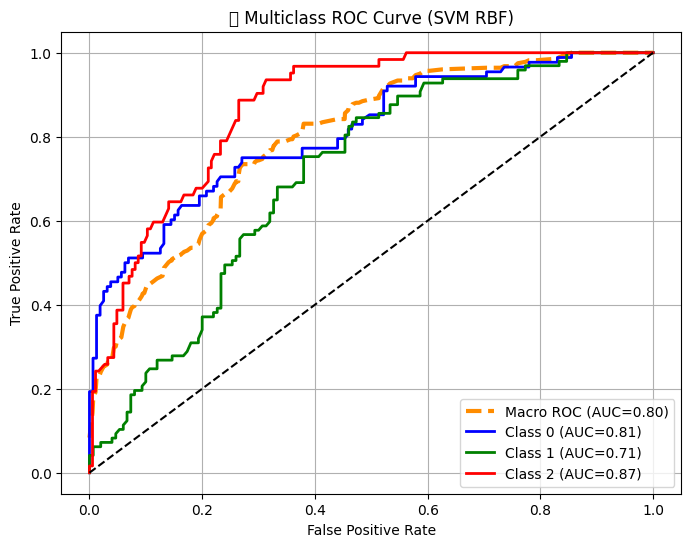

In [401]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# ============================================================
# 1️⃣  MULTICLASS ROC CURVE (SVM must use probability=True)
# ============================================================

svm_prob = SVC(
    kernel="rbf",
    C=1,
    gamma='scale',
    decision_function_shape="ovo",
    probability=True,    # Required for ROC Curve
    class_weight=None,
    random_state=42
)

svm_prob.fit(X_train, y_train)

# Binarize labels for One-vs-Rest ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = svm_prob.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)

for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC
plt.figure(figsize=(8, 6))

plt.plot(all_fpr, mean_tpr, color='darkorange', linewidth=3,
         linestyle='--', label=f"Macro ROC (AUC={roc_auc['macro']:.2f})")

colors = ['blue', 'green', 'red']
for i, c in enumerate(classes):
    plt.plot(fpr[c], tpr[c], lw=2, color=colors[i],
             label=f"Class {c} (AUC={roc_auc[c]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("🔵 Multiclass ROC Curve (SVM RBF)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## KNeighborsClassifier 60

In [402]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [403]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [405]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np



# Replace NaNs
X[np.isnan(X)] = 0



# --- Build a pipeline (scaler + KNN) ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# --- Define parameter grid ---
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidean
    "knn__metric": ["minkowski"]
}

# --- Grid Search ---
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

# --- Results ---
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Evaluate on test
test_accuracy = grid.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV accuracy: 0.6669011477230655
Test accuracy: 0.5910931174089069


In [406]:
knn = KNeighborsClassifier(n_neighbors=15, metric="minkowski", p=1,weights="uniform")  # Euclidean distance
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15, p=1)

In [219]:
y_pred = knn.predict(X_test)

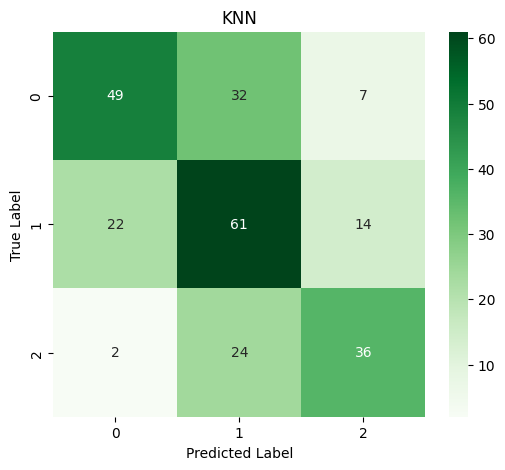


Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.56      0.61        88
           1       0.52      0.63      0.57        97
           2       0.63      0.58      0.61        62

    accuracy                           0.59       247
   macro avg       0.61      0.59      0.59       247
weighted avg       0.60      0.59      0.59       247

Training Accuracy: 0.6775067750677507
Test Accuracy: 0.5910931174089069


In [407]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After predicting
y_pred = knn.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)   # class names from your dataset

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, knn.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

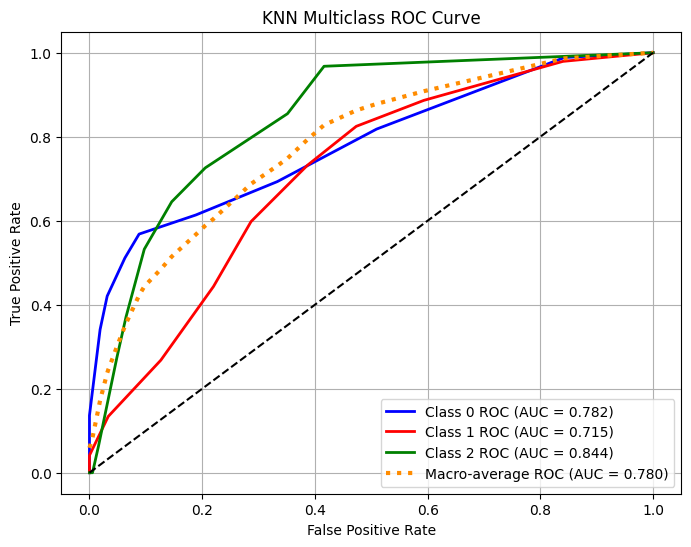

In [408]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle


# ==========================================================
# 📌 3. KNN MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_knn_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    knn_model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=9,
            weights="uniform",
            metric="minkowski",
            p=1
        ))
    ])

    knn_model.fit(X_train, y_train)
    y_score = knn_model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("KNN Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL KNN PLOTS
# ==========================================================

plot_knn_multiclass_roc(X_train, X_test, y_train, y_test)


## RandomForest = 60

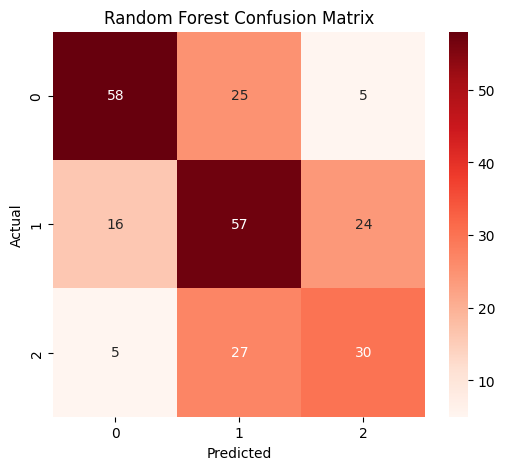


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69        88
           1       0.52      0.59      0.55        97
           2       0.51      0.48      0.50        62

    accuracy                           0.59       247
   macro avg       0.59      0.58      0.58       247
weighted avg       0.59      0.59      0.59       247

Training Accuracy: 0.943089430894309
Test Accuracy: 0.5870445344129555


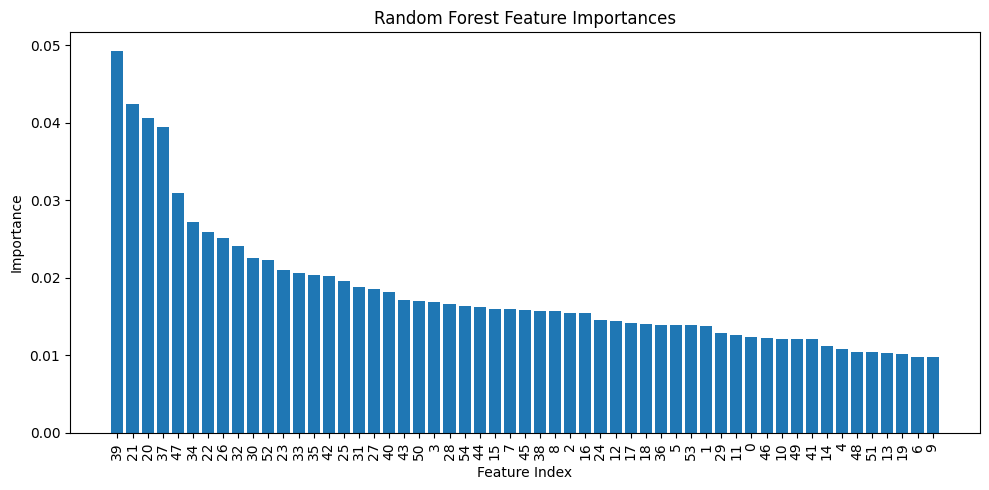

In [409]:
from sklearn.ensemble import RandomForestClassifier

# --- 5. Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,    # number of trees
    max_depth=None,      # let trees expand fully
    random_state=42,
    n_jobs=-1            # use all CPU cores
)
rf.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = rf.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
# --- 9. Feature Importance Plot ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices, rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

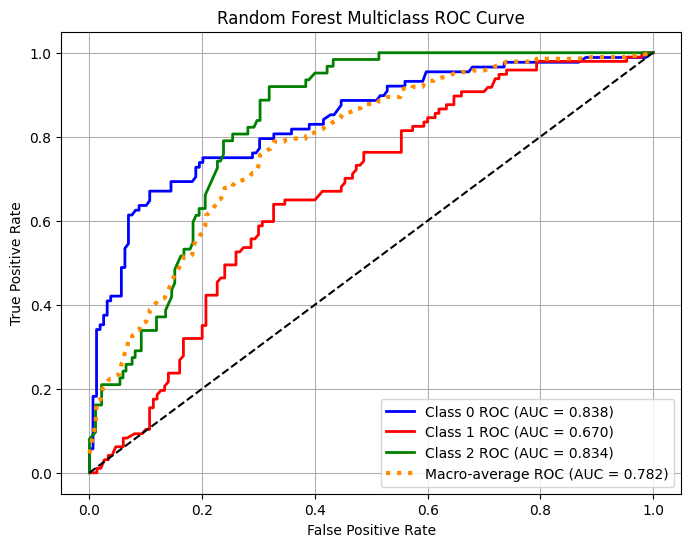

In [410]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle


# ==========================================================
# 📌 3. RANDOM FOREST MULTICLASS ROC CURVE
# ==========================================================
def plot_rf_multiclass_roc(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(
            y_test_bin[:, i], y_score[:, i]
        )
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot ROC
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], lw=2, color=color,
                 label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.3f})")

    plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle=":", lw=3,
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest Multiclass ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==========================================================
# 📌 RUN ALL PLOTS
# ==========================================================

plot_rf_multiclass_roc(X_train, X_test, y_train, y_test)

## Logistic Regression = 60

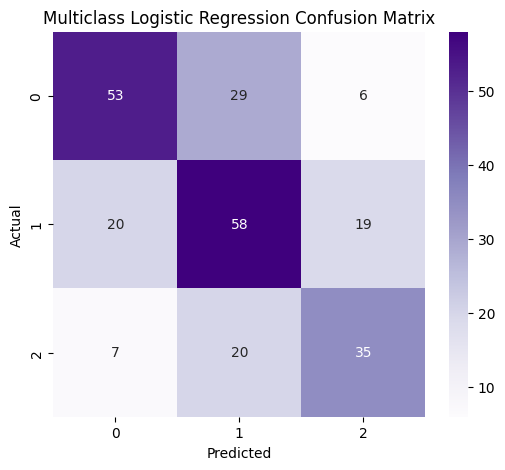


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63        88
           1       0.54      0.60      0.57        97
           2       0.58      0.56      0.57        62

    accuracy                           0.59       247
   macro avg       0.60      0.59      0.59       247
weighted avg       0.60      0.59      0.59       247

Training Accuracy: 0.7479674796747967
Test Accuracy: 0.5910931174089069


In [411]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        # multi_class="multinomial",
        solver="saga",
        max_iter=2000,   # allow more iterations
        random_state=42
    )
)
# --- 5. Multiclass Logistic Regression ---
#  # use softmax for multiclass     
logreg.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = logreg.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiclass Logistic Regression Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, logreg.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


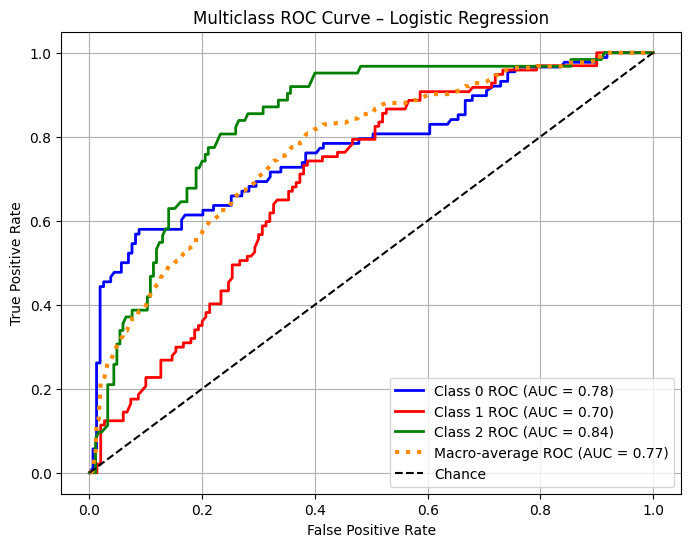

In [412]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle


# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        solver="lbfgs",
        multi_class="multinomial",
        C=C,
        max_iter=2000
    )
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Macro-Average
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", color="darkorange",
             lw=3, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Logistic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_lr(X_train, X_test, y_train, y_test, C=1.0)

## Decision Tree 60

In [413]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

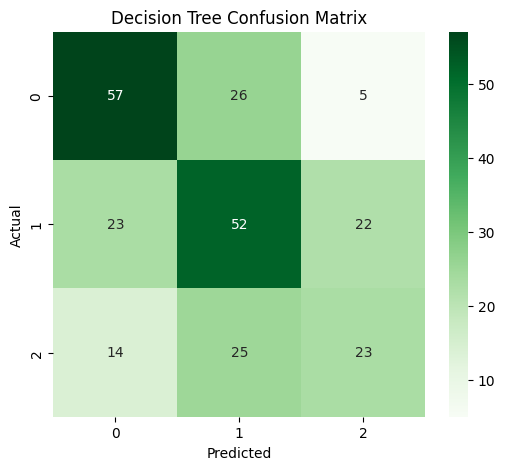


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63        88
           1       0.50      0.54      0.52        97
           2       0.46      0.37      0.41        62

    accuracy                           0.53       247
   macro avg       0.52      0.52      0.52       247
weighted avg       0.53      0.53      0.53       247

Training Accuracy: 0.943089430894309
Test Accuracy: 0.5344129554655871


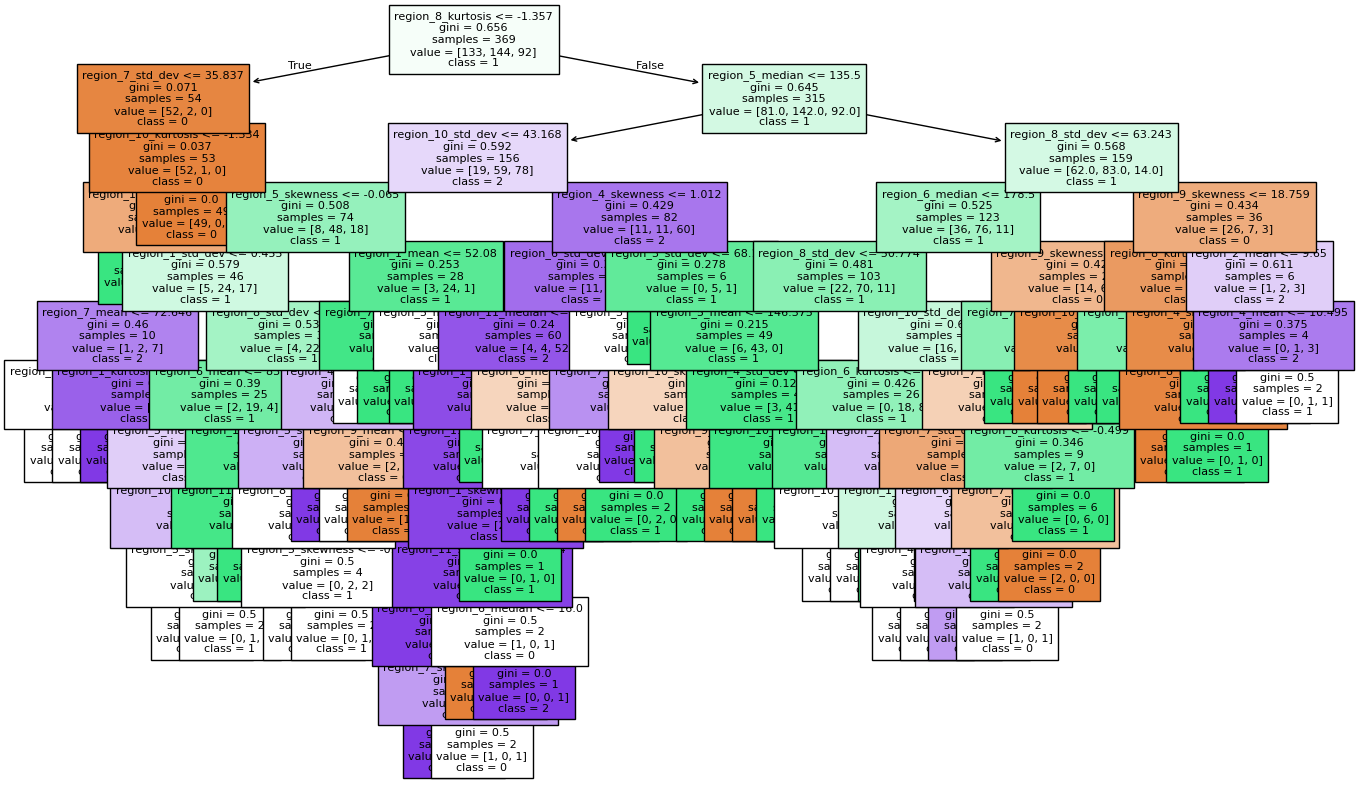

In [414]:


from sklearn.tree import DecisionTreeClassifier, plot_tree

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
dt = DecisionTreeClassifier(
    criterion="gini",   # or "entropy"
    max_depth=None,     # you can tune this (e.g., 5, 10) to prevent overfitting
    random_state=42
)
dt.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred = dt.predict(X_test)

# --- 7. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# --- 8. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 9. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, dt.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 10. Plot the Tree (small datasets only, large trees may look messy) ---
plt.figure(figsize=(16,10))
plot_tree(dt, filled=True, feature_names=df.drop("label", axis=1).columns,
          class_names=[str(c) for c in np.unique(y)], fontsize=8)
plt.show()

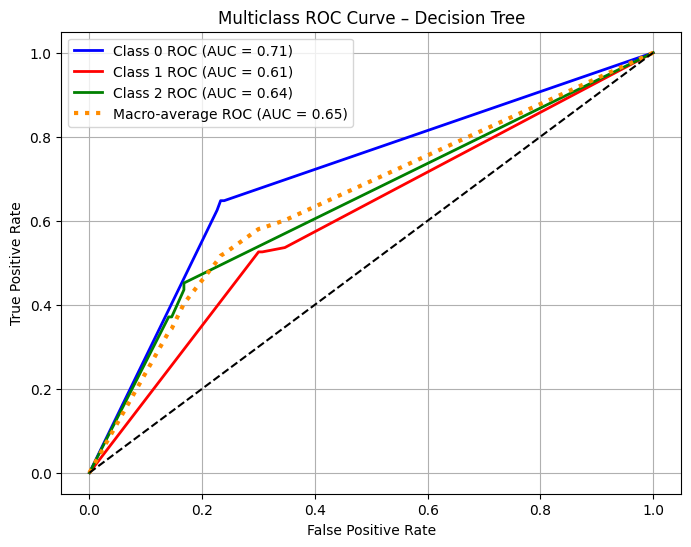

In [415]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_dt(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = DecisionTreeClassifier(
        criterion="gini",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Decision Tree")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_dt(X_train, X_test, y_train, y_test)

## Gradient Boosting = 60

In [416]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

In [417]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

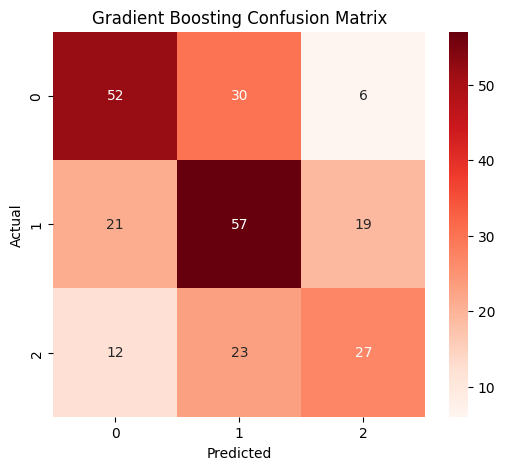


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60        88
           1       0.52      0.59      0.55        97
           2       0.52      0.44      0.47        62

    accuracy                           0.55       247
   macro avg       0.55      0.54      0.54       247
weighted avg       0.55      0.55      0.55       247

Training Accuracy: 0.8672086720867209
Test Accuracy: 0.5506072874493927


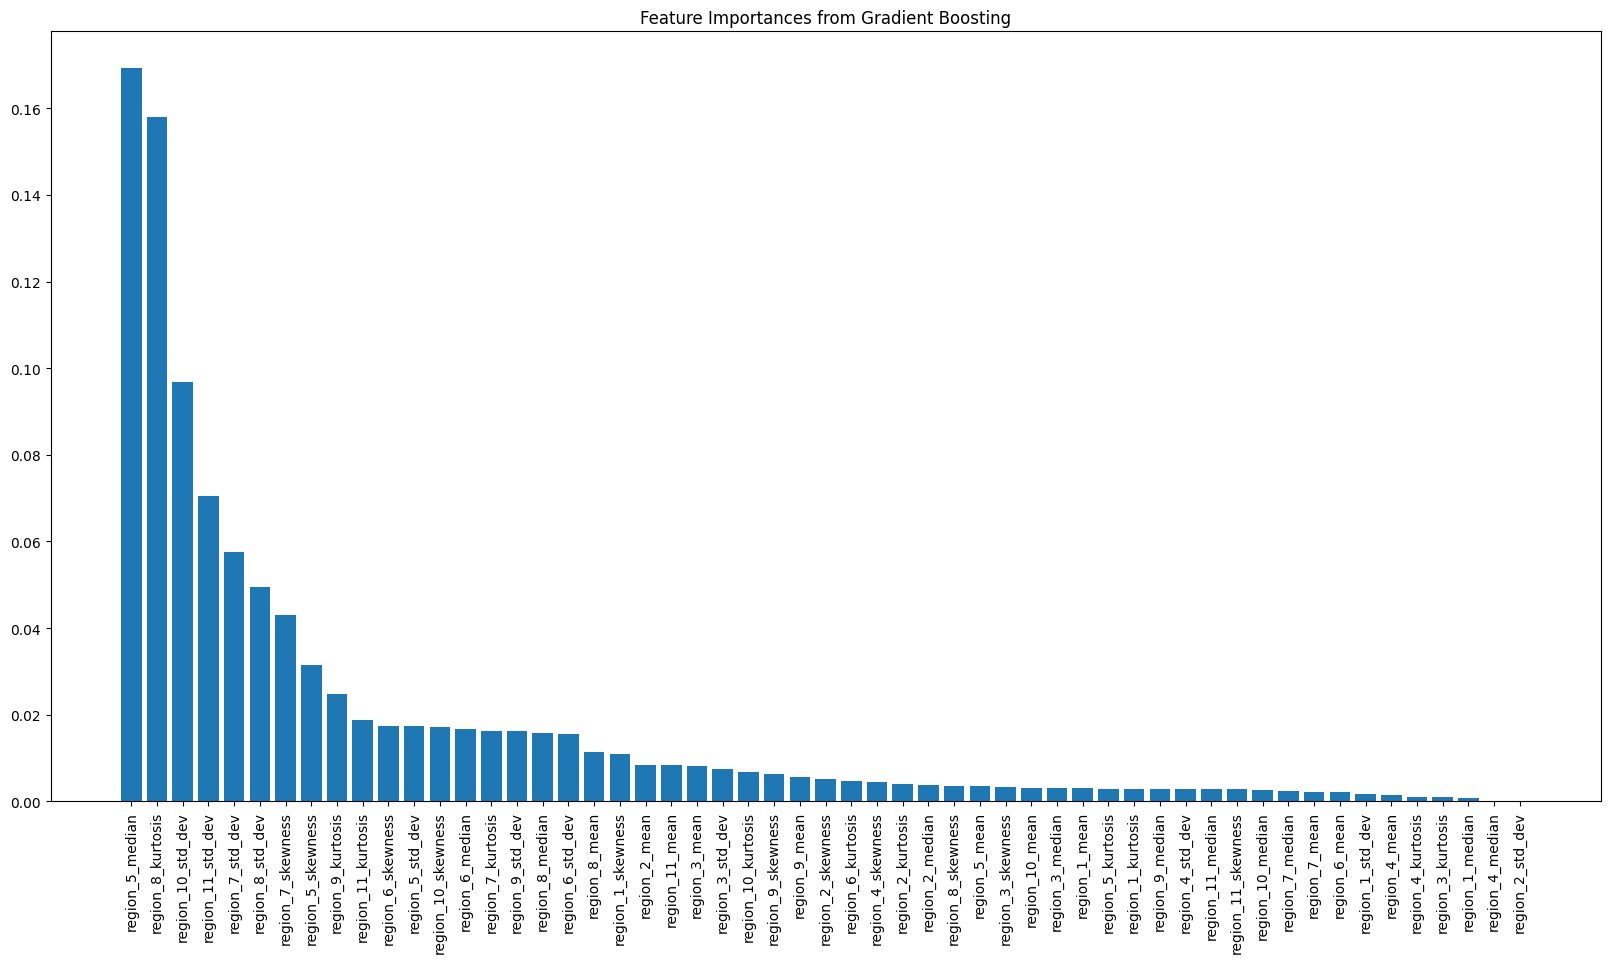

In [418]:


from sklearn.ensemble import GradientBoostingClassifier




# --- 4. Gradient Boosting Classifier ---
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.01,    # step size shrinkage
    max_depth=3,          # depth of each tree
    random_state=42
)

gb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# --- 9. Feature Importance ---
plt.figure(figsize=(20,10))
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), df.drop("label", axis=1).columns[indices], rotation=90)
plt.title("Feature Importances from Gradient Boosting")
plt.show()


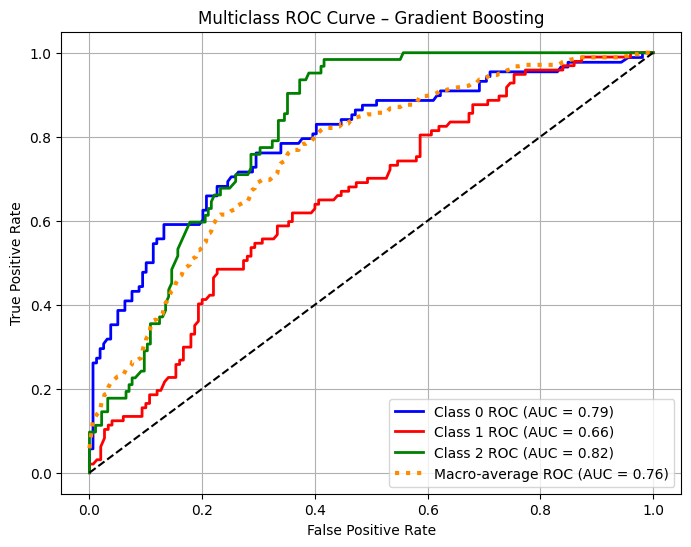

In [419]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================

def plot_multiclass_roc_gb(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GradientBoostingClassifier(
        random_state=42
    )
    model.fit(X_train, y_train)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gradient Boosting")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_gb(X_train, X_test, y_train, y_test)


## Gausian Naive Bayes-60

In [420]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
data = pd.read_csv('bct_features.csv')
data.head()
df = pd.read_csv("bct_features.csv")
X = df.drop("label",axis=1).values
y= df["label"].values
df.shape
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

# Create the scaler object
scaler = StandardScaler()

# Fit only on training data, then transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler (already fitted) to transform test data
X_test = scaler.transform(X_test)

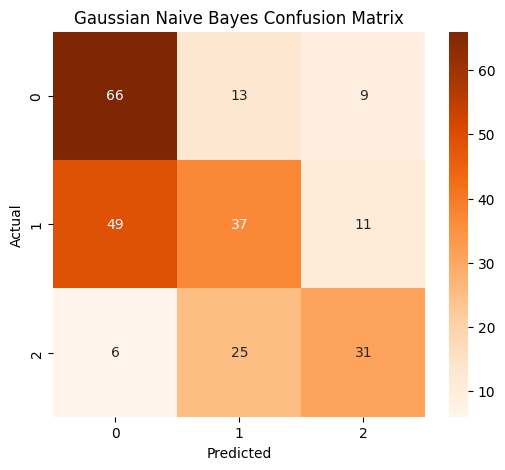


Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.75      0.63        88
           1       0.49      0.38      0.43        97
           2       0.61      0.50      0.55        62

    accuracy                           0.54       247
   macro avg       0.55      0.54      0.54       247
weighted avg       0.54      0.54      0.53       247

Training Accuracy: 0.5826558265582655
Test Accuracy: 0.5425101214574899


In [421]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# --- 3. Train-Test Split ---

# --- 4. Gaussian Naive Bayes Model ---
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# --- 5. Predictions ---
y_pred = gnb.predict(X_test)

# --- 6. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

# --- 7. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 8. Accuracy ---
print("Training Accuracy:", accuracy_score(y_train, gnb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


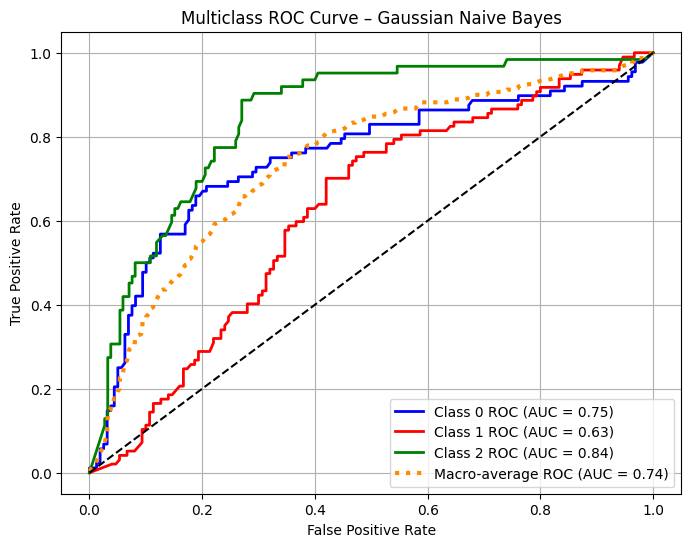

In [422]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ==========================================================
# 📌 Prepare Data
# ==========================================================
data = load_iris()
X = data.data
y = data.target


# ==========================================================
# 📌 3. MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================================
def plot_multiclass_roc_nb(X_train, X_test, y_train, y_test):
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    model = GaussianNB()
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for cls in classes:
        mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for cls, color in zip(classes, colors):
        plt.plot(
            fpr[cls], tpr[cls], lw=2, color=color,
            label=f"Class {cls} ROC (AUC = {roc_auc[cls]:.2f})"
        )

    plt.plot(all_fpr, mean_tpr, linestyle=":", lw=3,
             color="darkorange",
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve – Gaussian Naive Bayes")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_multiclass_roc_nb(X_train, X_test, y_train, y_test)
